In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform


Bad key text.latex.unicode in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/maxfrax/anaconda3/envs/default/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True

In [2]:
def plot_contour(X, clf, colors):
    # Creates a grid to fit all the data
    gx = np.linspace(min(X[:,0])-.2, max(X[:,0])+.2, 50)
    gy = np.linspace(min(X[:,1])-.2, max(X[:,1])+.2, 50)
    gX, gY = np.meshgrid(gx, gy)
    
    # Evaluates the radious of each point in the 2 dimensional space
    radiuses = [clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))]
    zs = np.array(radiuses)
    gZ = zs.reshape(gX.shape)
    membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radius_, ), colors='blue')
    plt.clabel(membership_contour, inline=1)

    plt.scatter(X[:,0], X[:,1], c=colors, alpha=.2)
    plt.show()

In [3]:
def print_report(clf, dataset):
    mistakes = sum(clf.predict(X))
    print(f'c: {clf.c}, q: {clf.q}')

    sv_count = 0
    bsv_count = 0
    for b in clf.betas_:
        if not np.isclose(b, 0) and not np.isclose(b, clf.c):
                    sv_count+=1
        if np.isclose(b, clf.c):
                    bsv_count+=1

    print(f'Support Vectors are {sv_count}, over {len(dataset)} candidates')
    print(f'Bounded Support Vectors are {bsv_count}, over {len(dataset)} candidates')
    print(f'Mistakes {mistakes}/{len(dataset)} = {mistakes/len(dataset)*100}%')

In [4]:
def count_zeros(y, y_pred, **kwargs):
    return len(y)-sum(y_pred)

scoring = {
    'zeros_scorer': make_scorer(count_zeros)
}

# FLOD goes federated over synthetic data

In this notebook we want to answer the following question:
"Can the server build a sphere containing all the data since the dataset is distributed to all the clients and unkown to the server?"

There is a fundamental issue in this test:
there are no outliers, so the naive 100% correct sphere would be the simplest and biggest one that can fit the space.

## 1. Single client scenario

We generate a synthetic dataset. 
All the points have label 0, since 1 means the points is an outlier.

With multiple centers, a low std is harder than a large one.

I have tested with centers from 1 to 5 and with std up to 2.
I also tried to raise the number of samples, but soon we hit the limit of how many points gurobi can handle

In [5]:
# With shuffle=false and number of centers equal to the number of clients
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, cluster_std=1.0, shuffle=False)

In [6]:
y = [0] * len(X)

In [7]:
X

array([[ 6.54875653, -8.63479036],
       [ 9.43501375, -8.64188032],
       [ 6.20467095, -8.6881095 ],
       ...,
       [ 2.1902207 ,  5.77118235],
       [ 4.89609823,  5.53536085],
       [ 2.04905487,  8.58774986]])

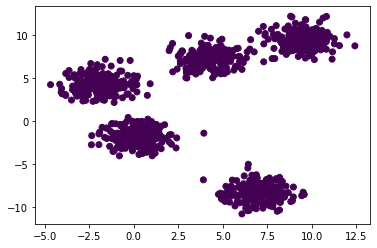

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Let's see if we can create a sphere containing all the points with our implementation of the classifier.

In [9]:
params = {
    'q': np.random.random_sample(size=5)*0.01,
    'c': [1]#uniform()    
}
clf = GridSearchCV(BSVClassifier(), params, cv=2, n_jobs=1, scoring=scoring, refit='zeros_scorer', return_train_score=False, verbose=10)
clf.fit(X, y)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2; 1/5] START c=1, q=0.001545861722197428.................................
Academic license - for non-commercial use only - expires 2023-05-28
Using license file /Users/maxfrax/gurobi.lic
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 500 columns and 500 nonzeros
Model fingerprint: 0xb89f67e9
Model has 125250 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bo

   9   2.89514180e-02  8.18389163e-01  5.29e-04 6.06e-10  7.90e-04     0s
  10   3.33457596e-02  1.78788679e-01  8.54e-05 9.79e-11  1.46e-04     0s
  11   4.62277434e-02  9.64263575e-02  1.71e-05 1.96e-11  5.02e-05     0s
  12   6.95788252e-02  8.45880429e-02  1.69e-06 1.94e-12  1.50e-05     0s
  13   8.07460351e-02  8.30192112e-02  1.80e-07 2.06e-13  2.27e-06     0s
  14   8.24719060e-02  8.27005100e-02  1.78e-08 2.05e-14  2.29e-07     0s
  15   8.26454469e-02  8.26683022e-02  1.77e-09 2.03e-15  2.29e-08     0s
  16   8.26627997e-02  8.26650852e-02  1.75e-10 1.94e-16  2.29e-09     0s
  17   8.26645349e-02  8.26647635e-02  1.74e-11 2.08e-17  2.29e-10     0s
  18   8.26647085e-02  8.26647313e-02  1.72e-12 2.78e-17  2.29e-11     0s
  19   8.26647258e-02  8.26647281e-02  1.76e-13 4.44e-16  2.29e-12     0s

Barrier solved model in 19 iterations and 0.04 seconds
Optimal objective 8.26647258e-02

[CV 1/2; 2/5] END c=1, q=0.0004527288965142884; zeros_scorer: (test=301.000) total time=   5.8s


Variable types: 125751 continuous, 0 integer (0 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Presolve removed 124751 rows and 501 columns
Presolved: 124751 rows, 125250 columns, 374750 nonzeros

Concurrent spin time: 1.20s

Solved with primal simplex (primal model)

Root relaxation: objective 1.000000e+00, 1 iterations, 4.19 seconds
Total elapsed time = 6.57s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.00000    0    1   -0.00000    1.00000      -     -    7s
H    0     0                       0.1489016    1.00000   572%     -    7s
     0     2    1.00000    0    1    0.14890    1.00000   572%     -   11s
     1     2    1.00000    1    -    0.14890    1.00000   572%   1.0   46s
     3     6    1.00000    1    3    0.14890    1.00000   572%   167   76s
     6    12    1.00000    2    6

Presolved model has 124750 bilinear constraint(s)
Variable types: 125751 continuous, 0 integer (0 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Presolve removed 124751 rows and 501 columns
Presolved: 124751 rows, 125250 columns, 374750 nonzeros

Concurrent spin time: 1.25s

Solved with primal simplex (primal model)

Root relaxation: objective 1.000000e+00, 1 iterations, 4.13 seconds
Total elapsed time = 6.44s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.00000    0    1   -0.00000    1.00000      -     -    7s
H    0     0                       0.2020929    1.00000   395%     -    7s
     0     2    1.00000    0    1    0.20209    1.00000   395%     -   11s
     1     2    1.00000    1    -    0.20209    1.00000   395%   1.0   46s
     3     6    1.00000    1    3    0.20209    1.00000   

GridSearchCV(cv=2, estimator=BSVClassifier(), n_jobs=1,
             param_grid={'c': [1],
                         'q': array([0.00154586, 0.00045273, 0.00672254, 0.00690073, 0.00832695])},
             refit='zeros_scorer',
             scoring={'zeros_scorer': make_scorer(count_zeros)}, verbose=10)

Theoretically, in the following plot there should be only one color, the one representing the points classified to 0.

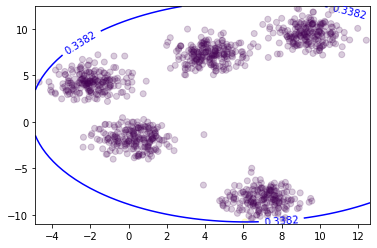

In [10]:
best_clf_single_client = clf.best_estimator_

plot_contour(X, best_clf_single_client, best_clf_single_client.predict(X))

In [11]:
print_report(best_clf_single_client, X)

c: 1, q: 0.0004527288965142884
Support Vectors are 3, over 1000 candidates
Bounded Support Vectors are 0, over 1000 candidates
Mistakes 2/1000 = 0.2%


Some times even this baseline does around 20% of mistakes.

## 2. Multiple client scenario

Let's split randomly the data generated before among k clients

In [12]:
clients = 5
points_per_client = int(len(X) / clients)

In [13]:
k = [X[i*points_per_client: (i+1)*points_per_client] for i in range(clients)]

colors = [int(i/points_per_client) for i in range(len(X))]

Let's plot again the previous plot, but this time the colors represent the client assignment

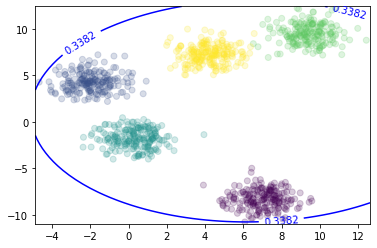

In [14]:
plot_contour(X, best_clf_single_client, colors)

### Federated primitives

#### 1. Init server model

In [15]:
def init_server_model():
    return {
        'q': 0.01,
        'C': 1,
        'betas': np.empty(shape=(0, 2)),
        'xs': np.empty(shape=(0, 2))
    }

#### 2. Client update

In [16]:
def client_compute_update(global_model, client_data):
    # Concat points from server and from client
    X = np.concatenate((global_model['xs'], client_data))
    # Init the classifier with q and C from server
    clf = BSVClassifier(q=global_model['q'], c=global_model['C'])
    # Train locally
    clf.fit(X, [0]*len(X))
    # Select only the positive betas related from client_data
    client_betas = clf.betas_[len(global_model['xs']):]
    assert(len(client_betas) == len(client_data))
    
    for i, t in enumerate(zip(client_betas, client_data)):
        b, x = t
        if not np.isclose(b, 0):
            yield x
    

#### 3. Server combines client updates

In [17]:
def global_combine(global_model, client_updates):
    # Concatenates server points and clients candidate points.
    X = np.concatenate((global_model['xs'], *client_updates))
    
    # Let's try also old hyper parameters. Notice: C is missing
    search_params = dict(params)
    search_params['q'] = np.append(search_params['q'], global_model['q'])
    
    # Performs model selection over this new dataset
    # Cross validation is low because I want to fit exactly the data I have got
    clf = GridSearchCV(BSVClassifier(), search_params, cv=2, n_jobs=1, scoring=scoring, refit='zeros_scorer', return_train_score=False, verbose=10)
    clf.fit(X, [0] * len(X))
    
    # Filter and keep only the support vectors
    xs = []
    betas = []
    for i, t in enumerate(zip(clf.best_estimator_.betas_, X)):
        b, x = t
        if not np.isclose(b, 0):
            xs.append(x)
            betas.append(b)
            
    return {
        'q': clf.best_estimator_.q,
        'C': clf.best_estimator_.c,
        'betas': betas,
        'xs': xs
    }, clf.best_estimator_

## Federated Learning simulation with one pass on data

In [18]:
import threading

number_of_rounds = 20

server_model = init_server_model()

# Metrics
debug_sk_models = []
debug_models = []
mistakes = []

client_updates = []

points_per_round = int(points_per_client / number_of_rounds)

def client_worker(client, round_ix):
    dataset = k[client]
    # Pick a data slice
    dataset = dataset[points_per_round*round_ix : points_per_round*(round_ix+1),:]
    update = client_compute_update(server_model, dataset)
    update = np.array(list(update))
    if update.size > 0:
        client_updates.append(update)

for r in tqdm(range(number_of_rounds)):
    client_updates = []
    #threads = []
    for client in range(clients):
        client_worker(client, r)
        #t = threading.Thread(target=client_worker, args=(client, r))
        #threads.append(t)
        #t.start()
        
    #for t in threads:
        #t.join()
        
    server_model, debug_model = global_combine(server_model, client_updates)
    mistakes.append(sum(debug_model.predict(X)))
    debug_models.append(server_model)
    debug_sk_models.append(debug_model)

  0%|          | 0/20 [00:00<?, ?it/s]

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x6c40aae7
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 4.500e+01
 

Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0xff2a5d5e
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 4.500e+01
 Factor NZ  : 5.500e+01
 Factor Ops : 3.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual   

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 15 columns and 15 nonzeros
Model fingerprint: 0x43c09c0d
Model has 120 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 15 columns, 15 nonzeros
Presolved model has 120 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 13
 AA' NZ     : 9.100e+01
 Factor NZ  : 1.050e+02
 Factor Ops : 1.015e

  16   7.54012105e-02  7.54017581e-02  2.74e-11 4.96e-16  1.89e-08     0s
  17   7.54015855e-02  7.54016403e-02  2.71e-12 5.79e-14  1.89e-09     0s
  18   7.54016231e-02  7.54016285e-02  2.69e-13 1.88e-13  1.89e-10     0s

Barrier solved model in 18 iterations and 0.04 seconds
Optimal objective 7.54016231e-02

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=7.000) total time=   0.1s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows,

   9   3.37121976e-01  1.17123868e+00  1.66e-04 1.79e-09  2.80e-02     0s
  10   3.89649146e-01  5.42700546e-01  1.87e-05 2.01e-10  5.12e-03     0s
  11   4.17802187e-01  4.49376097e-01  2.49e-06 2.68e-11  1.05e-03     0s
  12   4.28143593e-01  4.35849238e-01  5.38e-07 5.77e-12  2.57e-04     0s
  13   4.33098211e-01  4.34151029e-01  5.67e-08 6.09e-13  3.51e-05     0s
  14   4.33740083e-01  4.33904513e-01  8.39e-09 9.00e-14  5.49e-06     0s
  15   4.33854294e-01  4.33872375e-01  8.84e-10 9.55e-15  6.03e-07     0s
  16   4.33867394e-01  4.33869203e-01  8.77e-11 9.99e-16  6.04e-08     0s
  17   4.33868711e-01  4.33868892e-01  8.69e-12 1.11e-16  6.03e-09     0s
  18   4.33868843e-01  4.33868861e-01  8.61e-13 1.11e-16  6.03e-10     0s
  19   4.33868856e-01  4.33868858e-01  8.54e-14 4.88e-15  6.03e-11     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 4.33868856e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=4.000) total time=   0.0s
[CV

   1  -1.95712209e+04  2.29461564e+04  1.80e+03 5.04e-02  3.80e+04     0s
   2  -1.55046410e+04  1.64020808e+04  3.45e+02 9.64e-03  7.81e+03     0s
   3  -3.39339657e+02  8.09437139e+02  4.29e+01 1.20e-03  1.02e+03     0s
   4   2.30526681e+00  4.04633698e+02  4.25e+00 1.19e-04  1.11e+02     0s
   5   8.79430785e-01  3.19560906e+02  4.22e-01 1.18e-05  1.84e+01     0s
   6   3.82467744e-01  8.49303968e+01  4.18e-02 1.17e-06  3.02e+00     0s
   7   3.31630478e-01  9.46737709e+00  4.34e-03 1.21e-07  3.07e-01     0s
   8   3.57633990e-01  1.82863453e+00  6.07e-04 1.70e-08  4.91e-02     0s
   9   4.44779546e-01  7.41429726e-01  6.55e-05 1.83e-09  9.89e-03     0s
  10   4.77409533e-01  5.57517344e-01  1.41e-05 3.94e-10  2.67e-03     0s
  11   4.92087929e-01  5.09058698e-01  1.79e-06 5.02e-11  5.66e-04     0s
  12   4.98365237e-01  5.02416674e-01  3.51e-07 9.83e-12  1.35e-04     0s
  13   5.00620268e-01  5.01196659e-01  4.25e-08 1.19e-12  1.92e-05     0s
  14   5.00941872e-01  5.01009651e-01 

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 24
 AA' NZ     : 3.000e+02
 Factor NZ  : 3.250e+02
 Factor Ops : 5.525e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.19166834e+06  3.34332976e+05  1.57e+04 9.36e-02  2.53e+05     0s
   1   6.83674995e+04  1.39821379e+05  2.14e+03 1.27e-02  3.84e+04     0s
   2  -3.79272053e+04  7.71039992e+04  4.01e+02 2.39e-03  8.05e+03     0s
   3  -1.23402551e+04  2.09552139e+04  8.76e+01 5.23e-04  1.98e+03     0s
   4  -1.16548828e+03  3.01569702e+03  1.86e+01 1.11e-04  4.44e+02     0s
   5  -2.19499052e+02  6.22826655e+02  3.90e+00 2.33e-05  1.02e+02     0s
   6  -2.12887423e+02  3.08804013e+02  8.12e-01 4.84e-06  2.46e+01     0s
   7  -1.15856767e+02  1.66135946e+02  3.71e-01 2.21e-06  1.14e+01     0s
   8  -1.36040936e+01  4.95169023e+01  1.84e-01 1.10e-06  6.04e+00     0s
   9   1.44200407e+00  1.

Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+02
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.56725626e+07  1.35439433e+05  1.17e+04 1.56e-02  2.50e+05     0s
   1   2.05710230e+07  1.52380910e+04  2.51e+03 3.35e-03  5.45e+04     0s
   2   2.90444825e+06  4.73989780e+03  3.55e+02 4.74e-04  8.20e+03     0s
   3   4.06840886e+05  1.98899778e+03  4.99e+01 6.66e-05  1.22e+03     0s
   4   5.61499090e+04  3.40106545e+02  6.89e+00 9.20e-06  1.77e+02     0s
   5   7.96388001e+03  7.93392352e+01  9.81e-01 1.31e-06  2.73e+01     0s
   6   1.02084034e+03  1.68949038e+01  1.26e-01 1.68e-07  3.88e+00     0s
   7   1.55853886e+02  4.46998550e+00  1.93e-02 2.57e-08  6.52e-01     0s
   8   3.01800363e+01  1.50583394e+00  3.67e-03 4

  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 9 columns, 9 nonzeros
Presolved model has 45 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 8
 AA' NZ     : 3.600e+01
 Factor NZ  : 4.500e+01
 Factor Ops : 2.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.68338997e+06  2.51866858e+05  3.87e+03 3.88e+02  2.51e+05     0s
   1   9.00297611e+05  5.84249132e+03  4.42e+02 4.43e+01  2.90e+04     0s
   2   1.18166460e+05  1.79063522e+03  5.86e+01 5.86e+00  3.98e+03     0s
   3   1.53303932e+04  3.13666532e+02  7.63e+00 7.64e-01  5.44e+02     0s
   4   1.96347467e+03  2.20707469e+01  9.68e-01 9.70e-02  7.03e+01     0s
   5   2.55482777e+02  9.05584537e+00  1.29e-01 1.29e-02  9.91e+00     0s
   6   4.58702722e+01  3.68082125e+00  2.38e-02 2.39e-03  1.96e+00     0s
   7   7.82691643e+00  8.7070

Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x7e9fba51
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 4.500e+01
 Factor NZ  : 5.500e+01
 Factor Ops : 3.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.00004800e+04  5.19998937e-01  1.00e+04 1.00e+00  2.50e+05     0s
   1   1.00265292e+03  4.49426710e+02  1.00e+03 5.26e-02  2.51e+04     0s
   2   9.94331028e+01  4.93633820e+02  9.94e+01 5.22e-03  2.50e+03     0s
   3   9.91989562e+00  4.89197961e+02

   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 9 columns and 9 nonzeros
Model fingerprint: 0x40160620
Model has 45 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 9 columns, 9 nonzeros
Presolved model has 45 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 8
 AA' NZ     : 3.600e+01
 Factor NZ  : 4.500e+01
 Factor Ops : 2.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.


[CV 1/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=3.000) total time=   0.0s
[CV 2/2; 5/6] START c=1, q=0.008326950111858656.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x329ed23f
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s


  15   2.65959112e-01  2.65958694e-01  8.36e-11 3.95e-12  1.40e-08     0s
  16   2.65958647e-01  2.65958605e-01  8.36e-12 1.82e-12  1.40e-09     0s
  17   2.65958601e-01  2.65958597e-01  8.36e-13 1.16e-12  1.40e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 2.65958601e-01

[CV 2/2; 6/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=8.000) total time=   0.0s
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 19 columns and 19 nonzeros
Model fingerprint: 0x151c65c2
Model has 190 quadratic 

  17   5.88370517e-01  5.88372472e-01  1.13e-10 1.81e-14  5.81e-08     0s
  18   5.88371374e-01  5.88371570e-01  1.12e-11 1.80e-15  5.81e-09     0s
  19   5.88371461e-01  5.88371480e-01  1.11e-12 6.43e-14  5.81e-10     0s
  20   5.88371469e-01  5.88371471e-01  1.10e-13 2.10e-12  5.81e-11     0s

Barrier solved model in 20 iterations and 0.01 seconds
Optimal objective 5.88371469e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 24 columns and 24 nonzeros
Model fingerprint: 0xcb9e6395
Model has 300 quadratic objective terms
Coe

  15   5.83916630e-01  5.84019348e-01  4.81e-09 5.01e-13  2.24e-06     0s
  16   5.83979189e-01  5.83989792e-01  4.79e-10 4.98e-14  2.31e-07     0s
  17   5.83985676e-01  5.83986735e-01  4.75e-11 4.94e-15  2.30e-08     0s
  18   5.83986324e-01  5.83986430e-01  4.70e-12 4.89e-16  2.30e-09     0s
  19   5.83986389e-01  5.83986400e-01  4.66e-13 2.27e-13  2.30e-10     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 5.83986389e-01

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0

   8   6.54048645e-02  3.48198989e-01  1.52e-04 7.50e-09  1.29e-02     0s
   9   8.28324341e-02  1.37851176e-01  1.50e-05 7.43e-10  2.50e-03     0s
  10   8.87683468e-02  9.72024907e-02  1.59e-06 7.87e-11  3.83e-04     0s
  11   9.14385138e-02  9.31990224e-02  1.58e-07 7.80e-12  8.00e-05     0s
  12   9.25006749e-02  9.26994383e-02  1.56e-08 7.73e-13  9.04e-06     0s
  13   9.26117755e-02  9.26316521e-02  1.55e-09 7.66e-14  9.04e-07     0s
  14   9.26228842e-02  9.26248718e-02  1.53e-10 7.61e-15  9.04e-08     0s
  15   9.26239950e-02  9.26241938e-02  1.53e-11 7.49e-16  9.04e-09     0s
  16   9.26241061e-02  9.26241260e-02  1.53e-12 1.11e-16  9.04e-10     0s
  17   9.26241172e-02  9.26241192e-02  1.53e-13 1.11e-16  9.04e-11     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 9.26241172e-02

[CV 1/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=10.000) total time=   0.0s
[CV 2/2; 2/6] START c=1, q=0.0004527288965142884...........................

   5   8.99674280e+01  1.13224260e+01  2.28e-01 1.41e-03  1.10e+01     0s
   6   1.39458609e+01  5.65959119e+00  3.61e-02 2.24e-04  1.87e+00     0s
   7   1.96551871e+00  3.05154804e+00  3.58e-03 2.22e-05  2.61e-01     0s
   8   7.26694267e-01  1.55788475e+00  3.54e-04 2.20e-06  5.12e-02     0s
   9   5.93858524e-01  6.98018145e-01  3.85e-05 2.39e-07  5.57e-03     0s
  10   5.81299194e-01  6.00151280e-01  5.22e-06 3.23e-08  9.59e-04     0s
  11   5.82363496e-01  5.86569289e-01  5.75e-07 3.56e-09  2.02e-04     0s
  12   5.83686052e-01  5.84432124e-01  5.70e-08 3.53e-10  3.50e-05     0s
  13   5.83932018e-01  5.84035645e-01  6.21e-09 3.85e-11  4.83e-06     0s
  14   5.83979812e-01  5.83992355e-01  7.56e-10 4.69e-12  5.85e-07     0s
  15   5.83985738e-01  5.83986993e-01  7.58e-11 4.70e-13  5.85e-08     0s
  16   5.83986331e-01  5.83986456e-01  7.59e-12 4.70e-14  5.85e-09     0s
  17   5.83986390e-01  5.83986402e-01  7.59e-13 5.13e-14  5.85e-10     0s

Barrier solved model in 17 iterations

   0   1.08329898e+07  4.33398679e+05  5.50e+03 5.68e+01  2.67e+05     0s
   1   1.65001236e+06  7.70795180e+04  8.43e+02 8.70e+00  4.50e+04     0s
   2   2.57450749e+05  2.44780805e+04  1.38e+02 1.42e+00  8.13e+03     0s
   3   3.08528530e+04  4.32934333e+03  1.71e+01 1.77e-01  1.14e+03     0s
   4   3.97648678e+03  9.90177690e+02  2.40e+00 2.48e-02  1.92e+02     0s
   5   4.65935800e+02  2.38822686e+02  3.32e-01 3.43e-03  3.45e+01     0s
   6   5.63025420e+01  5.68686617e+01  4.93e-02 5.09e-04  6.66e+00     0s
   7   8.24292245e+00  1.43863329e+01  8.00e-03 8.26e-05  1.38e+00     0s
   8   1.55271410e+00  3.71660613e+00  9.64e-04 9.94e-06  2.37e-01     0s
   9   7.49835067e-01  1.43019052e+00  9.55e-05 9.85e-07  4.38e-02     0s
  10   6.29256477e-01  7.35471522e-01  1.21e-05 1.25e-07  6.03e-03     0s
  11   6.15461030e-01  6.33070590e-01  1.43e-06 1.48e-08  9.36e-04     0s
  12   6.16327392e-01  6.20125675e-01  2.40e-07 2.47e-09  1.95e-04     0s
  13   6.16933549e-01  6.17546923e-01 

Presolved: 1 rows, 11 columns, 11 nonzeros
Presolved model has 66 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 10
 AA' NZ     : 5.500e+01
 Factor NZ  : 6.600e+01
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.31091081e+06  1.21019839e+05  5.76e+03 3.57e+01  2.50e+05     0s
   1   3.61502994e+05  9.78092729e+03  8.79e+02 5.45e+00  3.87e+04     0s
   2   5.05224448e+04  1.61048973e+03  1.23e+02 7.65e-01  5.52e+03     0s
   3   5.91991612e+03  7.39171772e+01  1.42e+01 8.78e-02  6.44e+02     0s
   4   7.30592332e+02  1.85682082e+01  1.76e+00 1.09e-02  8.11e+01     0s
   5   8.99674280e+01  1.13224260e+01  2.28e-01 1.41e-03  1.10e+01     0s
   6   1.39458609e+01  5.65959119e+00  3.61e-02 2.24e-04  1.87e+00     0s
   7   1.96551871e+00  3.05154804e+00  3.58e-03 2.22e-05  2.61e-01     0s
   8   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x2c414598
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+0

Optimal objective 2.90107012e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x6455e074
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free

  16   2.85942544e-01  2.85942545e-01  4.77e-13 8.33e-17  1.71e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 2.85942544e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=2.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x45d553bd
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  14   7.94047559e-02  7.94162817e-02  6.49e-10 3.07e-12  1.19e-06     0s
  15   7.94104778e-02  7.94116304e-02  6.49e-11 3.07e-13  1.19e-07     0s
  16   7.94110500e-02  7.94111653e-02  6.49e-12 3.08e-14  1.19e-08     0s
  17   7.94111072e-02  7.94111188e-02  6.49e-13 3.00e-15  1.19e-09     0s
  18   7.94111130e-02  7.94111141e-02  6.49e-14 2.22e-16  1.19e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 7.94111130e-02

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=2.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optim

  11   5.81422573e-01  5.81676336e-01  6.83e-08 5.55e-17  3.17e-05     0s
  12   5.81512767e-01  5.81538743e-01  6.77e-09 1.73e-18  3.25e-06     0s
  13   5.81522831e-01  5.81525416e-01  6.71e-10 0.00e+00  3.23e-07     0s
  14   5.81523831e-01  5.81524089e-01  6.65e-11 5.55e-17  3.23e-08     0s
  15   5.81523931e-01  5.81523957e-01  6.65e-12 1.73e-18  3.23e-09     0s
  16   5.81523941e-01  5.81523943e-01  6.65e-13 0.00e+00  3.23e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 5.81523941e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parame

  10   4.77490503e-01  5.11278663e-01  4.03e-06 4.59e-14  3.39e-03     0s
  11   4.78825456e-01  4.84148928e-01  4.58e-07 5.22e-15  5.34e-04     0s
  12   4.80307949e-01  4.81100481e-01  4.54e-08 2.62e-15  7.94e-05     0s
  13   4.80693175e-01  4.80779892e-01  4.69e-09 3.08e-15  8.69e-06     0s
  14   4.80740525e-01  4.80749167e-01  4.69e-10 2.28e-18  8.66e-07     0s
  15   4.80745261e-01  4.80746124e-01  4.69e-11 1.70e-15  8.65e-08     0s
  16   4.80745734e-01  4.80745820e-01  4.65e-12 1.08e-19  8.65e-09     0s
  17   4.80745781e-01  4.80745790e-01  4.65e-13 1.62e-15  8.65e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 4.80745781e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev

   8   3.06461886e-01  1.24330049e+01  1.28e-03 3.67e-08  7.62e-01     0s
   9   2.32903369e-01  1.78443499e+00  1.48e-04 4.26e-09  8.81e-02     0s
  10   2.69611402e-01  5.48659938e-01  2.15e-05 6.19e-10  1.56e-02     0s
  11   2.83234765e-01  3.21902105e-01  2.14e-06 6.14e-11  2.16e-03     0s
  12   2.86219626e-01  2.94654455e-01  3.74e-07 1.08e-11  4.71e-04     0s
  13   2.89471139e-01  2.90645245e-01  3.93e-08 1.13e-12  6.54e-05     0s
  14   2.90024523e-01  2.90167314e-01  4.19e-09 1.20e-13  7.96e-06     0s
  15   2.90098056e-01  2.90113107e-01  4.33e-10 1.24e-14  8.38e-07     0s
  16   2.90106117e-01  2.90107621e-01  4.33e-11 1.24e-15  8.38e-08     0s
  17   2.90106924e-01  2.90107074e-01  4.29e-12 1.23e-16  8.38e-09     0s
  18   2.90107005e-01  2.90107020e-01  4.25e-13 4.15e-16  8.38e-10     0s
  19   2.90107013e-01  2.90107014e-01  4.21e-14 2.78e-17  8.38e-11     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 2.90107013e-01

Changed value of param

   8   2.63289105e+00  5.28703139e+00  3.90e-03 1.37e-07  3.49e-01     0s
   9   8.53861556e-01  1.77772698e+00  4.87e-04 1.71e-08  7.12e-02     0s
  10   3.18290329e-01  6.10917067e-01  4.83e-05 1.69e-09  1.12e-02     0s
  11   2.77563506e-01  3.24554788e-01  5.28e-06 1.85e-10  1.61e-03     0s
  12   2.87104172e-01  2.94100221e-01  5.98e-07 2.10e-11  2.30e-04     0s
  13   2.89701380e-01  2.90580215e-01  6.82e-08 2.39e-12  2.86e-05     0s
  14   2.90053368e-01  2.90161415e-01  8.08e-09 5.26e-13  3.51e-06     0s
  15   2.90101447e-01  2.90112498e-01  8.23e-10 1.73e-12  3.59e-07     0s
  16   2.90106457e-01  2.90107562e-01  8.23e-11 2.89e-15  3.59e-08     0s
  17   2.90106958e-01  2.90107068e-01  8.23e-12 2.51e-16  3.59e-09     0s
  18   2.90107008e-01  2.90107019e-01  8.23e-13 4.55e-13  3.59e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 2.90107008e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Cha

   4   7.38120563e+00  3.25498797e+01  6.06e-01 1.71e-09  4.94e+01     0s
   5   1.74379336e+00  2.07426976e+01  6.01e-02 1.70e-10  6.68e+00     0s
   6   4.44488491e-01  9.45015781e+00  5.95e-03 1.68e-11  1.33e+00     0s
   7   3.01421512e-01  1.36082967e+00  5.90e-04 1.67e-12  1.37e-01     0s
   8   2.88984507e-01  4.13335275e-01  5.99e-05 1.69e-13  1.58e-02     0s
   9   2.89556498e-01  3.06628032e-01  6.43e-06 1.82e-14  2.16e-03     0s
  10   2.91012745e-01  2.93287409e-01  6.77e-07 1.89e-15  2.87e-04     0s
  11   2.91524011e-01  2.91753016e-01  6.72e-08 2.22e-16  2.89e-05     0s
  12   2.91574753e-01  2.91597651e-01  6.66e-09 4.16e-15  2.89e-06     0s
  13   2.91579824e-01  2.91582114e-01  6.66e-10 2.78e-17  2.88e-07     0s
  14   2.91580332e-01  2.91580561e-01  6.66e-11 2.46e-15  2.88e-08     0s
  15   2.91580382e-01  2.91580405e-01  6.66e-12 6.01e-16  2.88e-09     0s
  16   2.91580387e-01  2.91580390e-01  6.66e-13 2.78e-17  2.88e-10     0s

Barrier solved model in 16 iterations

   2   6.37009713e+03  4.30669408e+03  4.16e+01 1.49e-07  4.91e+03     0s
   3  -3.54794155e+02  1.80201456e+03  5.57e+00 1.99e-08  8.27e+02     0s
   4  -1.63801331e+02  4.11917546e+02  9.22e-01 3.30e-09  1.55e+02     0s
   5  -3.07855334e+01  7.98732056e+01  1.60e-01 5.73e-10  3.04e+01     0s
   6  -6.10922105e-01  1.51059563e+01  3.09e-02 1.10e-10  6.26e+00     0s
   7   6.72654449e-01  5.84537333e+00  3.06e-03 1.09e-11  1.02e+00     0s
   8   1.27890430e-01  1.65281349e+00  3.03e-04 1.08e-12  1.72e-01     0s
   9   7.17474162e-02  2.95017604e-01  3.76e-05 1.34e-13  2.34e-02     0s
  10   7.31651758e-02  1.18173653e-01  6.43e-06 2.30e-14  4.67e-03     0s
  11   7.57080555e-02  8.42125089e-02  9.70e-07 3.55e-15  8.75e-04     0s
  12   7.83438154e-02  8.00227223e-02  1.68e-07 5.55e-16  1.72e-04     0s
  13   7.92994402e-02  7.94715077e-02  1.67e-08 3.40e-17  1.76e-05     0s
  14   7.93999665e-02  7.94171312e-02  1.65e-09 5.55e-17  1.76e-06     0s
  15   7.94099987e-02  7.94117151e-02 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.10475737e+05  1.28476737e+05  2.52e+03 8.00e+00  2.48e+05     0s
   1  -1.81386006e+04  2.04010012e+04  2.80e+02 4.95e-05  3.15e+04     0s
   2  -7.29253804e+03  7.76597210e+03  3.75e+01 6.64e-06  5.14e+03     0s
   3  -7.22513270e+02  9.21829523e+02  6.20e+00 1.10e-06  8.70e+02     0s
   4  -5.42009887e+00  1.58490296e+02  6.31e-01 1.12e-07  1.02e+02     0s
   5   8.97488424e-01  1.04749774e+02  6.26e-02 1.11e-08  1.88e+01     0s
   6   6.35941047e-01  2.02800057e+01  6.20e-03 1.10e-09  2.57e+00     0s
   7   6.01683598e-01  2.66559551e+00  6.41e-04 1.13e-10  2.60e-01     0s
   8   6.00780097e-01  8.66029183e-01  8.21e-05 1.45e-11  3.32e-02     0s
   9   6.02184938e-01  6.33041102e-01  8.99e-06 1.59e-12  3.87e-03     0s
  10   6.02335391e-01  6.06173655e-01  1.00e-06 1.78e-13  4.81e-04     0s
  11   6.02707979e-01  6.03162587e-01  9.94e-08 1.76e-14  5.69e-05     0s
  12   6.02802681e-01  6.02848642e-01 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.92675858e+05  4.66676858e+05  2.31e+03 3.20e+01  2.87e+05     0s
   1  -3.16205907e+04  4.52143310e+04  4.18e+02 2.22e-06  5.45e+04     0s
   2  -9.98391381e+03  1.16675810e+04  4.73e+01 2.51e-07  7.50e+03     0s
   3  -2.34107404e+03  2.64553418e+03  6.42e+00 3.41e-08  1.20e+03     0s
   4  -3.52529292e+02  4.48844199e+02  9.80e-01 5.20e-09  2.04e+02     0s
   5  -2.30122336e+01  8.57571956e+01  1.67e-01 8.86e-10  3.79e+01     0s
   6   3.04039291e-01  4.47597753e+01  1.65e-02 8.78e-11  6.75e+00     0s
   7   3.98274499e-01  9.75069371e+00  1.64e-03 8.70e-12  9.86e-01     0s
   8   4.13916931e-01  1.79387178e+00  2.15e-04 1.14e-12  1.39e-01     0s
   9   4.67928788e-01  7.45049627e-01  3.83e-05 2.03e-13  2.78e-02     0s
  10   4.80418104e-01  5.14213270e-01  4.04e-06 2.14e-14  3.39e-03     0s
  11   4.81359053e-01  4.86939890e-01  6.42

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 8
 AA' NZ     : 3.600e+01
 Factor NZ  : 4.500e+01
 Factor Ops : 2.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.39769895e+05  4.61174890e+05  2.76e+03 2.86e+01  2.72e+05     0s
   1   1.44217464e+05  5.11873356e+04  4.49e+02 4.65e+00  4.70e+04     0s
   2   1.46499343e+04  1.44903021e+04  6.67e+01 6.91e-01  7.62e+03     0s
   3   9.97972609e+02  2.65345244e+03  8.25e+00 8.54e-02  1.05e+03     0s
   4  -3.98777271e+01  6.83960143e+02  1.40e+00 1.45e-02  2.02e+02     0s
   5  -6.25601699e+01  1.79570322e+02  2.27e-01 2.36e-03  3.97e+01     0s
   6  -1.59881294e+01  4.62091196e+01  4.51e-02 4.67e-04  8.79e+00     0s
   7   2.90493856e-01  1.15242049e+01  9.47e-03 9.81e-05  2.02e+00     0s
   8   6.38226688e-01  5.19470015e+00  9.39e-04 9.73e-06  3.81e-01     0s
   9   3.23038969e-01  1.1

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+02
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.16273965e+06  1.85261475e+05  1.01e+04 2.87e-01  2.49e+05     0s
   1   1.50765103e+06  2.32465969e+04  1.66e+03 4.71e-02  4.18e+04     0s
   2   1.70235941e+05  4.97032825e+03  1.90e+02 5.39e-03  4.98e+03     0s
   3   1.91923263e+04  1.25489235e+03  2.21e+01 6.28e-04  6.26e+02     0s
   4   2.27778556e+03  2.80008763e+02  2.76e+00 7.82e-05  8.59e+01     0s
   5   3.16651334e+02  6.27708723e+01  4.02e-01 1.14e-05  1.38e+01     0s
   6   3.30411392e+01  1.60959309e+01  4.83e-02 1.37e-06  2.09e+00     0s
   7   4.13930802e+00  5.59304109e+00  7.67e-03 2.18e-07  4.35e-01     0s
   8   1.08982998e+00  2.13692630e+00  1.61e-03 4.58e-08  1.11e-01     0s
   9   3.43984674e-01  8.23424237e-01  1.60e-04

  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.98824279e+05  4.30825279e+05  4.00e+03 8.00e+00  2.92e+05     0s
   1  -1.68268239e+04  2.19351635e+04  6.33e+02 2.17e-03  4.65e+04     0s
   2   1.47433294e+02  4.51086580e+02  6.59e+01 2.26e-04  4.88e+03     0s
   3   2.00832087e+01  1.16834235e+02  7.89e+00 2.71e-05  6.01e+02     0s
   4   5.38690715e+00  7.38267130e+01  7.88e-01 2.71e-06  6.65e+01     0s
   5   7.76479890e-01  5.63362751e+01  7.81e-02 2.68e-07  1.14e+01     0s
   6   2.47634253e-01  1.35676381e+

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.07147298e+04  1.57715730e+05  3.03e+03 3.20e+01  2.44e+05     0s
   1  -1.45829061e+04  2.56533522e+04  3.42e+02 1.76e-06  3.24e+04     0s
   2  -6.14898675e+03  7.50274377e+03  4.01e+01 2.06e-07  4.76e+03     0s
   3  -1.13844821e+03  1.35499807e+03  5.45e+00 2.80e-08  7.64e+02     0s
   4  -1.11907671e+02  1.76275012e+02  9.47e-01 4.87e-09  1.40e+02     0s
   5   1.00886038

Model fingerprint: 0x9b9dca22
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.17795846e+05  2.22796846e+05  2.95e+03 1.00e+00  2.48e+05     0s
   1  -3.14361046e+03  4.34543963e+03  5.15e+02 9.24e-03  4.38e+04     0s
   2  -3.26240709e+02  8.26229705e+02  6.30e+01 1.13e-03  5.47e+03     0s
   3   3.78803110e+00  4.04521338e+02  6.34e+00 1.14e-04  5.85e+02     0s
   4   1.37850862e+00 

Model fingerprint: 0x06821e1d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [5e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.95778646e+05  2.08779646e+05  3.25e+03 4.00e+00  2.50e+05     0s
   1  -9.58783269e+03  1.12282538e+04  3.49e+02 1.59e-05  2.87e+04     0s
   2  -2.46793835e+03  2.84677253e+03  4.29e+01 1.96e-06  3.88e+03     0s
   3  -1.41261529e+02  3.51663102e+02  5.66e+00 2.58e-07  5.52e+02     0s
   4   6.56306775e-01 

Model fingerprint: 0x7f6b1386
Model has 36 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 8 columns, 8 nonzeros
Presolved model has 36 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 7
 AA' NZ     : 2.800e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.37470925e+06  3.14112591e+05  4.58e+03 9.01e+01  2.57e+05     0s
   1   6.17938047e+05  4.97973155e+04  6.52e+02 1.28e+01  4.04e+04     0s
   2   1.19335247e+05  9.78772858e+03  1.26e+02 2.48e+00  8.03e+03     0s
   3   1.43102887e+04  1.49328525e+03  1.54e+01 3.03e-01  1.07e+03     0s
   4   1.58246629e+03 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   6   8.03236981e+01  6.48749692e+01  5.59e-02 7.42e-07  5.12e+00     0s
   7   1.51892347e+01  1.97264206e+01  1.24e-02 1.65e-07  1.31e+00     0s
   8   4.54659084e+00  7.43303227e+00  3.69e-03 4.91e-08  4.41e-01     0s
   9   1.05973569e+00  2.10249362e+00  5.11e-04 6.79e-09  8.69e-02     0s
  10   3.80153880e-01  8.02667028e-01  5.07e-05 6.73e-10  1.64e-02     0s
  11   3.01498806e-01  3.93538943e-01  9.57e-06 1.27e-10  3.24e-03     0s
  12   2.96250589e-01  3.16742803e-01  1.18e-06 1.57e-11  6.51e-04     0s
  13   3.03796150e-01  3.07563516e-01  1.44e-07 1.91e-12  1.15e-04     0s
  14   3.05733802e-01  3.06239967e-01  1.83e-08 2.43e-13  1.53e-05     0s
  15   3.06002646e-01  3.06054136e-01  1.85e-09 2.46e-14  1.56e-06     0s
  16   3.06029797e-01  3.06034946e-01  1.85e-10 1.88e-13  1.56e-07     0s
  17   3.06032512e-01  3.06033027e-01  1.85e-11 8.09e-13  1.56e-08     0s
  18   3.06032783e-01  3.06032835e-01  1.85e-12 2.78e-17  1.56e-09     0s
  19   3.06032810e-01  3.06032816e-01 

   5  -1.23186055e+00  2.36065342e+02  1.09e+00 2.92e-05  3.36e+01     0s
   6   4.56642789e-01  1.59949372e+02  1.08e-01 2.90e-06  6.30e+00     0s
   7   2.22440669e-01  2.92425686e+01  1.07e-02 2.87e-07  8.41e-01     0s
   8   1.98935617e-01  3.46149582e+00  1.16e-03 3.12e-08  9.11e-02     0s
   9   2.28546586e-01  7.81430228e-01  1.56e-04 4.19e-09  1.54e-02     0s
  10   2.65446231e-01  3.83989341e-01  2.23e-05 6.00e-10  3.30e-03     0s
  11   2.81760344e-01  3.18138793e-01  5.24e-06 1.41e-10  1.01e-03     0s
  12   3.02355347e-01  3.10764022e-01  6.26e-07 1.68e-11  2.34e-04     0s
  13   3.05451579e-01  3.06639966e-01  8.84e-08 2.37e-12  3.30e-05     0s
  14   3.05971188e-01  3.06098419e-01  9.38e-09 2.52e-13  3.54e-06     0s
  15   3.06026646e-01  3.06039387e-01  9.40e-10 2.52e-14  3.54e-07     0s
  16   3.06032197e-01  3.06033471e-01  9.40e-11 5.24e-15  3.54e-08     0s
  17   3.06032752e-01  3.06032879e-01  9.31e-12 2.43e-16  3.54e-09     0s
  18   3.06032807e-01  3.06032820e-01 

   4  -2.68797884e+00  1.90524675e+02  1.03e+00 1.52e-06  1.37e+02     0s
   5   7.80297034e-01  1.41401645e+02  1.02e-01 1.51e-07  2.33e+01     0s
   6   3.28922829e-01  3.47948992e+01  1.01e-02 1.49e-08  3.67e+00     0s
   7   2.76764653e-01  3.81691012e+00  1.00e-03 1.48e-09  3.57e-01     0s
   8   2.76918788e-01  7.06514938e-01  1.10e-04 1.62e-10  4.31e-02     0s
   9   2.89177023e-01  3.68556957e-01  1.92e-05 2.84e-11  7.95e-03     0s
  10   2.95318175e-01  3.07072044e-01  2.30e-06 3.40e-12  1.18e-03     0s
  11   2.96643507e-01  2.98755311e-01  2.89e-07 4.27e-13  2.11e-04     0s
  12   2.97457204e-01  2.97709479e-01  3.03e-08 4.47e-14  2.52e-05     0s
  13   2.97543545e-01  2.97573594e-01  3.24e-09 4.77e-15  3.01e-06     0s
  14   2.97552222e-01  2.97555302e-01  3.27e-10 1.21e-15  3.08e-07     0s
  15   2.97553059e-01  2.97553366e-01  3.25e-11 1.11e-16  3.07e-08     0s
  16   2.97553142e-01  2.97553173e-01  3.25e-12 1.11e-16  3.07e-09     0s
  17   2.97553150e-01  2.97553153e-01 

   2  -6.73409871e+03  7.17730680e+03  3.97e+01 2.53e-05  4.90e+03     0s
   3  -8.57565651e+02  1.04636670e+03  6.60e+00 4.20e-06  8.53e+02     0s
   4  -1.29910090e+01  1.65634170e+02  7.42e-01 4.73e-07  1.09e+02     0s
   5   4.77025423e-01  1.07975973e+02  7.35e-02 4.69e-08  1.99e+01     0s
   6   4.18462694e-01  2.17135389e+01  7.29e-03 4.65e-09  2.79e+00     0s
   7   4.08563204e-01  3.01173965e+00  8.77e-04 5.59e-10  3.28e-01     0s
   8   4.51930067e-01  9.55189771e-01  1.64e-04 1.05e-10  6.31e-02     0s
   9   4.79235385e-01  5.45530551e-01  1.75e-05 1.12e-11  8.30e-03     0s
  10   4.80806717e-01  4.90924686e-01  2.30e-06 1.47e-12  1.27e-03     0s
  11   4.82326754e-01  4.84088041e-01  2.51e-07 1.60e-13  2.20e-04     0s
  12   4.83017010e-01  4.83286830e-01  2.90e-08 1.84e-14  3.38e-05     0s
  13   4.83178020e-01  4.83207812e-01  2.97e-09 1.89e-15  3.73e-06     0s
  14   4.83197840e-01  4.83200800e-01  2.98e-10 2.22e-16  3.70e-07     0s
  15   4.83199821e-01  4.83200117e-01 

   0  -2.28798412e+05  2.34799412e+05  3.11e+03 1.00e+00  2.48e+05     0s
   1  -3.69156071e+03  5.09995677e+03  5.49e+02 6.80e-04  4.43e+04     0s
   2  -4.05428289e+02  9.53186008e+02  7.00e+01 8.66e-05  5.75e+03     0s
   3   6.90470322e+00  4.23749604e+02  6.93e+00 8.58e-06  6.00e+02     0s
   4   1.80169682e+00  3.67515365e+02  6.87e-01 8.50e-07  8.53e+01     0s
   5   7.06811525e-01  1.46704851e+02  6.81e-02 8.42e-08  1.65e+01     0s
   6   5.92596361e-01  1.69030668e+01  6.75e-03 8.35e-09  1.65e+00     0s
   7   5.84425316e-01  2.38949522e+00  7.17e-04 8.88e-10  1.81e-01     0s
   8   5.98078400e-01  8.46728752e-01  7.82e-05 9.68e-11  2.49e-02     0s
   9   6.04189217e-01  6.34123062e-01  8.02e-06 9.92e-12  3.00e-03     0s
  10   6.06632794e-01  6.11335112e-01  8.98e-07 1.11e-12  4.70e-04     0s
  11   6.07997617e-01  6.08632836e-01  9.92e-08 1.23e-13  6.35e-05     0s
  12   6.08259794e-01  6.08324978e-01  1.01e-08 1.25e-14  6.52e-06     0s
  13   6.08287253e-01  6.08293752e-01 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.56560841e+04  2.13657084e+05  4.00e+03 3.20e+01  2.42e+05     0s
   1   1.07546900e+04  2.37013376e+03  4.10e+02 2.33e-05  2.47e+04     0s
   2   1.28708900e+03  3.87746991e+01  4.09e+01 2.33e-06  2.48e+03     0s
   3   1.30164613e+02  1.55717880e+01  4.07e+00 2.32e-07  2.47e+02     0s
   4   1.31537638e+01  1.51469792e+01  4.03e-01 2.29e-08  2.59e+01     0s
   5   1.53746922e+00  1.32871198e+01  3.99e-02 2.27e-09  3.71e+00     0s
   6   3.86101772e-01  5.33183580e+00  3.96e-03 2.25e-10  7.14e-01     0s
   7   2.72046743e-01  8.22133815e-01  3.92e-04 2.23e-11  7.12e-02     0s
   8   2.61463733e-01  3.27238319e-01  4.03e-05 2.30e-12  8.39e-03     0s
   9   2.65112385e-01  2.76683580e-01  4.55e-06 2.59e-13  1.46e-03     0s
  10   2.70121727e-01  2.71474748e-01  4.51e-07 2.56e-14  1.71e-04     0s
  11   2.70787419e-01  2.70922606e-01  4.47e-08 2.55e-15  1.71e-05     0s
  12   2.70853904e-01  2.70867423e-01 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.56399693e+07  1.50032070e+05  9.25e+03 3.13e-01  2.49e+05     0s
   1   1.45234966e+07  6.14437966e+04  1.78e+03 6.02e-02  5.00e+04     0s
   2   2.16612398e+06  3.30182617e+04  2.68e+02 9.08e-03  8.45e+03     0s
   3   2.54726104e+05  7.80192789e+03  3.20e+01 1.08e-03  1.18e+03     0s
   4   4.16833351e+04  1.67709797e+03  5.29e+00 1.79e-04  2.20e+02     0s
   5   9.12034267e+03  3.54705139e+02  1.15e+00 3.90e-05  5.12e+01     0s
   6   1.33806480e+03  9.92825633e+01  1.74e-01 5.88e-06  1.02e+01     0s
   7   2.41966288e+02  2.71946464e+01  3.20e-02 1.08e-06  2.14e+00     0s
   8   4.08157369e+01  5.88821005e+00  5.30e-03 1.79e-07  4.00e-01     0s
   9   5.37034449e+00  1.62462251e+00  6.67e-04 2.25e-08  7.22e-02     0s
  10   8.84425763e-01  6.51384462e-01  7.80e-05 2.64e-09  1.36e-02     0s
  11   3.56426616e-01  3.57051286e-01  8.50e-06 2.87e-10  2.07e-03     0s
  12   3.10033479e-01  3.12854783e-01 


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.84073583e+04  1.79408358e+05  1.37e+04 3.20e+01  2.49e+05     0s
   1  -4.10539175e+04  5.28135819e+04  1.43e+03 5.37e-02  2.83e+04     0s
   2  -3.56108223e+04  3.72892302e+04  1.81e+02 6.82e-03  4.79e+03     0s
   3  -1.15785479e+04  1.19781958e+04  3.27e+01 1.23e-03  1.04e+03     0s
   4  -3.03971337e+03  3.23588199e+03  1.02e+01 3.84e-04  3.38e+02     0s
   5  -7.79158590e+01  2.42081433e+02  2.19e+00 8.25e-05  7.75e+01     0s
   6   7.08793521e-01  1.36416511e+02  2.17e-01 8.18e-06  1.03e+01     0s
   7   3.60310755e-01  6.38106111e+01  2.15e-02 8.10e-07  2.07e+00     0s
   8   2.44157990e-01  7.84248560e+00  2.13e-03 8.03e-08  2.15e-01     0s
   9   2.41226168e-01  1.18383675e+00  2.27e-04 8.56e-09  2.63e-02     0s
  10   2.66084798e-01  4.60643987e-01  3.98e-05 1.50e-09  5.41e-03     0s
  11   2.82467420e-01  3.27917718e-01  6.38e-06 2.40e-10  1

Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.72916489e+05  2.93917489e+05  3.86e+03 8.00e+00  2.55e+05     0s
   1  -3.59690324e+04  3.88917538e+04  4.90e+02 3.32e-03  3.65e+04     0s
   2  -1.54289898e+04  1.60712295e+04  7.76e+01 5.25e-04  6.64e+03     0s
   3  -1.51592741e+03  1.81667845e+03  1.50e+01 1.02e-04  1.38e+03     0s
   4  -8.32959037e+00  2.44297860e+02  1.49e+00 1.01e-05  1.49e+02     0s
   5   7.94070108e-01  1.86470795e+02  1.48e-01 1.00e-06  2.40e+01     0s
   6   3.37597180e-01  5.32335845e+01  1.46e-02 9.91e-08  4.08e+00     0s
   7   2.79309201e-01  5.78785990e+00  1.45e-03 9.82e-09  3.97e-01     0s
   8   2.7

  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.82093307e+04  2.58210331e+05  3.79e+03 6.40e+01  2.40e+05     0s
   1   2.40563460e+04  5.24955575e+03  4.63e+02 1.07e-06  2.96e+04     0s
   2   1.36152536e+03  1.94225580e+03  5.20e+01 1.20e-07  3.55e+03     0s
   3  -1.97634310e+02  6.81624267e+02  7.42e+00 1.71e-08  5.67e+02     0s
   4   1.59613623e+01  7.30931510e+01  1.19e+00 2.74e-09  9.27e+01     0s
   5   6.82777631e+00  1.50388920e+01  1.21e-01 2.79e-10  1.03e+01     0s
 

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0xce53266a
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.23933020e+05  2.31934020e+05  4.00e+03 1.00e+00  2.49e+05     0s
   1  -3.55015569e+03  5.31492678e+03  7.05e+02 6.43e-04  4.42e+04     0s
   2  -5.75727226e+02  1.19374013e+03  

Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0x8f9a1add
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual       

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 18 columns and 18 nonzeros
Model fingerprint: 0x793da2d8
Model has 171 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 18 columns, 18 nonzeros
Presolved model has 171 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 16
 AA' NZ     : 1.360e+02
 Factor NZ  : 1.530e+02
 Factor Ops : 1.785e

Optimal objective 3.06032811e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 18 columns and 18 nonzeros
Model fingerprint: 0xe941dfd4
Model has 171 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 18 columns, 18 nonzeros
Presolved model has 171 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free

  17   2.70861285e-01  2.70861300e-01  9.28e-13 5.55e-17  1.51e-09     0s
  18   2.70861291e-01  2.70861293e-01  9.18e-14 3.47e-18  1.51e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 2.70861291e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x857ff3cb
Model has 15 quadra

  12   1.08513233e-01  1.09010513e-01  5.67e-08 2.07e-12  4.98e-05     0s
  13   1.08739233e-01  1.08791601e-01  5.86e-09 2.15e-13  5.24e-06     0s
  14   1.08762709e-01  1.08767942e-01  5.81e-10 2.13e-14  5.24e-07     0s
  15   1.08765054e-01  1.08765577e-01  5.81e-11 2.11e-15  5.24e-08     0s
  16   1.08765289e-01  1.08765341e-01  5.76e-12 2.22e-16  5.24e-09     0s
  17   1.08765312e-01  1.08765317e-01  5.71e-13 5.55e-17  5.24e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 1.08765312e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of param

   9   4.79384289e-01  5.79403188e-01  1.92e-05 2.67e-12  1.00e-02     0s
  10   4.82040521e-01  4.95525813e-01  2.40e-06 3.35e-13  1.35e-03     0s
  11   4.83511349e-01  4.86249304e-01  3.57e-07 4.97e-14  2.74e-04     0s
  12   4.84398016e-01  4.84869722e-01  3.79e-08 5.22e-15  4.72e-05     0s
  13   4.84612244e-01  4.84677478e-01  3.80e-09 5.55e-16  6.53e-06     0s
  14   4.84642421e-01  4.84651574e-01  3.77e-10 5.55e-17  9.16e-07     0s
  15   4.84645949e-01  4.84647258e-01  3.74e-11 5.55e-17  1.31e-07     0s
  16   4.84646286e-01  4.84646440e-01  3.72e-12 0.00e+00  1.54e-08     0s
  17   4.84646312e-01  4.84646327e-01  3.77e-13 6.94e-18  1.52e-09     0s
  18   4.84646314e-01  4.84646316e-01  6.55e-14 2.46e-16  1.52e-10     0s

Barrier solved model in 18 iterations and 0.07 seconds
Optimal objective 4.84646314e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=0.000) total time=   0.1s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481..............................

   6   6.15033876e-01  1.55429107e+01  5.90e-03 1.63e-09  1.51e+00     0s
   7   6.08605050e-01  2.28000286e+00  6.23e-04 1.73e-10  1.67e-01     0s
   8   6.22287677e-01  8.45489983e-01  6.59e-05 1.83e-11  2.23e-02     0s
   9   6.26783446e-01  6.53180306e-01  6.82e-06 1.89e-12  2.64e-03     0s
  10   6.28769519e-01  6.32776413e-01  7.23e-07 2.00e-13  4.01e-04     0s
  11   6.29786905e-01  6.30319673e-01  7.17e-08 1.98e-14  5.33e-05     0s
  12   6.30009017e-01  6.30065547e-01  7.10e-09 2.00e-15  5.65e-06     0s
  13   6.30035928e-01  6.30041553e-01  7.11e-10 2.22e-16  5.63e-07     0s
  14   6.30038618e-01  6.30039180e-01  7.11e-11 5.55e-17  5.62e-08     0s
  15   6.30038887e-01  6.30038943e-01  7.11e-12 1.08e-16  5.62e-09     0s
  16   6.30038913e-01  6.30038919e-01  7.11e-13 0.00e+00  5.62e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.30038913e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=2.000) total time=   0.0s
[CV

   4  -1.05331755e+03  1.21796624e+03  1.82e+00 8.93e-06  1.86e+02     0s
   5  -1.45957713e+02  1.99816474e+02  3.49e-01 1.71e-06  3.78e+01     0s
   6  -1.13155947e+00  3.39707560e+01  4.18e-02 2.05e-07  5.56e+00     0s
   7   4.28952901e-01  1.78513358e+01  4.14e-03 2.03e-08  1.11e+00     0s
   8   2.84123910e-01  2.73482499e+00  4.10e-04 2.01e-09  1.27e-01     0s
   9   2.77547261e-01  7.05633584e-01  7.00e-05 3.43e-10  2.17e-02     0s
  10   2.93768470e-01  3.81443549e-01  1.21e-05 5.91e-11  4.42e-03     0s
  11   2.98434922e-01  3.14980528e-01  2.07e-06 1.02e-11  8.34e-04     0s
  12   3.03202799e-01  3.07319724e-01  4.65e-07 2.28e-12  2.07e-04     0s
  13   3.05645956e-01  3.06227824e-01  6.40e-08 3.14e-13  2.93e-05     0s
  14   3.05993892e-01  3.06052683e-01  6.45e-09 3.16e-14  2.96e-06     0s
  15   3.06028921e-01  3.06034800e-01  6.45e-10 3.16e-15  2.96e-07     0s
  16   3.06032424e-01  3.06033012e-01  6.40e-11 3.19e-16  2.96e-08     0s
  17   3.06032775e-01  3.06032833e-01 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xa11f1e1b
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 4
 AA' NZ     : 1.000e+01
 Factor NZ  : 1.500e+01
 Factor Ops : 5.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.93433413e+05  3.67434413e+05  2.31e+03 3.20e+01  2.67e+05     0s
   1  -4.11800170e+04  5.51330168e+04  4.29e+02 8.19e-07  5.42e+04     0s
   2  -1.55366496e+04  1.76095387e+04  

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0xff1d25e7
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 20 columns, 20 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 18
 AA' NZ     : 1.710e+02
 Factor NZ  : 1.900e+02
 Factor Ops : 2.470e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.23638242e+07  4.04177804e+05  7.72e+03 9.12e-02  2.58e+05     0s
   1   1.67264759e+07  7.89217289e+04  1.78e+03 2.1

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0xc39eed70
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 20 columns, 20 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 16
 AA' NZ     : 1.360e+02
 Factor NZ  : 1.530e+02
 Factor Ops : 1.785e+03 (less than 1 second per iteration)
 Threads


[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=3.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0xa49e8c25
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Pr

  17   1.08994432e-01  1.08994443e-01  6.10e-13 5.55e-17  9.02e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 1.08994432e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xe0bdc610
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e

  16   6.10299565e-01  6.10299568e-01  7.27e-13 5.55e-17  3.24e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.10299565e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=3.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0xb2b5b776
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   6.33319103e-01  6.33319116e-01  1.90e-12 1.28e-16  1.06e-09     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.33319103e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x8a2a19ef
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   3.06032472e-01  3.06033120e-01  7.15e-11 4.33e-15  2.95e-08     0s
  17   3.06032779e-01  3.06032844e-01  7.09e-12 4.44e-16  2.95e-09     0s
  18   3.06032810e-01  3.06032817e-01  7.09e-13 1.11e-16  2.95e-10     0s

Barrier solved model in 18 iterations and 0.03 seconds
Optimal objective 3.06032810e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 21 columns and 21 nonzeros
Model fingerprint: 0x137d9a90
Model has 231 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  

  16   3.06031406e-01  3.06033710e-01  1.23e-10 8.88e-16  5.54e-08     0s
  17   3.06032673e-01  3.06032903e-01  1.23e-11 1.11e-16  5.54e-09     0s
  18   3.06032799e-01  3.06032822e-01  1.23e-12 1.13e-13  5.54e-10     0s
  19   3.06032812e-01  3.06032814e-01  1.23e-13 2.78e-17  5.54e-11     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 3.06032812e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 21 columns and 21 nonzeros
Model fingerprint: 0xeef5ba02
Model has 231 quadratic objective terms
Coe

  12   2.99186819e-01  3.00555475e-01  1.06e-07 3.58e-14  1.14e-04     0s
  13   2.99493426e-01  2.99672238e-01  1.07e-08 3.64e-15  1.49e-05     0s
  14   2.99541978e-01  2.99568985e-01  1.07e-09 3.61e-16  2.25e-06     0s
  15   2.99551133e-01  2.99555251e-01  1.06e-10 5.55e-17  3.43e-07     0s
  16   2.99552911e-01  2.99553546e-01  1.05e-11 3.47e-18  5.29e-08     0s
  17   2.99553281e-01  2.99553368e-01  1.05e-12 5.55e-17  7.27e-09     0s
  18   2.99553346e-01  2.99553355e-01  1.05e-13 2.78e-17  7.47e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 2.99553346e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=3.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter Numeri

   7   1.29725167e-01  1.03800795e+01  1.49e-03 1.18e-07  8.92e-01     0s
   8   9.78628558e-02  1.21276428e+00  1.57e-04 1.25e-08  9.36e-02     0s
   9   9.82600279e-02  2.81592589e-01  2.58e-05 2.05e-09  1.53e-02     0s
  10   1.06869790e-01  1.34650905e-01  2.55e-06 2.03e-10  2.32e-03     0s
  11   1.07978626e-01  1.12513487e-01  3.93e-07 3.12e-11  3.79e-04     0s
  12   1.08608573e-01  1.09438730e-01  6.02e-08 4.78e-12  6.93e-05     0s
  13   1.08932532e-01  1.09039456e-01  6.15e-09 4.88e-13  8.92e-06     0s
  14   1.08988100e-01  1.08998909e-01  6.10e-10 4.83e-14  9.02e-07     0s
  15   1.08993805e-01  1.08994885e-01  6.10e-11 4.88e-15  9.02e-08     0s
  16   1.08994375e-01  1.08994483e-01  6.10e-12 4.44e-16  9.02e-09     0s
  17   1.08994432e-01  1.08994443e-01  6.10e-13 5.55e-17  9.02e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 1.08994432e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=4.000) total time=   0.0s
[C

   5   8.75394807e-01  1.62073510e+02  8.78e-02 2.11e-09  2.18e+01     0s
   6   6.23592527e-01  3.89075104e+01  8.70e-03 2.09e-10  3.39e+00     0s
   7   5.83815433e-01  4.67331124e+00  8.98e-04 2.15e-11  3.43e-01     0s
   8   5.92253400e-01  1.16203653e+00  1.07e-04 2.57e-12  4.76e-02     0s
   9   6.02816752e-01  6.79123450e-01  1.25e-05 3.01e-13  6.37e-03     0s
  10   6.05192835e-01  6.20413752e-01  2.47e-06 5.93e-14  1.27e-03     0s
  11   6.08598463e-01  6.11716906e-01  4.42e-07 1.06e-14  2.60e-04     0s
  12   6.09992887e-01  6.10463092e-01  5.18e-08 1.28e-15  3.92e-05     0s
  13   6.10256548e-01  6.10314172e-01  5.13e-09 1.11e-16  4.81e-06     0s
  14   6.10294912e-01  6.10300874e-01  5.09e-10 0.00e+00  4.97e-07     0s
  15   6.10299103e-01  6.10299695e-01  5.04e-11 5.55e-17  4.93e-08     0s
  16   6.10299520e-01  6.10299579e-01  5.00e-12 5.55e-17  4.93e-09     0s
  17   6.10299562e-01  6.10299568e-01  4.95e-13 5.55e-17  4.93e-10     0s

Barrier solved model in 17 iterations

   3   9.00726898e+00  4.38661667e+02  7.17e+00 1.52e-06  5.54e+02     0s
   4   1.94542728e+00  3.84801297e+02  7.11e-01 1.51e-07  7.75e+01     0s
   5   7.58675673e-01  1.60428975e+02  7.04e-02 1.49e-08  1.52e+01     0s
   6   6.36222462e-01  1.87442097e+01  6.98e-03 1.48e-09  1.53e+00     0s
   7   6.25040429e-01  2.54701902e+00  7.26e-04 1.54e-10  1.61e-01     0s
   8   6.27899970e-01  8.63970508e-01  7.80e-05 1.65e-11  1.97e-02     0s
   9   6.29383474e-01  6.59758970e-01  8.92e-06 1.89e-12  2.53e-03     0s
  10   6.31196384e-01  6.37223107e-01  1.66e-06 3.52e-13  5.03e-04     0s
  11   6.32778636e-01  6.33793229e-01  1.94e-07 4.10e-14  8.46e-05     0s
  12   6.33237724e-01  6.33362190e-01  1.94e-08 4.11e-15  1.04e-05     0s
  13   6.33310400e-01  6.33323169e-01  1.96e-09 3.89e-16  1.06e-06     0s
  14   6.33318244e-01  6.33319514e-01  1.94e-10 5.55e-17  1.06e-07     0s
  15   6.33319025e-01  6.33319152e-01  1.92e-11 5.55e-17  1.06e-08     0s
  16   6.33319103e-01  6.33319116e-01 

   1   5.85003457e+04  1.20979284e+04  1.03e+03 4.45e-02  3.20e+04     0s
   2   6.06572229e+03  3.84699480e+03  1.44e+02 6.21e-03  4.66e+03     0s
   3  -7.32453118e+02  1.81997376e+03  1.52e+01 6.58e-04  5.88e+02     0s
   4  -3.93158203e+02  5.59381844e+02  2.01e+00 8.66e-05  9.35e+01     0s
   5  -7.99631464e+01  1.21655097e+02  3.42e-01 1.48e-05  1.78e+01     0s
   6  -4.76029956e+00  2.53849669e+01  6.59e-02 2.85e-06  3.84e+00     0s
   7   4.85514568e-01  1.21418954e+01  6.54e-03 2.82e-07  7.12e-01     0s
   8   2.77689327e-01  2.48501650e+00  6.48e-04 2.79e-08  9.74e-02     0s
   9   2.65696907e-01  6.94621152e-01  1.21e-04 5.22e-09  1.83e-02     0s
  10   2.90316984e-01  3.74291414e-01  1.76e-05 7.59e-10  3.55e-03     0s
  11   2.96847660e-01  3.21515086e-01  4.82e-06 2.08e-10  1.04e-03     0s
  12   3.01466403e-01  3.07919160e-01  1.01e-06 4.36e-11  2.72e-04     0s
  13   3.05356369e-01  3.06587051e-01  1.42e-07 6.12e-12  5.17e-05     0s
  14   3.05962977e-01  3.06090439e-01 


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.87607913e+06  1.39922181e+05  9.14e+03 1.18e-01  2.50e+05     0s
   1   4.25463606e+05  5.92543015e+03  1.31e+03 1.69e-02  3.63e+04     0s
   2   4.84315199e+04  1.23576353e+03  1.50e+02 1.94e-03  4.22e+03     0s
   3   4.77097603e+03  6.89996687e+02  1.65e+01 2.13e-04  4.85e+02     0s
   4   3.95460784e+02  2.76685270e+02  1.98e+00 2.56e-05  6.54e+01     0s
   5   1.60584078e+00  9.13426477e+01  2.47e-01 3.20e-06  1.03e+01     0s
   6  -9.08677427e+00  3.42575911e+01  5.42e-02 7.01e-07  2.61e+00     0s
   7  -6.00533750e-01  1.10340268e+01  1.43e-02 1.85e-07  7.49e-01     0s
   8   5.72758215e-01  4.45492960e+00  1.42e-03 1.84e-08  1.39e-01     0s
   9   2.75467509e-01  1.05174967e+00  1.41e-04 1.82e-09  1.94e-02     0s
  10   2.72216848e-01  4.09208944e-01  1.77e-05 2.28e-10  3.26e-03     0s
  11   2.86843367e-01  3.20295583e-01  3.08e-06 3.98e-11  7

Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.12055969e+05  1.84056969e+05  4.50e+03 1.60e+01  2.47e+05     0s
   1   7.10243051e+03  3.37185898e+03  6.52e+02 6.40e-05  3.59e+04     0s
   2   8.15874048e+02  3.25338371e+02  6.86e+01 6.73e-06  3.82e+03     0s
   3  -4.39316104e+00  1.75146705e+02  7.93e+00 7.79e-07  4.61e+02     0s
   4   4.17872756e+00  5.58274282e+01  1.06e+00 1.04e-07  6.50e+01     0s
   5   1.69998546e+00  3.94797035e+01  1.05e-01 1.03e-08  8.74e+00     0s
   6   4.25825585e-01  1.82315576e+01  1.04e-02 1.02e-09  1.75e+00     0s
   7   2.87680545e-01  2.39824141e+00  1.03e-03 1.02e-10  1.80e-01     0s
   8   2.87417171e-01  6.01485306e-01  1.20e-04 1.1

  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.62492369e+05  2.31493369e+05  3.42e+03 3.20e+01  2.48e+05     0s
   1  -7.83069020e+04  8.60056408e+04  3.72e+02 4.00e-02  3.73e+04     0s
   2  -2.80962397e+04  2.92689158e+04  5.18e+01 5.57e-03  6.77e+03     0s
   3  -6.60065137e+03  6.91756874e+03  1.14e+01 1.23e-03  1.65e+03     0s
   4  -1.98066904e+02  3.32054312e+02  1.79e+00 1.92e-04  2.70e+02     0s
   5   1.03819755e+00  9.95745882e+01  1.77e-01 1.90e-05  3.17e+01     0s
   6   3.84248373e-01  6.34299395e+

Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0x80b3e601
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.86123431e+05  2.98124431e+05  3.19e+03 4.00e+00  2.58e+05     0s
   1  -1.98524297e+04  2.17383067e+04  4.16e+02 1.18e-04  3.59e+04     0s
   2  -6.88515596e+03  7.44180823e+03  6.73e+01 1.91e-05  6.32e+03     0s
   3  -1.61670908e+02  5.00055075e+02  8.

   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0xc9fb34c3
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  10   1.11543034e-01  1.20754241e-01  1.73e-06 2.90e-13  9.27e-04     0s
  11   1.12229365e-01  1.13766022e-01  1.95e-07 3.26e-14  1.54e-04     0s
  12   1.12560247e-01  1.12766622e-01  2.25e-08 3.77e-15  2.07e-05     0s
  13   1.12604303e-01  1.12625111e-01  2.27e-09 3.33e-16  2.09e-06     0s
  14   1.12608644e-01  1.12610724e-01  2.27e-10 1.11e-16  2.09e-07     0s
  15   1.12609078e-01  1.12609286e-01  2.25e-11 2.78e-17  2.09e-08     0s
  16   1.12609121e-01  1.12609142e-01  2.25e-12 0.00e+00  2.09e-09     0s
  17   1.12609125e-01  1.12609127e-01  2.23e-13 1.39e-17  2.09e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 1.12609125e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Pre

   8   4.29222349e-01  5.40316856e-01  4.88e-05 1.53e-13  1.43e-02     0s
   9   4.32046311e-01  4.48556707e-01  6.27e-06 1.98e-14  2.12e-03     0s
  10   4.34994559e-01  4.37046787e-01  6.22e-07 2.00e-15  2.62e-04     0s
  11   4.35694110e-01  4.35900087e-01  6.16e-08 2.22e-16  2.62e-05     0s
  12   4.35767253e-01  4.35787800e-01  6.11e-09 1.11e-16  2.62e-06     0s
  13   4.35774543e-01  4.35776597e-01  6.11e-10 5.55e-17  2.62e-07     0s
  14   4.35775271e-01  4.35775477e-01  6.11e-11 5.55e-17  2.62e-08     0s
  15   4.35775344e-01  4.35775365e-01  6.11e-12 1.28e-21  2.62e-09     0s
  16   4.35775351e-01  4.35775354e-01  6.11e-13 1.24e-22  2.62e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 4.35775351e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  

   7   6.16635249e-01  3.04837991e+00  8.40e-04 2.35e-09  2.44e-01     0s
   8   6.28932082e-01  9.46625308e-01  8.77e-05 2.45e-10  3.18e-02     0s
   9   6.35651307e-01  6.73044687e-01  8.78e-06 2.45e-11  3.74e-03     0s
  10   6.35986404e-01  6.41309506e-01  1.24e-06 3.48e-12  5.33e-04     0s
  11   6.36117566e-01  6.37015357e-01  1.95e-07 5.46e-13  8.99e-05     0s
  12   6.36146812e-01  6.36306076e-01  3.33e-08 9.31e-14  1.59e-05     0s
  13   6.36164190e-01  6.36181049e-01  3.30e-09 9.27e-15  1.69e-06     0s
  14   6.36166740e-01  6.36168423e-01  3.27e-10 8.88e-16  1.68e-07     0s
  15   6.36166994e-01  6.36167162e-01  3.24e-11 2.05e-16  1.68e-08     0s
  16   6.36167019e-01  6.36167036e-01  3.24e-12 5.55e-17  1.68e-09     0s
  17   6.36167022e-01  6.36167023e-01  3.21e-13 1.87e-16  1.68e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 6.36167022e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=3.000) total time=   0.0s
[CV

   7   2.71897819e-01  1.14278585e+01  3.30e-03 2.34e-07  6.39e-01     0s
   8   2.55967308e-01  1.56242404e+00  3.66e-04 2.59e-08  7.30e-02     0s
   9   2.73042707e-01  5.23372266e-01  6.89e-05 4.87e-09  1.39e-02     0s
  10   2.96109867e-01  3.39536115e-01  9.40e-06 6.64e-10  2.42e-03     0s
  11   3.02974560e-01  3.13499222e-01  1.84e-06 1.30e-10  5.86e-04     0s
  12   3.08688853e-01  3.10167714e-01  1.91e-07 1.35e-11  8.23e-05     0s
  13   3.09390529e-01  3.09545740e-01  1.98e-08 1.40e-12  8.63e-06     0s
  14   3.09463816e-01  3.09479352e-01  1.98e-09 1.40e-13  8.64e-07     0s
  15   3.09471150e-01  3.09472704e-01  1.96e-10 1.39e-14  8.64e-08     0s
  16   3.09471883e-01  3.09472039e-01  1.95e-11 1.44e-15  8.64e-09     0s
  17   3.09471957e-01  3.09471972e-01  1.93e-12 1.11e-16  8.64e-10     0s
  18   3.09471964e-01  3.09471966e-01  1.93e-13 5.55e-17  8.64e-11     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471964e-01

Changed value of param

   6  -2.25769190e+01  4.92492839e+01  8.51e-02 7.00e-07  4.60e+00     0s
   7  -2.49638068e+00  1.48427519e+01  2.49e-02 2.05e-07  1.42e+00     0s
   8   6.14452725e-01  5.80466953e+00  2.46e-03 2.03e-08  2.60e-01     0s
   9   2.87169305e-01  1.39037983e+00  2.44e-04 2.01e-09  3.77e-02     0s
  10   2.69517555e-01  4.92023712e-01  4.29e-05 3.53e-10  7.28e-03     0s
  11   2.90199522e-01  3.38872143e-01  7.08e-06 5.83e-11  1.57e-03     0s
  12   3.04960720e-01  3.12999204e-01  1.03e-06 8.44e-12  2.58e-04     0s
  13   3.08337759e-01  3.10038035e-01  2.09e-07 1.72e-12  5.46e-05     0s
  14   3.09355375e-01  3.09533732e-01  2.08e-08 1.71e-13  5.72e-06     0s
  15   3.09460307e-01  3.09478137e-01  2.06e-09 1.69e-14  5.71e-07     0s
  16   3.09470799e-01  3.09472582e-01  2.04e-10 2.34e-14  5.71e-08     0s
  17   3.09471848e-01  3.09472027e-01  2.02e-11 1.53e-16  5.71e-09     0s
  18   3.09471953e-01  3.09471971e-01  2.00e-12 5.40e-14  5.71e-10     0s
  19   3.09471964e-01  3.09471965e-01 

   1  -1.07390534e+04  1.16042280e+04  3.25e+02 2.03e-04  3.34e+04     0s
   2  -1.80878338e+02  8.24317279e+02  3.64e+01 2.27e-05  3.84e+03     0s
   3   1.38796104e+00  5.88823893e+02  3.60e+00 2.25e-06  4.51e+02     0s
   4   5.74529540e-01  3.83790265e+02  3.57e-01 2.23e-07  8.68e+01     0s
   5   3.03342360e-01  6.34611216e+01  3.54e-02 2.21e-08  1.09e+01     0s
   6   2.74645091e-01  6.62434090e+00  3.52e-03 2.20e-09  1.06e+00     0s
   7   2.72145182e-01  9.34203227e-01  3.58e-04 2.24e-10  1.10e-01     0s
   8   2.72589825e-01  3.44242743e-01  3.58e-05 2.24e-11  1.19e-02     0s
   9   2.72781943e-01  2.81294520e-01  3.64e-06 2.28e-12  1.42e-03     0s
  10   2.73629953e-01  2.74902809e-01  4.03e-07 2.52e-13  2.12e-04     0s
  11   2.74091034e-01  2.74219666e-01  3.99e-08 2.50e-14  2.14e-05     0s
  12   2.74137042e-01  2.74149907e-01  3.96e-09 2.47e-15  2.14e-06     0s
  13   2.74141642e-01  2.74142929e-01  3.92e-10 2.50e-16  2.14e-07     0s
  14   2.74142102e-01  2.74142231e-01 

   1  -1.97032487e+04  2.18264096e+04  2.49e+02 2.07e-05  3.43e+04     0s
   2  -3.81242150e+03  4.22076116e+03  3.71e+01 3.09e-06  5.59e+03     0s
   3  -5.40559968e+01  2.02132074e+02  4.39e+00 3.66e-07  6.86e+02     0s
   4   2.58123444e+00  1.09253068e+02  4.35e-01 3.63e-08  8.09e+01     0s
   5   4.04075926e-01  6.99608884e+01  4.31e-02 3.59e-09  1.57e+01     0s
   6   1.07928603e-01  1.13575631e+01  4.27e-03 3.56e-10  1.94e+00     0s
   7   7.78948642e-02  1.22709354e+00  4.30e-04 3.58e-11  1.93e-01     0s
   8   7.54214273e-02  2.08821251e-01  4.63e-05 3.86e-12  2.23e-02     0s
   9   7.61180559e-02  9.61440764e-02  6.20e-06 5.16e-13  3.35e-03     0s
  10   7.77018076e-02  8.16342009e-02  1.16e-06 9.67e-14  6.57e-04     0s
  11   7.87254388e-02  7.91298921e-02  1.15e-07 9.55e-15  6.76e-05     0s
  12   7.88337792e-02  7.88741837e-02  1.15e-08 8.88e-16  6.75e-06     0s
  13   7.88445979e-02  7.88486379e-02  1.14e-09 1.11e-16  6.75e-07     0s
  14   7.88456795e-02  7.88460835e-02 

   2  -3.73621132e+02  1.02648489e+03  3.71e+01 4.78e-07  3.96e+03     0s
   3  -6.78825793e-01  5.99827028e+02  3.67e+00 4.74e-08  4.64e+02     0s
   4   7.43368154e-01  3.92197434e+02  3.64e-01 4.69e-09  8.90e+01     0s
   5   5.14039841e-01  6.57305475e+01  3.61e-02 4.65e-10  1.13e+01     0s
   6   4.87685746e-01  7.03650007e+00  3.58e-03 4.62e-11  1.10e+00     0s
   7   4.85246394e-01  1.15892107e+00  3.61e-04 4.66e-12  1.12e-01     0s
   8   4.85207723e-01  5.54440375e-01  3.59e-05 4.63e-13  1.15e-02     0s
   9   4.85205336e-01  4.92641628e-01  3.66e-06 4.72e-14  1.24e-03     0s
  10   4.85324018e-01  4.86347140e-01  3.80e-07 4.90e-15  1.71e-04     0s
  11   4.85552089e-01  4.85678386e-01  3.93e-08 5.03e-16  2.11e-05     0s
  12   4.85597270e-01  4.85609946e-01  3.90e-09 5.03e-17  2.11e-06     0s
  13   4.85601937e-01  4.85603202e-01  3.86e-10 5.20e-18  2.11e-07     0s
  14   4.85602402e-01  4.85602529e-01  3.83e-11 0.00e+00  2.11e-08     0s
  15   4.85602449e-01  4.85602461e-01 

   3   5.27817736e+00  3.83569126e+02  5.27e+00 1.90e-06  5.13e+02     0s
   4   1.16682873e+00  3.02118403e+02  5.22e-01 1.88e-07  8.56e+01     0s
   5   5.37335816e-01  7.84784261e+01  5.17e-02 1.87e-08  1.39e+01     0s
   6   4.73272635e-01  8.50168427e+00  5.13e-03 1.85e-09  1.35e+00     0s
   7   4.72442983e-01  1.39191244e+00  5.30e-04 1.91e-10  1.53e-01     0s
   8   4.78896825e-01  5.87353206e-01  5.33e-05 1.92e-11  1.81e-02     0s
   9   4.79506254e-01  4.92172175e-01  5.37e-06 1.94e-12  2.11e-03     0s
  10   4.79840423e-01  4.81443527e-01  5.40e-07 1.95e-13  2.67e-04     0s
  11   4.79882593e-01  4.80057408e-01  5.35e-08 1.92e-14  2.91e-05     0s
  12   4.79883463e-01  4.79900823e-01  5.30e-09 1.89e-15  2.89e-06     0s
  13   4.79883466e-01  4.79885201e-01  5.26e-10 5.00e-16  2.89e-07     0s
  14   4.79883466e-01  4.79883639e-01  5.21e-11 4.86e-17  2.89e-08     0s
  15   4.79883466e-01  4.79883483e-01  5.21e-12 0.00e+00  2.89e-09     0s
  16   4.79883466e-01  4.79883467e-01 

   4  -6.62078396e+00  1.63491613e+02  8.51e-01 7.81e-07  9.77e+01     0s
   5   7.77943708e-01  1.18246011e+02  8.43e-02 7.74e-08  1.64e+01     0s
   6   3.57949547e-01  2.99365163e+01  8.36e-03 7.67e-09  2.63e+00     0s
   7   3.05047991e-01  3.36355975e+00  8.34e-04 7.65e-10  2.57e-01     0s
   8   3.03197784e-01  6.79607697e-01  9.49e-05 8.71e-11  3.15e-02     0s
   9   3.06823810e-01  3.60804568e-01  1.31e-05 1.20e-11  4.51e-03     0s
  10   3.07496772e-01  3.15080357e-01  1.81e-06 1.67e-12  6.33e-04     0s
  11   3.08920582e-01  3.10138444e-01  2.08e-07 1.91e-13  1.02e-04     0s
  12   3.09416711e-01  3.09541186e-01  2.07e-08 1.90e-14  1.04e-05     0s
  13   3.09466440e-01  3.09478889e-01  2.05e-09 1.89e-15  1.04e-06     0s
  14   3.09471412e-01  3.09472657e-01  2.05e-10 1.80e-16  1.04e-07     0s
  15   3.09471910e-01  3.09472034e-01  2.03e-11 5.55e-17  1.04e-08     0s
  16   3.09471959e-01  3.09471972e-01  2.03e-12 5.55e-17  1.04e-09     0s

Barrier solved model in 16 iterations

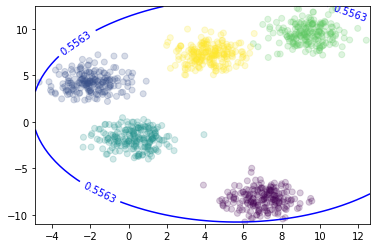

In [19]:
plot_contour(X, debug_model, colors)

In [20]:
print_report(debug_model, X)

c: 1, q: 0.001545861722197428
Support Vectors are 6, over 1000 candidates
Bounded Support Vectors are 0, over 1000 candidates
Mistakes 4/1000 = 0.4%


**How does the mistakes ratio change during optimization?**

At each round we collect data about the mistakes of the model over the whole dataset

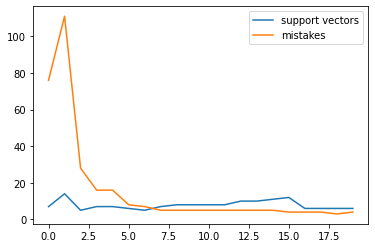

In [21]:
plt.plot([len(s['betas']) for s in debug_models], label='support vectors')
plt.plot(mistakes, label='mistakes')
plt.legend()
plt.show()

In [22]:
print(f'Average mistakes: {np.average(mistakes)}')
print(f'Std mistakes: {np.std(mistakes)}')

Average mistakes: 16.05
Std mistakes: 27.043437281529137


Usually the standard deviation is very high, probabily keeping track of the best model so far is a good idea.

How can we evaluate which model is the best in so far in production since we have limited view about the dataset?

### How does the best classifier found during the process work?

In [23]:
best_mistakes = min(mistakes)
best_mistakes_index = mistakes.index(best_mistakes)

print(f'Best mistakes {best_mistakes}/{len(X)} = {best_mistakes/len(X)*100}% at round {best_mistakes_index}/{number_of_rounds}')

Best mistakes 3/1000 = 0.3% at round 18/20


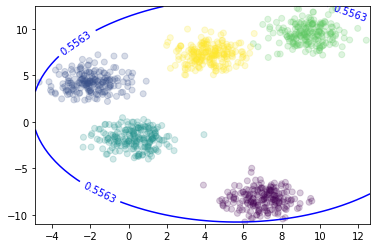

c: 1, q: 0.001545861722197428
Support Vectors are 6, over 1000 candidates
Bounded Support Vectors are 0, over 1000 candidates
Mistakes 3/1000 = 0.3%


In [24]:
plot_contour(X, debug_sk_models[best_mistakes_index], colors)
print_report(debug_sk_models[best_mistakes_index], X)

## Federated Learning simulation with multiple pass on data

Does seing the data multiple times reduce mistakes? It's a sort of overfit
So at line 17, instead of taking the following slice of data, we sample the client's data randomly at each iteration.

It can happen that the same data is seen multiple times.

In [25]:
number_of_rounds_sampling = 70

server_model_sampling = init_server_model()

# Metrics
debug_sk_models_sampling = []
debug_models_sampling = []
mistakes_sampling = []

client_updates = []

points_per_round_sampling = points_per_round

def client_worker_sampling(client, round_ix):
    dataset = k[client]
    # Randomly sample the client data
    random_batch = np.random.choice(dataset.shape[0], points_per_round_sampling) 
    dataset = dataset[random_batch]
    
    update = client_compute_update(server_model_sampling, dataset)
    update = np.array(list(update))
    if update.size > 0:
        client_updates.append(update)

for r in tqdm(range(number_of_rounds_sampling)):
    client_updates = []
    #threads = []
    for client in range(clients):
        client_worker_sampling(client, r)
        #t = threading.Thread(target=client_worker_sampling, args=(client, r))
        #threads.append(t)
        #t.start()
        
    #for t in threads:
        #t.join()
        
    server_model_sampling, debug_model = global_combine(server_model, client_updates)
    mistakes_sampling.append(sum(debug_model.predict(X)))
    debug_models_sampling.append(server_model_sampling)
    debug_sk_models_sampling.append(debug_model)

  0%|          | 0/70 [00:00<?, ?it/s]

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x8ef22672
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 8
 AA' NZ     : 3.600e+01
 

   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x8b3d61c9
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 8
 AA' NZ     : 3.600e+01
 Factor NZ  : 4.500e+01
 Factor Ops : 2.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective           

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 23 columns and 23 nonzeros
Model fingerprint: 0xa7b75db9
Model has 276 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 23 columns, 23 nonzeros
Presolved model has 276 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 1.900e+02
 Factor NZ  : 2.100e+02
 Factor Ops : 2.870e

  16   1.14355196e-01  1.14355688e-01  3.73e-11 1.49e-12  1.66e-08     0s
  17   1.14355500e-01  1.14355549e-01  3.70e-12 1.82e-12  1.66e-09     0s
  18   1.14355531e-01  1.14355536e-01  3.67e-13 1.82e-12  1.66e-10     0s

Barrier solved model in 18 iterations and 0.04 seconds
Optimal objective 1.14355531e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=22.000) total time=   0.1s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows

   8   4.00937317e-01  1.42399061e+01  5.81e-03 1.38e-07  4.46e-01     0s
   9   2.83545345e-01  2.75480234e+00  5.75e-04 1.36e-08  5.89e-02     0s
  10   3.57360606e-01  9.18896883e-01  9.62e-05 2.28e-09  1.30e-02     0s
  11   4.03011819e-01  5.13731526e-01  9.53e-06 2.26e-10  2.53e-03     0s
  12   4.21016491e-01  4.47790886e-01  1.46e-06 3.47e-11  6.11e-04     0s
  13   4.33458853e-01  4.39216253e-01  2.08e-07 4.93e-12  1.31e-04     0s
  14   4.36924160e-01  4.37894847e-01  3.08e-08 7.30e-13  2.21e-05     0s
  15   4.37555346e-01  4.37668192e-01  3.43e-09 8.14e-14  2.57e-06     0s
  16   4.37624696e-01  4.37636047e-01  3.45e-10 8.10e-15  2.59e-07     0s
  17   4.37631626e-01  4.37632760e-01  3.45e-11 7.77e-16  2.58e-08     0s
  18   4.37632318e-01  4.37632432e-01  3.42e-12 1.11e-16  2.58e-09     0s
  19   4.37632387e-01  4.37632399e-01  3.39e-13 5.55e-17  2.58e-10     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 4.37632387e-01

[CV 1/2; 4/6] END c=1,


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.16169266e+05  4.59331734e+05  6.42e+03 1.28e+02  2.50e+05     0s
   1   6.24020801e+03  8.65388751e+04  1.03e+03 5.43e-02  4.29e+04     0s
   2  -2.42338169e+04  4.05372529e+04  1.81e+02 9.48e-03  8.18e+03     0s
   3  -7.87856397e+03  1.03022740e+04  2.61e+01 1.37e-03  1.42e+03     0s
   4  -1.98074925e+03  2.46752982e+03  4.76e+00 2.50e-04  2.85e+02     0s
   5  -5.15841764e+02  6.74159510e+02  1.24e+00 6.53e-05  7.83e+01     0s
   6  -6.92104501e+01  1.29865817e+02  2.61e-01 1.37e-05  1.74e+01     0s
   7   6.30868089e-01  3.34494436e+01  2.96e-02 1.56e-06  2.41e+00     0s
   8   8.23046395e-01  1.81163523e+01  2.94e-03 1.54e-07  4.81e-01     0s
   9   6.19561093e-01  3.04918907e+00  2.91e-04 1.53e-08  5.48e-02     0s
  10   6.12127910e-01  9.56902403e-01  3.23e-05 1.70e-09  7.58e-03     0s
  11   6.21652026e-01  6.85711301e-01  5.04e-06 2.65e-10  1

Model fingerprint: 0x58461aea
Model has 1035 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 45 columns, 45 nonzeros
Presolved model has 1035 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 21
 AA' NZ     : 2.310e+02
 Factor NZ  : 2.530e+02
 Factor Ops : 3.795e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.11907715e+08  4.12286414e+05  3.03e+04 3.23e-01  2.54e+05     0s
   1   1.71502935e+07  1.83844034e+04  4.64e+03 4.93e-02  3.92e+04     0s
   2   2.23152087e+06  1.44717132e+03  6.03e+02 6.42e-03  5.13e+03     0s
   3   2.31599290e+05  1.33470148e+02  6.26e+01 6.66e-04  5.36e+02     0s
   4   2.446376

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x1de76d77
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 13
 AA' NZ     : 9.100e+01
 Factor NZ  : 1.050e+02
 Factor Ops : 1.015e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.09485521e+07  4.59449285e+05  9.71e+03 1.72e-01  2.61e+05     0s
   1   3.21955031e+06  1.59221729e+04  1.47e+03 2.6

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xe8515c20
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 4
 AA' NZ     : 1.000e+01
 Factor NZ  : 1.500e+01
 Factor Ops : 5.500e+01 (less than 1 second per iteration)
 Threads    : 1

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0xf3229c45
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x0b343095
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 4
 AA' NZ     : 1.000e+01
 Factor NZ  : 1.500e+01
 Factor Ops : 5.500e+01 (le

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0x66fa75f7
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (le

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 11 columns and 11 nonzeros
Model fingerprint: 0xb04ab2fe
Model has 66 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 11 columns, 11 nonzeros
Presolved model has 66 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 10
 AA' NZ     : 5.500e+01
 Factor NZ  : 6.600e+01
 Factor Ops : 5.060e+0


Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xe8f3fa43
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 15
 AA' NZ     : 1.200e+

  19   3.09471963e-01  3.09471966e-01  2.31e-13 6.94e-18  8.73e-11     0s

Barrier solved model in 19 iterations and 0.05 seconds
Optimal objective 3.09471963e-01

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xb30a83c7
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+


[CV 1/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 2/6] START c=1, q=0.0004527288965142884................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xbf9d673b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
P

[CV 1/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf28bc000
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x60e8bc1c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (le

Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x495def2a
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual       

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective 3.09471959e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x0037c70d
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 3.06032814e-01

[CV 2/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=2.000) total time=   0.0s
[CV 1/2; 2/6] START c=1, q=0.0004527288965142884................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xe0d14361
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  B


Barrier solved model in 16 iterations and 0.06 seconds
Optimal objective 4.84946924e-01

[CV 1/2; 3/6] END c=1, q=0.006722539525329108; zeros_scorer: (test=1.000) total time=   0.1s
[CV 2/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x3887e91d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.15792019e-01

[CV 2/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 5/6] START c=1, q=0.008326950111858656.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x41732e2d
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [6e-02, 4e+00]
  B

Optimal objective 2.74142152e-01

[CV 1/2; 6/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x97f8f06c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+0


Barrier solved model in 19 iterations and 0.03 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x759f2ff3
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objecti

  18   3.09471891e-01  3.09472020e-01  4.35e-12 1.07e-14  3.79e-09     0s
  19   3.09471957e-01  3.09471970e-01  4.35e-13 6.03e-16  3.79e-10     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 3.09471957e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xbce562ca
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0xdd0deda8
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+02
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.97114950e+04  1.32289505e+05  1.04e+04 6.40e+01  2.47e+05     0s
   1   2.05716215e+04  1.72427141e+04  1.68e+03 7.53e-02  4.09e+04     0s
   2  -4.59389152e+03  8.6371433

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x5a4647f9
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 15
 AA' NZ     : 1.200e+02
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.30775610e+03  2.08308756e+05  1.33e+04 6.40e+01  2.47e+05     0s
   1  -3.31792598e+04  5.52511078e+04  1.42e+03 4.32e-02  2.92e+04     0s
   2  -3.54707684e+04  3.8159795

Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xd8ad4fee
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         

   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x3218c623
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.56

   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xe2c5c549
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [6e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.48197801e+05  2.50698801e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -1.42465686e

   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xbda9b8db
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.52902076e+05  1.61903076e+05  2.25e+03 4.00e+00  2.49e+05     0s
   1  -1.30604434e

Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 15
 AA' NZ     : 1.200e+02
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.16139548e+05  1.27861452e+05  1.23e+04 6.40e+01  2.46e+05     0s
   1   2.12065777e+04  5.26691956e+03  1.33e+03 4.48e-02  2.69e+04     0s
   2  -1.17751322e+03  4.33859783e+03  1.55e+02 5.24e-03  3.33e+03     0s
   3  -2.36039825e+03  2.80167876e+03  1.92e+01 6.47e-04  5.07e+02     0s
   4  -8.51265743e+02  9.69347023e+02  3.83e+00

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 15
 AA' NZ     : 1.200e+02
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.72739281e+04  1.57727072e+05  1.35e+04 6.40e+01  2.47e+05     0s
   1  -3.29778103e+04  5.59427884e+04  1.50e+03 6.56e-02  3.03e+04     0s
   2  -3.66299738e+04  3.94029562e+04  1.70e+02 7.44e-03  4.98e+03     0s
   3  -9.65053647e+03  1.01206379e+04  2.41e+01 1.06e-03  8.73e+02     0s
   4  -2.73092994e+03  2.88622081e+03  5.85e+00 2.57e-04  2.40e+02     0s
   5  -5.9636

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xb410bf33
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.12564071e+05  3.17696570e+05  5.13e+03 1.00e+00  3.22e+05     0s
   1  -7.96449972e+03  9.23775184e+03  8.68e+02 5.78e-02  5.46e+04     0s
   2   1.35634309e-02  5.81049083e+02  

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x3887e91d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.21981535e+05  2.26982535e+05  3.06e+03 1.00e+00  2.48e+05     0s
   1  -3.56283913e+03  4.78077735e+03  5.32e+02 4.36e-04  4.36e+04     0s
   2  -2.52425834e+02  7.58932793e+02  

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xef73682f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [6e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.43580920e+05  2.47081920e+05  3.50e+03 1.00e+00  2.50e+05     0s
   1  -1.48399199e+04  1.57971309e+04  4.41e+02 2.75e-07  3.23e+04     0s
   2  -3.85748838e+02  1.01606014e+03  

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x97f8f06c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.59176578e+05  1.69177578e+05  2.50e+03 4.00e+00  2.51e+05     0s
   1  -1.86096148e+04  2.02368192e+04  3.41e+02 1.49e-03  3.80e+04     0s
   2  -4.66588809e+03  5.11820774e+03  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   5   5.31121017e-01  1.24885423e+02  6.06e-02 2.64e-07  1.93e+01     0s
   6   3.26011655e-01  1.71367527e+01  6.01e-03 2.61e-08  2.15e+00     0s
   7   3.05083101e-01  2.01273641e+00  6.00e-04 2.61e-09  2.14e-01     0s
   8   3.04259838e-01  4.93214405e-01  6.06e-05 2.64e-10  2.37e-02     0s
   9   3.05838866e-01  3.28696056e-01  6.32e-06 2.75e-11  2.86e-03     0s
  10   3.06023084e-01  3.08680937e-01  7.23e-07 3.15e-12  3.33e-04     0s
  11   3.06031669e-01  3.06370727e-01  9.14e-08 3.98e-13  4.24e-05     0s
  12   3.06032825e-01  3.06068641e-01  9.56e-09 4.16e-14  4.48e-06     0s
  13   3.06032817e-01  3.06036394e-01  9.47e-10 4.11e-15  4.48e-07     0s
  14   3.06032814e-01  3.06033172e-01  9.47e-11 3.33e-16  4.48e-08     0s
  15   3.06032814e-01  3.06032849e-01  9.39e-12 0.00e+00  4.48e-09     0s
  16   3.06032814e-01  3.06032817e-01  9.30e-13 2.78e-17  4.48e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 3.06032814e-01

[CV 2/2; 1/6] END c=1,

   5   5.11457504e-01  6.59777987e+01  3.62e-02 5.08e-11  1.13e+01     0s
   6   4.84965947e-01  7.05790552e+00  3.60e-03 5.04e-12  1.10e+00     0s
   7   4.82505375e-01  1.15808021e+00  3.63e-04 5.09e-13  1.13e-01     0s
   8   4.82507921e-01  5.53047531e-01  3.64e-05 5.11e-14  1.18e-02     0s
   9   4.83013210e-01  4.91962924e-01  3.68e-06 5.16e-15  1.49e-03     0s
  10   4.83851829e-01  4.85134394e-01  3.70e-07 5.00e-16  2.14e-04     0s
  11   4.84135441e-01  4.84321379e-01  3.68e-08 4.86e-17  3.10e-05     0s
  12   4.84203997e-01  4.84230612e-01  3.64e-09 6.94e-18  4.44e-06     0s
  13   4.84218975e-01  4.84222080e-01  3.61e-10 0.00e+00  5.18e-07     0s
  14   4.84221078e-01  4.84221384e-01  3.58e-11 0.00e+00  5.10e-08     0s
  15   4.84221288e-01  4.84221319e-01  3.54e-12 0.00e+00  5.08e-09     0s
  16   4.84221309e-01  4.84221312e-01  3.51e-13 6.94e-18  5.08e-10     0s

Barrier solved model in 16 iterations and 0.03 seconds
Optimal objective 4.84221309e-01

[CV 1/2; 3/6] END c=1,

   5   7.14024304e-01  1.15303923e+02  6.25e-02 4.34e-08  1.58e+01     0s
   6   6.19673065e-01  1.29004308e+01  6.20e-03 4.30e-09  1.55e+00     0s
   7   6.11671842e-01  1.91449315e+00  6.36e-04 4.41e-10  1.63e-01     0s
   8   6.14764661e-01  7.67379160e-01  6.48e-05 4.49e-11  1.91e-02     0s
   9   6.15566095e-01  6.31655841e-01  6.46e-06 4.48e-12  2.01e-03     0s
  10   6.15735107e-01  6.17664889e-01  6.46e-07 4.48e-13  2.41e-04     0s
  11   6.15789362e-01  6.16012376e-01  6.40e-08 4.44e-14  2.79e-05     0s
  12   6.15791996e-01  6.15814551e-01  6.34e-09 4.39e-15  2.82e-06     0s
  13   6.15792020e-01  6.15794270e-01  6.29e-10 4.44e-16  2.81e-07     0s
  14   6.15792019e-01  6.15792244e-01  6.23e-11 5.55e-17  2.81e-08     0s
  15   6.15792019e-01  6.15792042e-01  6.23e-12 5.55e-17  2.81e-09     0s
  16   6.15792019e-01  6.15792022e-01  6.23e-13 5.55e-17  2.81e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.15792019e-01

[CV 2/2; 4/6] END c=1,

   6   2.66708229e-01  6.64380414e+00  3.55e-03 2.07e-10  1.07e+00     0s
   7   2.64344379e-01  9.35887786e-01  3.63e-04 2.12e-11  1.12e-01     0s
   8   2.65597163e-01  3.40705992e-01  3.62e-05 2.12e-12  1.25e-02     0s
   9   2.69823813e-01  2.81282612e-01  3.91e-06 2.28e-13  1.91e-03     0s
  10   2.73652140e-01  2.74864124e-01  3.87e-07 2.26e-14  2.02e-04     0s
  11   2.74093222e-01  2.74214325e-01  3.84e-08 2.28e-15  2.02e-05     0s
  12   2.74137261e-01  2.74149370e-01  3.81e-09 1.67e-16  2.02e-06     0s
  13   2.74141664e-01  2.74142875e-01  3.77e-10 5.55e-17  2.02e-07     0s
  14   2.74142104e-01  2.74142226e-01  3.74e-11 0.00e+00  2.02e-08     0s
  15   2.74142149e-01  2.74142161e-01  3.74e-12 0.00e+00  2.02e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 2.74142149e-01

[CV 1/2; 6/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 6/6] START c=1, q=0.001545861722197428..............................

   9   2.31321199e+00  1.57358745e+00  6.15e-04 1.51e-07  6.78e-02     0s
  10   5.12553445e-01  6.31798137e-01  6.10e-05 1.49e-08  1.22e-02     0s
  11   3.34706631e-01  3.62978543e-01  1.10e-05 2.69e-09  2.19e-03     0s
  12   3.09272802e-01  3.16218315e-01  1.18e-06 2.89e-10  3.48e-04     0s
  13   3.09131518e-01  3.10361475e-01  1.46e-07 3.56e-11  5.38e-05     0s
  14   3.09433441e-01  3.09571061e-01  1.55e-08 3.79e-12  5.92e-06     0s
  15   3.09468115e-01  3.09481909e-01  1.55e-09 9.37e-13  5.94e-07     0s
  16   3.09471580e-01  3.09472959e-01  1.55e-10 3.80e-14  5.94e-08     0s
  17   3.09471926e-01  3.09472064e-01  1.55e-11 7.44e-13  5.94e-09     0s
  18   3.09471961e-01  3.09471975e-01  1.55e-12 2.27e-13  5.94e-10     0s
  19   3.09471964e-01  3.09471966e-01  1.54e-13 1.82e-12  5.94e-11     0s

Barrier solved model in 19 iterations and 0.03 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Cha

   8   2.74872688e-01  2.05774094e+01  4.90e-03 1.63e-07  6.51e-01     0s
   9   2.22942596e-01  2.50266311e+00  5.19e-04 1.72e-08  6.79e-02     0s
  10   2.43286813e-01  6.42828700e-01  6.96e-05 2.31e-09  1.18e-02     0s
  11   2.76234019e-01  3.61474378e-01  6.96e-06 2.31e-10  2.51e-03     0s
  12   2.97382762e-01  3.16458697e-01  1.00e-06 3.33e-11  5.62e-04     0s
  13   3.07538181e-01  3.10613782e-01  1.21e-07 4.02e-12  9.05e-05     0s
  14   3.09213766e-01  3.09625142e-01  1.51e-08 5.02e-13  1.21e-05     0s
  15   3.09445925e-01  3.09487610e-01  1.53e-09 5.07e-14  1.23e-06     0s
  16   3.09469361e-01  3.09473529e-01  1.53e-10 5.11e-15  1.23e-07     0s
  17   3.09471704e-01  3.09472121e-01  1.53e-11 5.55e-16  1.23e-08     0s
  18   3.09471939e-01  3.09471980e-01  1.53e-12 3.47e-17  1.23e-09     0s
  19   3.09471962e-01  3.09471966e-01  1.53e-13 1.39e-17  1.23e-10     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 3.09471962e-01

Changed value of param

   6   3.26011655e-01  1.71367527e+01  6.01e-03 2.61e-08  2.15e+00     0s
   7   3.05083101e-01  2.01273641e+00  6.00e-04 2.61e-09  2.14e-01     0s
   8   3.04259838e-01  4.93214405e-01  6.06e-05 2.64e-10  2.37e-02     0s
   9   3.05838866e-01  3.28696056e-01  6.32e-06 2.75e-11  2.86e-03     0s
  10   3.06023084e-01  3.08680937e-01  7.23e-07 3.15e-12  3.33e-04     0s
  11   3.06031669e-01  3.06370727e-01  9.14e-08 3.98e-13  4.24e-05     0s
  12   3.06032825e-01  3.06068641e-01  9.56e-09 4.16e-14  4.48e-06     0s
  13   3.06032817e-01  3.06036394e-01  9.47e-10 4.11e-15  4.48e-07     0s
  14   3.06032814e-01  3.06033172e-01  9.47e-11 3.33e-16  4.48e-08     0s
  15   3.06032814e-01  3.06032849e-01  9.39e-12 0.00e+00  4.48e-09     0s
  16   3.06032814e-01  3.06032817e-01  9.30e-13 2.78e-17  4.48e-10     0s

Barrier solved model in 16 iterations and 0.03 seconds
Optimal objective 3.06032814e-01

[CV 2/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=2.000) total time=   0.0s
[CV

   7   5.84647325e-01  1.39401817e+00  3.83e-04 2.41e-13  1.35e-01     0s
   8   5.97856810e-01  7.01137577e-01  3.87e-05 2.44e-14  1.72e-02     0s
   9   5.99416626e-01  6.10317460e-01  3.83e-06 2.39e-15  1.82e-03     0s
  10   5.99439486e-01  6.00524943e-01  3.80e-07 2.22e-16  1.81e-04     0s
  11   5.99439447e-01  5.99547947e-01  3.77e-08 5.55e-17  1.81e-05     0s
  12   5.99439420e-01  5.99450269e-01  3.73e-09 5.55e-17  1.81e-06     0s
  13   5.99439417e-01  5.99440502e-01  3.73e-10 0.00e+00  1.81e-07     0s
  14   5.99439417e-01  5.99439525e-01  3.73e-11 0.00e+00  1.81e-08     0s
  15   5.99439416e-01  5.99439427e-01  3.73e-12 0.00e+00  1.81e-09     0s

Barrier solved model in 15 iterations and 0.03 seconds
Optimal objective 5.99439416e-01

[CV 1/2; 3/6] END c=1, q=0.006722539525329108; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  

   9   6.15566095e-01  6.31655841e-01  6.46e-06 4.48e-12  2.01e-03     0s
  10   6.15735107e-01  6.17664889e-01  6.46e-07 4.48e-13  2.41e-04     0s
  11   6.15789362e-01  6.16012376e-01  6.40e-08 4.44e-14  2.79e-05     0s
  12   6.15791996e-01  6.15814551e-01  6.34e-09 4.39e-15  2.82e-06     0s
  13   6.15792020e-01  6.15794270e-01  6.29e-10 4.44e-16  2.81e-07     0s
  14   6.15792019e-01  6.15792244e-01  6.23e-11 5.55e-17  2.81e-08     0s
  15   6.15792019e-01  6.15792042e-01  6.23e-12 5.55e-17  2.81e-09     0s
  16   6.15792019e-01  6.15792022e-01  6.23e-13 5.55e-17  2.81e-10     0s

Barrier solved model in 16 iterations and 0.02 seconds
Optimal objective 6.15792019e-01

[CV 2/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=2.000) total time=   0.0s
[CV 1/2; 5/6] START c=1, q=0.008326950111858656.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev

  10   2.94847764e-01  2.95835818e-01  3.72e-07 2.11e-15  1.65e-04     0s
  11   2.94847688e-01  2.94946455e-01  3.69e-08 2.22e-16  1.65e-05     0s
  12   2.94847659e-01  2.94857536e-01  3.66e-09 1.11e-16  1.65e-06     0s
  13   2.94847656e-01  2.94848644e-01  3.66e-10 0.00e+00  1.65e-07     0s
  14   2.94847656e-01  2.94847755e-01  3.66e-11 0.00e+00  1.65e-08     0s
  15   2.94847656e-01  2.94847666e-01  3.66e-12 0.00e+00  1.65e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 2.94847656e-01

[CV 1/2; 6/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parame

  13   3.09830003e-01  3.09854229e-01  8.00e-08 4.32e-11  2.23e-05     0s
  14   3.09507254e-01  3.09510423e-01  7.93e-09 4.29e-12  2.24e-06     0s
  15   3.09475434e-01  3.09475810e-01  7.86e-10 1.24e-12  2.24e-07     0s
  16   3.09472312e-01  3.09472349e-01  7.86e-11 1.53e-13  2.24e-08     0s
  17   3.09471999e-01  3.09472003e-01  7.86e-12 1.82e-12  2.24e-09     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 3.09471999e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros

  15   3.09450640e-01  3.09483123e-01  1.04e-09 4.19e-14  1.02e-06     0s
  16   3.09469832e-01  3.09473081e-01  1.04e-10 4.11e-15  1.02e-07     0s
  17   3.09471752e-01  3.09472076e-01  1.04e-11 7.20e-15  1.02e-08     0s
  18   3.09471943e-01  3.09471976e-01  1.04e-12 1.64e-15  1.02e-09     0s
  19   3.09471963e-01  3.09471966e-01  1.04e-13 1.39e-17  1.02e-10     0s

Barrier solved model in 19 iterations and 0.02 seconds
Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros

  11   3.06388741e-01  3.13542409e-01  7.89e-07 6.97e-11  3.99e-04     0s
  12   3.08902797e-01  3.10056822e-01  1.09e-07 9.66e-12  6.44e-05     0s
  13   3.09410971e-01  3.09537554e-01  1.16e-08 1.03e-12  7.06e-06     0s
  14   3.09465861e-01  3.09478537e-01  1.17e-09 1.03e-13  7.07e-07     0s
  15   3.09471354e-01  3.09472622e-01  1.17e-10 1.03e-14  7.07e-08     0s
  16   3.09471904e-01  3.09472031e-01  1.17e-11 9.99e-16  7.07e-09     0s
  17   3.09471959e-01  3.09471971e-01  1.17e-12 4.47e-15  7.07e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 3.09471959e-01

[CV 2/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=9.000) total time=   0.0s
[CV 1/2; 2/6] START c=1, q=0.0004527288965142884................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter Numeri

   8   4.49584478e-01  1.15105405e+00  2.83e-04 5.66e-11  4.06e-02     0s
   9   4.49911771e-01  5.61294610e-01  3.71e-05 7.42e-12  6.33e-03     0s
  10   4.55842940e-01  4.75281470e-01  4.63e-06 9.25e-13  1.10e-03     0s
  11   4.60337162e-01  4.63909463e-01  6.85e-07 1.37e-13  2.01e-04     0s
  12   4.61911854e-01  4.62700591e-01  1.45e-07 2.90e-14  4.43e-05     0s
  13   4.62375820e-01  4.62456282e-01  1.44e-08 7.69e-15  4.52e-06     0s
  14   4.62423658e-01  4.62431685e-01  1.42e-09 2.78e-16  4.51e-07     0s
  15   4.62428432e-01  4.62429235e-01  1.41e-10 1.94e-14  4.51e-08     0s
  16   4.62428910e-01  4.62428990e-01  1.40e-11 1.39e-17  4.51e-09     0s
  17   4.62428958e-01  4.62428966e-01  1.40e-12 3.47e-18  4.51e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 4.62428958e-01

[CV 1/2; 3/6] END c=1, q=0.006722539525329108; zeros_scorer: (test=3.000) total time=   0.0s
[CV 2/2; 3/6] START c=1, q=0.006722539525329108..............................

   5   1.57449836e+00  1.69955624e+02  1.69e-01 2.61e-07  2.21e+01     0s
   6   7.24483839e-01  6.86780130e+01  1.67e-02 2.58e-08  4.29e+00     0s
   7   5.94214987e-01  8.21718108e+00  1.66e-03 2.56e-09  4.30e-01     0s
   8   5.88685780e-01  1.57047284e+00  1.99e-04 3.08e-10  5.47e-02     0s
   9   6.07704335e-01  7.47811652e-01  2.33e-05 3.59e-11  7.80e-03     0s
  10   6.11387268e-01  6.34458878e-01  3.24e-06 5.00e-12  1.28e-03     0s
  11   6.15126951e-01  6.20109379e-01  5.94e-07 9.17e-13  2.77e-04     0s
  12   6.17302386e-01  6.18116378e-01  7.32e-08 1.13e-13  4.53e-05     0s
  13   6.17762145e-01  6.17863768e-01  7.26e-09 1.12e-14  5.65e-06     0s
  14   6.17822963e-01  6.17833088e-01  7.19e-10 1.11e-15  5.63e-07     0s
  15   6.17829045e-01  6.17830057e-01  7.13e-11 1.11e-16  5.62e-08     0s
  16   6.17829653e-01  6.17829754e-01  7.07e-12 2.78e-17  5.62e-09     0s
  17   6.17829714e-01  6.17829724e-01  7.00e-13 6.94e-18  5.62e-10     0s

Barrier solved model in 17 iterations

   1   4.04478787e+05  8.19074318e+03  8.06e+02 4.03e-03  2.29e+04     0s
   2   5.33655893e+04  4.19306269e+02  1.05e+02 5.25e-04  3.02e+03     0s
   3   5.63694527e+03  2.94684938e+01  1.11e+01 5.53e-05  3.22e+02     0s
   4   6.88626926e+02  1.96649470e+01  1.37e+00 6.87e-06  4.13e+01     0s
   5   1.35433653e+02  8.55788278e+00  2.74e-01 1.37e-06  8.46e+00     0s
   6   1.83594101e+01  3.06736809e+00  3.74e-02 1.87e-07  1.28e+00     0s
   7   2.31769001e+00  1.49626228e+00  4.39e-03 2.20e-08  1.95e-01     0s
   8   4.10722565e-01  7.52097400e-01  4.35e-04 2.18e-09  3.83e-02     0s
   9   2.19108599e-01  2.81298584e-01  5.88e-05 2.94e-10  5.32e-03     0s
  10   2.12185726e-01  2.30065364e-01  5.83e-06 2.91e-11  1.17e-03     0s
  11   2.21837434e-01  2.24353502e-01  5.78e-07 2.89e-12  1.57e-04     0s
  12   2.23162393e-01  2.23412528e-01  5.73e-08 2.86e-13  1.56e-05     0s
  13   2.23294544e-01  2.23319536e-01  5.73e-09 2.86e-14  1.56e-06     0s
  14   2.23307747e-01  2.23310249e-01 

   0   1.21549099e+08  3.20900322e+05  6.60e+03 1.40e+00  4.50e+05     0s
   1   1.68413576e+07  2.48749717e+04  9.14e+02 1.94e-01  6.31e+04     0s
   2   1.96172864e+06  1.05053969e+04  1.07e+02 2.27e-02  7.70e+03     0s
   3   2.53069266e+05  4.11695024e+03  1.38e+01 2.94e-03  1.08e+03     0s
   4   4.06726445e+04  2.12386771e+03  2.23e+00 4.75e-04  2.06e+02     0s
   5   7.80708994e+03  8.48924347e+02  4.29e-01 9.12e-05  4.72e+01     0s
   6   1.53820006e+03  1.99969045e+02  8.50e-02 1.81e-05  9.72e+00     0s
   7   2.15691406e+02  3.13528098e+01  1.20e-02 2.55e-06  1.52e+00     0s
   8   2.77026529e+01  5.93346268e+00  1.57e-03 3.34e-07  2.66e-01     0s
   9   5.47061539e+00  1.73896559e+00  3.02e-04 6.42e-08  6.07e-02     0s
  10   1.14129863e+00  6.41076593e-01  5.00e-05 1.06e-08  1.30e-02     0s
  11   4.47193702e-01  3.73421865e-01  9.32e-06 1.98e-09  2.77e-03     0s
  12   3.40520780e-01  3.23202060e-01  2.54e-06 5.39e-10  8.06e-04     0s
  13   3.11844340e-01  3.11736853e-01 


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.52631753e+05  3.67632753e+05  1.36e+04 6.40e+01  2.52e+05     0s
   1  -3.74784442e+04  6.24182204e+04  1.56e+03 5.10e-02  3.16e+04     0s
   2  -3.81505504e+04  4.17451330e+04  2.14e+02 6.99e-03  5.52e+03     0s
   3  -1.36998074e+04  1.43272784e+04  3.12e+01 1.02e-03  1.12e+03     0s
   4  -3.81809347e+03  4.01931570e+03  7.30e+00 2.39e-04  2.99e+02     0s
   5  -9.88731575e+02  1.11405883e+03  2.87e+00 9.38e-05  1.17e+02     0s
   6  -1.17171535e+01  1.13276954e+02  4.50e-01 1.47e-05  2.04e+01     0s
   7   6.29080157e-01  7.58894769e+01  4.46e-02 1.46e-06  3.39e+00     0s
   8   2.90456623e-01  1.98500636e+01  4.42e-03 1.45e-07  5.52e-01     0s
   9   2.43839670e-01  2.39139424e+00  4.63e-04 1.51e-08  5.71e-02     0s
  10   2.57135669e-01  5.72676939e-01  5.12e-05 1.67e-09  8.33e-03     0s
  11   2.79080612e-01  3.41536791e-01  7.21e-06 2.36e-10  1

  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 8 columns, 8 nonzeros
Presolved model has 36 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 7
 AA' NZ     : 2.800e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.51403603e+05  3.59404603e+05  3.47e+03 6.40e+01  2.53e+05     0s
   1  -1.71781918e+04  4.53846294e+04  4.69e+02 1.55e-02  3.83e+04     0s
   2  -1.72588020e+04  2.11394394e+04  6.29e+01 2.07e-03  6.49e+03     0s
   3  -4.04223433e+03  4.68905663e+03  9.62e+00 3.18e-04  1.15e+03     0s
   4  -5.93840214e+02  7.34026936e+02  1.58e+00 5.23e-05  2.07e+02     0s
   5  -5.87059187e+01  1.09558940e+02  2.67e-01 8.79e-06  3.69e+01     0s
   6   5.95911992e-01  3.24416383e+01  2.64e-02 8.72e-07  5.03e+00     0s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x9e586d30
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.05s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 13
 AA' NZ     : 9.100e+0

Optimal objective 3.09471961e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x0edb4944
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free

  16   3.07584448e-01  3.07584450e-01  5.00e-13 0.00e+00  1.99e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 3.07584448e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x97f8f06c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   1.12609124e-01  1.12609134e-01  1.66e-12 1.88e-15  1.25e-09     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xd1166686
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e

  16   6.16995969e-01  6.16995972e-01  6.57e-13 5.55e-17  3.69e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.16995969e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x9d347739
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x4e46b2bf
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  17   3.09471955e-01  3.09471973e-01  1.48e-12 5.55e-17  1.08e-09     0s
  18   3.09471964e-01  3.09471966e-01  1.48e-13 5.55e-17  1.08e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xc99c7bdd
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00

  18   3.09471958e-01  3.09471968e-01  8.42e-13 1.14e-13  2.90e-10     0s

Barrier solved model in 18 iterations and 0.02 seconds
Optimal objective 3.09471958e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x22fac1a4
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved:

  15   2.97826001e-01  2.97826028e-01  7.55e-12 5.55e-17  3.43e-09     0s
  16   2.97826006e-01  2.97826009e-01  7.55e-13 1.11e-16  3.43e-10     0s

Barrier solved model in 16 iterations and 0.02 seconds
Optimal objective 2.97826006e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x97f8f06c
Model has 10 quadra

  15   1.12609111e-01  1.12609211e-01  1.68e-11 0.00e+00  1.25e-08     0s
  16   1.12609124e-01  1.12609134e-01  1.66e-12 1.88e-15  1.25e-09     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x42488899
Model has 10 quadr

  15   6.08831248e-01  6.08831277e-01  5.82e-12 5.55e-17  3.59e-09     0s
  16   6.08831262e-01  6.08831265e-01  5.82e-13 0.00e+00  3.59e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.08831262e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x9d347739
Model has 10 quadra

  14   6.36067718e-01  6.36067910e-01  5.54e-11 0.00e+00  2.39e-08     0s
  15   6.36067718e-01  6.36067737e-01  5.49e-12 3.05e-16  2.39e-09     0s
  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=2.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 

  15   3.09470576e-01  3.09472859e-01  2.17e-10 1.85e-14  1.44e-07     0s
  16   3.09471826e-01  3.09472054e-01  2.17e-11 5.55e-17  1.44e-08     0s
  17   3.09471951e-01  3.09471974e-01  2.15e-12 8.67e-19  1.44e-09     0s
  18   3.09471963e-01  3.09471966e-01  2.15e-13 2.46e-14  1.44e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x8bb8ce80
Model has 153 quadratic objective terms
Coe

  16   3.09471150e-01  3.09472339e-01  7.14e-11 1.57e-15  3.55e-08     0s
  17   3.09471883e-01  3.09472002e-01  7.08e-12 1.11e-14  3.55e-09     0s
  18   3.09471957e-01  3.09471969e-01  7.01e-13 2.27e-13  3.55e-10     0s

Barrier solved model in 18 iterations and 0.02 seconds
Optimal objective 3.09471957e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x0a37a86c
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  

  13   3.02863663e-01  3.02865547e-01  5.29e-10 0.00e+00  2.36e-07     0s
  14   3.02863663e-01  3.02863851e-01  5.29e-11 0.00e+00  2.36e-08     0s
  15   3.02863663e-01  3.02863682e-01  5.29e-12 0.00e+00  2.36e-09     0s
  16   3.02863663e-01  3.02863665e-01  5.29e-13 0.00e+00  2.36e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 3.02863663e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=2.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 

  13   1.12604303e-01  1.12625111e-01  2.27e-09 3.33e-16  2.09e-06     0s
  14   1.12608644e-01  1.12610724e-01  2.27e-10 1.11e-16  2.09e-07     0s
  15   1.12609078e-01  1.12609286e-01  2.25e-11 2.78e-17  2.09e-08     0s
  16   1.12609121e-01  1.12609142e-01  2.25e-12 0.00e+00  2.09e-09     0s
  17   1.12609125e-01  1.12609127e-01  2.23e-13 1.39e-17  2.09e-10     0s

Barrier solved model in 17 iterations and 0.02 seconds
Optimal objective 1.12609125e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=2.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optim

  12   6.05514179e-01  6.05527238e-01  5.68e-09 0.00e+00  1.63e-06     0s
  13   6.05514174e-01  6.05515480e-01  5.68e-10 0.00e+00  1.63e-07     0s
  14   6.05514174e-01  6.05514304e-01  5.68e-11 5.55e-17  1.63e-08     0s
  15   6.05514174e-01  6.05514187e-01  5.68e-12 0.00e+00  1.63e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 6.05514174e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 

  13   6.36164190e-01  6.36181049e-01  3.30e-09 9.27e-15  1.69e-06     0s
  14   6.36166740e-01  6.36168423e-01  3.27e-10 8.88e-16  1.68e-07     0s
  15   6.36166994e-01  6.36167162e-01  3.24e-11 2.05e-16  1.68e-08     0s
  16   6.36167019e-01  6.36167036e-01  3.24e-12 5.55e-17  1.68e-09     0s
  17   6.36167022e-01  6.36167023e-01  3.21e-13 1.87e-16  1.68e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 6.36167022e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimi

  13   1.14295618e-01  1.14406575e-01  2.86e-08 4.48e-13  6.37e-06     0s
  14   1.14349542e-01  1.14360638e-01  2.83e-09 4.44e-14  6.37e-07     0s
  15   1.14354935e-01  1.14356044e-01  2.81e-10 4.33e-15  6.37e-08     0s
  16   1.14355474e-01  1.14355585e-01  2.78e-11 2.71e-14  6.37e-09     0s
  17   1.14355528e-01  1.14355539e-01  2.78e-12 3.95e-17  6.37e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 1.14355528e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 19 columns and 19 nonzeros

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.47853609e+05  1.50354609e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -1.07390534e+04  1.16042280e+04  3.25e+02 2.03e-04  3.34e+04     0s
   2  -1.80878338e+02  8.24317279e+02  3.64e+01 2.27e-05  3.84e+03     0s
   3   1.38796104e+00  5.88823893e+02  3.60e+00 2.25e-06  4.51e+02     0s
   4   5.74529540e-01  3.83790265e+02  3.57e-01 2.23e-07  8.68e+01     0s
   5   3.03342360e-01  6.34611216e+01  3.54e-02 2.21e-08  1.09e+01     0s
   6   2.74645091e-01  6.62434090e+00  3.52e-03 2.20e-09  1.06e+00     0s
   7   2.72145182e-01  9.34203227e-01  3.58e-04 2.24e-10  1.10e-01     0s
   8   2.72589825e-01  3.44242743e-01  3.58e-05 2.24e-11  1.19e-02     0s
   9   2.72781943e-01  2.81294520e-01  3.64e-06 2.28e-12  1.42e-03     0s
  10   2.73629953e-01  2.74902809e-01  4.03e-07 2.52e-13  2.12e-04     0s
  11   2.74091034e-01  2.74219666e-01  3.99e-08 2.50e-14  2.

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.53513890e+05  1.70514890e+05  2.13e+03 8.00e+00  2.49e+05     0s
   1  -1.97032487e+04  2.18264096e+04  2.49e+02 2.07e-05  3.43e+04     0s
   2  -3.81242150e+03  4.22076116e+03  3.71e+01 3.09e-06  5.59e+03     0s
   3  -5.40559968e+01  2.02132074e+02  4.39e+00 3.66e-07  6.86e+02     0s
   4   2.58123444e+00  1.09253068e+02  4.35e-01 3.63e-08  8.09e+01     0s
   5   4.04075926e-01  6.99608884e+01  4.31e-02 3.59e-09  1.57e+01     0s
   6   1.07928603e-01  1.13575631e+01  4.27e-03 3.56e-10  1.94e+00     0s
   7   7.78948642e-02  1.22709354e+00  4.30e-04 3.58e-11  1.93e-01     0s
   8   7.54214273e-02  2.08821251e-01  4.63e-05 3.86e-12  2.23e-02     0s
   9   7.61180559e-02  9.61440764e-02  6.20e-06 5.16e-13  3.35e-03     0s
  10   7.77018076e-02  8.16342009e-02  1.16e-06 9.67e-14  6.57e-04     0s
  11   7.87254388e-02  7.91298921e-02  1.15

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.47370067e+05  2.49871067e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -1.42035765e+04  1.50777063e+04  3.10e+02 4.00e-06  3.22e+04     0s
   2  -3.73621132e+02  1.02648489e+03  3.71e+01 4.78e-07  3.96e+03     0s
   3  -6.78825793e-01  5.99827028e+02  3.67e+00 4.74e-08  4.64e+02     0s
   4   7.43368154e-01  3.92197434e+02  3.64e-01 4.69e-09  8.90e+01     0s
   5   5.14039841e-01  6.57305475e+01  3.61e-02 4.65e-10  1.13e+01     0s
   6   4.87685746e-01  7.03650007e+00  3.58e-03 4.62e-11  1.10e+00     0s
   7   4.85246394e-01  1.15892107e+00  3.61e-04 4.66e-12  1.12e-01     0s
   8   4.85207723e-01  5.54440375e-01  3.59e-05 4.63e-13  1.15e-02     0s
   9   4.85205336e-01  4.92641628e-01  3.66e-06 4.72e-14  1.24e-03     0s
  10   4.85324018e-01  4.86347140e-01  3.80e-07 4.90e-15  1.71e-04     0s
  11   4.85552089e-01  4.85678386e-01  3.93e-08 5.03e-16  2.11e-05     0s
  12   4.85597270e-01  4.85609946e-01 

   0  -2.69336591e+05  2.73337591e+05  2.98e+03 1.00e+00  2.56e+05     0s
   1  -3.24842010e+03  4.21886191e+03  4.68e+02 1.69e-04  4.07e+04     0s
   2  -1.14602372e+02  5.74181325e+02  5.32e+01 1.92e-05  4.72e+03     0s
   3   5.27817736e+00  3.83569126e+02  5.27e+00 1.90e-06  5.13e+02     0s
   4   1.16682873e+00  3.02118403e+02  5.22e-01 1.88e-07  8.56e+01     0s
   5   5.37335816e-01  7.84784261e+01  5.17e-02 1.87e-08  1.39e+01     0s
   6   4.73272635e-01  8.50168427e+00  5.13e-03 1.85e-09  1.35e+00     0s
   7   4.72442983e-01  1.39191244e+00  5.30e-04 1.91e-10  1.53e-01     0s
   8   4.78896825e-01  5.87353206e-01  5.33e-05 1.92e-11  1.81e-02     0s
   9   4.79506254e-01  4.92172175e-01  5.37e-06 1.94e-12  2.11e-03     0s
  10   4.79840423e-01  4.81443527e-01  5.40e-07 1.95e-13  2.67e-04     0s
  11   4.79882593e-01  4.80057408e-01  5.35e-08 1.92e-14  2.91e-05     0s
  12   4.79883463e-01  4.79900823e-01  5.30e-09 1.89e-15  2.89e-06     0s
  13   4.79883466e-01  4.79885201e-01 

   1  -2.89929529e+04  3.22235885e+04  3.73e+02 3.42e-04  3.18e+04     0s
   2  -1.12059693e+04  1.18072847e+04  5.14e+01 4.71e-05  5.26e+03     0s
   3  -9.97382971e+02  1.21646548e+03  8.42e+00 7.73e-06  8.79e+02     0s
   4  -6.62078396e+00  1.63491613e+02  8.51e-01 7.81e-07  9.77e+01     0s
   5   7.77943708e-01  1.18246011e+02  8.43e-02 7.74e-08  1.64e+01     0s
   6   3.57949547e-01  2.99365163e+01  8.36e-03 7.67e-09  2.63e+00     0s
   7   3.05047991e-01  3.36355975e+00  8.34e-04 7.65e-10  2.57e-01     0s
   8   3.03197784e-01  6.79607697e-01  9.49e-05 8.71e-11  3.15e-02     0s
   9   3.06823810e-01  3.60804568e-01  1.31e-05 1.20e-11  4.51e-03     0s
  10   3.07496772e-01  3.15080357e-01  1.81e-06 1.67e-12  6.33e-04     0s
  11   3.08920582e-01  3.10138444e-01  2.08e-07 1.91e-13  1.02e-04     0s
  12   3.09416711e-01  3.09541186e-01  2.07e-08 1.90e-14  1.04e-05     0s
  13   3.09466440e-01  3.09478889e-01  2.05e-09 1.89e-15  1.04e-06     0s
  14   3.09471412e-01  3.09472657e-01 

   4  -2.85057617e+02  5.70807713e+02  2.30e+00 7.92e-05  9.01e+01     0s
   5  -1.33673833e+02  2.04997776e+02  4.85e-01 1.67e-05  2.23e+01     0s
   6  -4.16620981e+01  7.10295076e+01  1.54e-01 5.29e-06  7.28e+00     0s
   7   1.09562191e+00  1.34195207e+01  1.75e-02 6.01e-07  1.13e+00     0s
   8   4.19408632e-01  6.35208292e+00  1.73e-03 5.96e-08  2.27e-01     0s
   9   2.71848828e-01  1.00975004e+00  1.72e-04 5.91e-09  2.41e-02     0s
  10   2.75672537e-01  4.01647435e-01  2.44e-05 8.39e-10  4.03e-03     0s
  11   2.99032417e-01  3.21696468e-01  2.76e-06 9.49e-11  7.18e-04     0s
  12   3.06399503e-01  3.11102195e-01  5.59e-07 1.92e-11  1.49e-04     0s
  13   3.09061156e-01  3.09679564e-01  6.83e-08 2.35e-12  1.96e-05     0s
  14   3.09430860e-01  3.09492775e-01  6.78e-09 2.33e-13  1.96e-06     0s
  15   3.09467854e-01  3.09474046e-01  6.72e-10 2.32e-14  1.96e-07     0s
  16   3.09471554e-01  3.09472173e-01  6.66e-11 2.28e-15  1.96e-08     0s
  17   3.09471924e-01  3.09471986e-01 

   0  -1.32472729e+05  1.34973729e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -8.95066902e+03  9.79335960e+03  3.31e+02 1.90e-06  3.36e+04     0s
   2  -1.03891117e+02  7.35040166e+02  3.53e+01 2.02e-07  3.67e+03     0s
   3   1.99485203e+00  5.77769979e+02  3.50e+00 2.01e-08  4.32e+02     0s
   4   5.72545600e-01  3.72935145e+02  3.46e-01 1.99e-09  8.36e+01     0s
   5   3.12888039e-01  6.06058481e+01  3.43e-02 1.97e-10  1.04e+01     0s
   6   2.86414164e-01  6.45422239e+00  3.46e-03 1.99e-11  1.03e+00     0s
   7   2.87862905e-01  1.01386228e+00  3.63e-04 2.08e-12  1.21e-01     0s
   8   2.96110390e-01  3.90561300e-01  3.79e-05 2.17e-13  1.57e-02     0s
   9   2.96995880e-01  3.06741649e-01  3.76e-06 2.15e-14  1.63e-03     0s
  10   2.97007372e-01  2.97980262e-01  3.73e-07 2.11e-15  1.62e-04     0s
  11   2.97007210e-01  2.97104475e-01  3.69e-08 2.22e-16  1.62e-05     0s
  12   2.97007181e-01  2.97016908e-01  3.66e-09 0.00e+00  1.62e-06     0s
  13   2.97007178e-01  2.97008151e-01 

   2  -1.17934994e+04  1.24822458e+04  4.91e+01 4.66e-05  6.64e+03     0s
   3  -1.08005809e+03  1.27291785e+03  8.74e+00 8.29e-06  1.21e+03     0s
   4  -3.52144538e+00  1.05834683e+02  8.87e-01 8.41e-07  1.32e+02     0s
   5   9.62553823e-01  7.85432167e+01  8.79e-02 8.34e-08  1.99e+01     0s
   6   2.04426555e-01  2.66338996e+01  8.71e-03 8.26e-09  3.66e+00     0s
   7   1.17239112e-01  2.94925067e+00  8.63e-04 8.19e-10  3.59e-01     0s
   8   1.09228035e-01  4.26996221e-01  9.33e-05 8.85e-11  3.99e-02     0s
   9   1.10541180e-01  1.59291050e-01  1.41e-05 1.34e-11  6.12e-03     0s
  10   1.12007050e-01  1.18900261e-01  1.66e-06 1.58e-12  8.64e-04     0s
  11   1.12446589e-01  1.13381329e-01  1.67e-07 1.58e-13  1.17e-04     0s
  12   1.12593909e-01  1.12693677e-01  1.67e-08 1.59e-14  1.25e-05     0s
  13   1.12607617e-01  1.12617598e-01  1.68e-09 1.55e-15  1.25e-06     0s
  14   1.12608975e-01  1.12609973e-01  1.68e-10 1.20e-15  1.25e-07     0s
  15   1.12609111e-01  1.12609211e-01 

   3  -3.65274571e-03  5.92177696e+02  3.69e+00 2.28e-09  4.60e+02     0s
   4   8.09222070e-01  3.88525703e+02  3.66e-01 2.26e-10  8.83e+01     0s
   5   6.03839722e-01  6.53913697e+01  3.62e-02 2.24e-11  1.12e+01     0s
   6   5.81855765e-01  7.26578554e+00  3.66e-03 2.26e-12  1.12e+00     0s
   7   5.89407646e-01  1.39912550e+00  3.82e-04 2.36e-13  1.35e-01     0s
   8   6.03050286e-01  7.06678709e-01  3.85e-05 2.38e-14  1.73e-02     0s
   9   6.04683688e-01  6.15639470e-01  3.82e-06 2.39e-15  1.83e-03     0s
  10   6.04708006e-01  6.05798692e-01  3.79e-07 2.22e-16  1.82e-04     0s
  11   6.04707982e-01  6.04817003e-01  3.75e-08 0.00e+00  1.82e-05     0s
  12   6.04707955e-01  6.04718857e-01  3.72e-09 0.00e+00  1.82e-06     0s
  13   6.04707952e-01  6.04709043e-01  3.72e-10 0.00e+00  1.82e-07     0s
  14   6.04707952e-01  6.04708061e-01  3.72e-11 5.55e-17  1.82e-08     0s
  15   6.04707952e-01  6.04707963e-01  3.72e-12 0.00e+00  1.82e-09     0s

Barrier solved model in 15 iterations

   5   7.23495765e-01  1.09665512e+02  5.63e-02 1.38e-08  1.49e+01     0s
   6   6.36718551e-01  1.21835245e+01  5.58e-03 1.36e-09  1.46e+00     0s
   7   6.30135466e-01  1.86755964e+00  5.74e-04 1.40e-10  1.55e-01     0s
   8   6.34881636e-01  7.82370774e-01  5.81e-05 1.42e-11  1.85e-02     0s
   9   6.35933430e-01  6.51344457e-01  5.76e-06 1.41e-12  1.93e-03     0s
  10   6.36043826e-01  6.37835558e-01  5.74e-07 1.40e-13  2.24e-04     0s
  11   6.36067199e-01  6.36259333e-01  5.69e-08 1.39e-14  2.40e-05     0s
  12   6.36067721e-01  6.36086867e-01  5.64e-09 1.33e-15  2.39e-06     0s
  13   6.36067719e-01  6.36069633e-01  5.59e-10 2.15e-16  2.39e-07     0s
  14   6.36067718e-01  6.36067910e-01  5.54e-11 0.00e+00  2.39e-08     0s
  15   6.36067718e-01  6.36067737e-01  5.49e-12 3.05e-16  2.39e-09     0s
  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1,

   7   2.95439243e-01  4.58725722e+00  1.06e-03 6.03e-09  3.10e-01     0s
   8   2.92725818e-01  8.24204100e-01  1.23e-04 7.00e-10  3.81e-02     0s
   9   3.00033901e-01  3.88902111e-01  1.98e-05 1.13e-10  6.36e-03     0s
  10   3.03950966e-01  3.17991606e-01  2.56e-06 1.45e-11  1.00e-03     0s
  11   3.08314480e-01  3.10406270e-01  2.81e-07 1.59e-12  1.50e-04     0s
  12   3.09355425e-01  3.09572569e-01  2.81e-08 1.59e-13  1.55e-05     0s
  13   3.09460295e-01  3.09482054e-01  2.81e-09 1.60e-14  1.56e-06     0s
  14   3.09470798e-01  3.09472974e-01  2.81e-10 1.60e-15  1.56e-07     0s
  15   3.09471848e-01  3.09472066e-01  2.81e-11 2.22e-16  1.56e-08     0s
  16   3.09471953e-01  3.09471975e-01  2.79e-12 5.55e-17  1.56e-09     0s
  17   3.09471964e-01  3.09471966e-01  2.76e-13 1.73e-18  1.56e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Cha

   7   9.58106550e-01  9.93462132e+00  1.02e-02 3.03e-07  5.59e-01     0s
   8   3.22751571e-01  3.38809876e+00  1.01e-03 3.01e-08  1.02e-01     0s
   9   2.51066419e-01  6.93943784e-01  1.39e-04 4.12e-09  1.36e-02     0s
  10   2.66940503e-01  3.81116706e-01  3.38e-05 1.00e-09  3.47e-03     0s
  11   2.94356758e-01  3.21892836e-01  6.66e-06 1.98e-10  8.30e-04     0s
  12   3.06695564e-01  3.11099117e-01  8.68e-07 2.58e-11  1.32e-04     0s
  13   3.09165908e-01  3.09652137e-01  8.60e-08 2.55e-12  1.46e-05     0s
  14   3.09441117e-01  3.09490270e-01  8.68e-09 2.58e-13  1.47e-06     0s
  15   3.09468880e-01  3.09473795e-01  8.60e-10 2.55e-14  1.47e-07     0s
  16   3.09471656e-01  3.09472148e-01  8.52e-11 2.53e-15  1.47e-08     0s
  17   3.09471934e-01  3.09471983e-01  8.44e-12 2.78e-16  1.47e-09     0s
  18   3.09471962e-01  3.09471967e-01  8.37e-13 1.43e-14  1.47e-10     0s

Barrier solved model in 18 iterations and 0.02 seconds
Optimal objective 3.09471962e-01

Changed value of param

   4   5.57191755e-01  3.80775051e+02  3.53e-01 4.96e-10  8.58e+01     0s
   5   3.02935873e-01  6.25131859e+01  3.50e-02 4.92e-11  1.07e+01     0s
   6   2.75693823e-01  6.53559815e+00  3.48e-03 4.89e-12  1.05e+00     0s
   7   2.73442859e-01  9.30345976e-01  3.55e-04 4.99e-13  1.10e-01     0s
   8   2.74090693e-01  3.45878503e-01  3.55e-05 5.00e-14  1.20e-02     0s
   9   2.74144226e-01  2.81350464e-01  3.52e-06 5.00e-15  1.20e-03     0s
  10   2.74142438e-01  2.74862923e-01  3.49e-07 5.55e-16  1.20e-04     0s
  11   2.74142182e-01  2.74214230e-01  3.46e-08 0.00e+00  1.20e-05     0s
  12   2.74142156e-01  2.74149361e-01  3.43e-09 0.00e+00  1.20e-06     0s
  13   2.74142154e-01  2.74142874e-01  3.40e-10 0.00e+00  1.20e-07     0s
  14   2.74142153e-01  2.74142225e-01  3.36e-11 0.00e+00  1.20e-08     0s
  15   2.74142153e-01  2.74142161e-01  3.36e-12 0.00e+00  1.20e-09     0s

Barrier solved model in 15 iterations and 0.02 seconds
Optimal objective 2.74142153e-01

[CV 1/2; 1/6] END c=1,

   6   2.04426555e-01  2.66338996e+01  8.71e-03 8.26e-09  3.66e+00     0s
   7   1.17239112e-01  2.94925067e+00  8.63e-04 8.19e-10  3.59e-01     0s
   8   1.09228035e-01  4.26996221e-01  9.33e-05 8.85e-11  3.99e-02     0s
   9   1.10541180e-01  1.59291050e-01  1.41e-05 1.34e-11  6.12e-03     0s
  10   1.12007050e-01  1.18900261e-01  1.66e-06 1.58e-12  8.64e-04     0s
  11   1.12446589e-01  1.13381329e-01  1.67e-07 1.58e-13  1.17e-04     0s
  12   1.12593909e-01  1.12693677e-01  1.67e-08 1.59e-14  1.25e-05     0s
  13   1.12607617e-01  1.12617598e-01  1.68e-09 1.55e-15  1.25e-06     0s
  14   1.12608975e-01  1.12609973e-01  1.68e-10 1.20e-15  1.25e-07     0s
  15   1.12609111e-01  1.12609211e-01  1.68e-11 0.00e+00  1.25e-08     0s
  16   1.12609124e-01  1.12609134e-01  1.66e-12 1.88e-15  1.25e-09     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=2.000) total time=   0.0s
[C

   7   4.85683087e-01  1.15978982e+00  3.62e-04 1.54e-13  1.12e-01     0s
   8   4.85623057e-01  5.55025493e-01  3.62e-05 1.54e-14  1.16e-02     0s
   9   4.85605241e-01  4.92544635e-01  3.59e-06 1.44e-15  1.16e-03     0s
  10   4.85602737e-01  4.86296671e-01  3.56e-07 1.11e-16  1.16e-04     0s
  11   4.85602482e-01  4.85671876e-01  3.52e-08 0.00e+00  1.16e-05     0s
  12   4.85602457e-01  4.85609396e-01  3.49e-09 5.55e-17  1.16e-06     0s
  13   4.85602454e-01  4.85603148e-01  3.46e-10 0.00e+00  1.16e-07     0s
  14   4.85602454e-01  4.85602523e-01  3.43e-11 0.00e+00  1.16e-08     0s
  15   4.85602454e-01  4.85602461e-01  3.40e-12 5.55e-17  1.16e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 4.85602454e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  

   9   6.35933430e-01  6.51344457e-01  5.76e-06 1.41e-12  1.93e-03     0s
  10   6.36043826e-01  6.37835558e-01  5.74e-07 1.40e-13  2.24e-04     0s
  11   6.36067199e-01  6.36259333e-01  5.69e-08 1.39e-14  2.40e-05     0s
  12   6.36067721e-01  6.36086867e-01  5.64e-09 1.33e-15  2.39e-06     0s
  13   6.36067719e-01  6.36069633e-01  5.59e-10 2.15e-16  2.39e-07     0s
  14   6.36067718e-01  6.36067910e-01  5.54e-11 0.00e+00  2.39e-08     0s
  15   6.36067718e-01  6.36067737e-01  5.49e-12 3.05e-16  2.39e-09     0s
  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev

  11   3.08688307e-01  3.10424300e-01  2.89e-07 3.51e-13  1.24e-04     0s
  12   3.09387261e-01  3.09584297e-01  3.02e-08 3.67e-14  1.41e-05     0s
  13   3.09463475e-01  3.09483268e-01  3.04e-09 3.68e-15  1.42e-06     0s
  14   3.09471116e-01  3.09473095e-01  3.01e-10 3.75e-16  1.42e-07     0s
  15   3.09471880e-01  3.09472078e-01  3.01e-11 4.16e-17  1.42e-08     0s
  16   3.09471956e-01  3.09471976e-01  2.98e-12 5.55e-17  1.42e-09     0s
  17   3.09471964e-01  3.09471966e-01  2.95e-13 5.55e-17  1.42e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9

  14   3.09420155e-01  3.09505959e-01  5.27e-09 3.42e-13  2.55e-06     0s
  15   3.09466789e-01  3.09475358e-01  5.22e-10 3.39e-14  2.55e-07     0s
  16   3.09471447e-01  3.09472304e-01  5.17e-11 3.34e-15  2.55e-08     0s
  17   3.09471913e-01  3.09471999e-01  5.12e-12 3.19e-16  2.55e-09     0s
  18   3.09471960e-01  3.09471968e-01  5.08e-13 2.26e-14  2.55e-10     0s

Barrier solved model in 18 iterations and 0.02 seconds
Optimal objective 3.09471960e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros

  12   1.79021387e-01  1.79045700e-01  6.73e-09 6.87e-16  2.43e-06     0s
  13   1.79031247e-01  1.79033678e-01  6.73e-10 6.25e-17  2.43e-07     0s
  14   1.79032233e-01  1.79032476e-01  6.73e-11 6.94e-18  2.43e-08     0s
  15   1.79032331e-01  1.79032356e-01  6.73e-12 5.55e-17  2.43e-09     0s
  16   1.79032341e-01  1.79032344e-01  6.73e-13 0.00e+00  2.43e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 1.79032341e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x90b1613f
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 16
 AA' NZ     : 1.360e+0

  16   3.09471907e-01  3.09472015e-01  1.61e-11 5.55e-17  6.79e-09     0s
  17   3.09471959e-01  3.09471970e-01  1.60e-12 5.55e-17  6.79e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 3.09471959e-01

[CV 2/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=8.000) total time=   0.0s
[CV 1/2; 2/6] START c=1, q=0.0004527288965142884................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 8 columns and 8 nonzeros
Model fingerprint: 0xfa7d991c
Model has 36 quadra

  11   4.41691606e-02  5.49778153e-02  1.69e-06 3.99e-11  6.83e-04     0s
  12   5.03112575e-02  5.15644450e-02  1.67e-07 3.96e-12  7.90e-05     0s
  13   5.09851129e-02  5.11105993e-02  1.67e-08 3.97e-13  7.91e-06     0s
  14   5.10526658e-02  5.10652116e-02  1.67e-09 3.97e-14  7.91e-07     0s
  15   5.10594198e-02  5.10606743e-02  1.67e-10 4.00e-15  7.91e-08     0s
  16   5.10600951e-02  5.10602206e-02  1.67e-11 3.57e-16  7.91e-09     0s
  17   5.10601627e-02  5.10601752e-02  1.67e-12 3.47e-17  7.91e-10     0s
  18   5.10601694e-02  5.10601707e-02  1.67e-13 2.07e-14  7.91e-11     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 5.10601694e-02

[CV 1/2; 3/6] END c=1, q=0.006722539525329108; zeros_scorer: (test=2.000) total time=   0.0s
[CV 2/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev

   6   8.07358717e-01  5.19094923e+01  1.60e-02 3.55e-10  4.02e+00     0s
   7   6.34274404e-01  7.70473856e+00  1.58e-03 3.52e-11  4.55e-01     0s
   8   6.14548580e-01  1.38397388e+00  1.67e-04 3.72e-12  4.84e-02     0s
   9   6.13863097e-01  7.16002646e-01  2.21e-05 4.90e-13  6.41e-03     0s
  10   6.14725664e-01  6.30850012e-01  3.17e-06 7.04e-14  1.01e-03     0s
  11   6.16693747e-01  6.19425673e-01  4.13e-07 9.16e-15  1.71e-04     0s
  12   6.17669403e-01  6.17997587e-01  4.10e-08 8.88e-16  2.06e-05     0s
  13   6.17812518e-01  6.17847186e-01  4.06e-09 1.11e-16  2.17e-06     0s
  14   6.17828002e-01  6.17831465e-01  4.06e-10 5.55e-17  2.17e-07     0s
  15   6.17829549e-01  6.17829895e-01  4.02e-11 0.00e+00  2.17e-08     0s
  16   6.17829704e-01  6.17829738e-01  3.99e-12 5.55e-17  2.17e-09     0s
  17   6.17829719e-01  6.17829722e-01  3.95e-13 6.94e-18  2.17e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 6.17829719e-01

[CV 2/2; 4/6] END c=1,

   2   6.97655745e+04  8.98649927e+03  1.54e+02 1.38e-02  5.66e+03     0s
   3   1.14344107e+04  9.42694932e+02  2.41e+01 2.16e-03  9.49e+02     0s
   4   1.67746527e+03  1.33537734e+02  3.52e+00 3.16e-04  1.47e+02     0s
   5   3.34996095e+02  3.86262327e+01  7.24e-01 6.49e-05  3.15e+01     0s
   6   6.57946055e+01  1.39149205e+01  1.53e-01 1.37e-05  7.27e+00     0s
   7   1.42747881e+01  2.61812301e+00  3.02e-02 2.71e-06  1.49e+00     0s
   8   1.52247971e+00  1.31610833e+00  3.00e-03 2.69e-07  2.06e-01     0s
   9   1.56221189e-01  5.70767528e-01  2.97e-04 2.66e-08  4.07e-02     0s
  10   2.22462471e-02  7.88677053e-02  3.41e-05 3.05e-09  4.71e-03     0s
  11   1.02270750e-02  2.29754341e-02  5.56e-06 4.99e-10  9.78e-04     0s
  12   1.04650243e-02  1.34385373e-02  6.02e-07 5.40e-11  2.05e-04     0s
  13   1.20258580e-02  1.23814579e-02  5.97e-08 5.35e-12  2.42e-05     0s
  14   1.22123064e-02  1.22478004e-02  5.92e-09 5.30e-13  2.41e-06     0s
  15   1.22309273e-02  1.22344759e-02 

   1   1.80380232e+07  4.62054171e+04  1.10e+03 1.09e+00  3.71e+04     0s
   2   2.77539641e+06  1.52251345e+04  1.70e+02 1.69e-01  6.15e+03     0s
   3   3.38085918e+05  4.45013016e+03  2.09e+01 2.07e-02  9.03e+02     0s
   4   4.88138271e+04  9.36835419e+02  3.04e+00 3.01e-03  1.51e+02     0s
   5   9.16087201e+03  2.05532262e+02  5.71e-01 5.66e-04  3.14e+01     0s
   6   1.25738171e+03  5.15949238e+01  7.93e-02 7.87e-05  5.76e+00     0s
   7   2.57000738e+02  1.56647232e+01  1.63e-02 1.62e-05  1.33e+00     0s
   8   5.43609467e+01  4.63477660e+00  3.42e-03 3.39e-06  3.17e-01     0s
   9   9.04647825e+00  1.28852969e+00  5.42e-04 5.38e-07  6.13e-02     0s
  10   1.24683456e+00  5.50097970e-01  5.86e-05 5.81e-08  1.08e-02     0s
  11   3.98031214e-01  3.45804550e-01  5.81e-06 5.76e-09  1.51e-03     0s
  12   3.24151925e-01  3.14687390e-01  1.06e-06 1.05e-09  2.70e-04     0s
  13   3.10744442e-01  3.10038136e-01  1.05e-07 1.04e-10  3.39e-05     0s
  14   3.09597798e-01  3.09528656e-01 

   1  -3.34147035e+04  5.55711807e+04  1.27e+03 5.64e-02  2.97e+04     0s
   2  -3.47121763e+04  3.76726398e+04  1.60e+02 7.09e-03  5.12e+03     0s
   3  -1.09201807e+04  1.14412369e+04  2.34e+01 1.04e-03  1.01e+03     0s
   4  -3.06427340e+03  3.23115421e+03  5.43e+00 2.40e-04  2.69e+02     0s
   5  -7.55460097e+02  8.61144954e+02  2.05e+00 9.08e-05  1.02e+02     0s
   6  -1.61139619e+01  1.07518832e+02  3.21e-01 1.42e-05  1.81e+01     0s
   7   1.80340805e-01  6.64497004e+01  3.18e-02 1.41e-06  3.20e+00     0s
   8   1.45538679e-01  1.44850622e+01  3.15e-03 1.39e-07  4.73e-01     0s
   9   1.37440053e-01  2.08809729e+00  3.96e-04 1.75e-08  6.15e-02     0s
  10   2.23853764e-01  6.13808716e-01  5.66e-05 2.51e-09  1.22e-02     0s
  11   2.72771323e-01  3.50135503e-01  5.69e-06 2.52e-10  2.42e-03     0s
  12   2.99724621e-01  3.14419460e-01  5.78e-07 2.56e-11  4.60e-04     0s
  13   3.07938412e-01  3.10168009e-01  7.34e-08 3.25e-12  6.97e-05     0s
  14   3.09303090e-01  3.09553673e-01 


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.59176578e+05  1.69177578e+05  2.50e+03 4.00e+00  2.51e+05     0s
   1  -1.86096148e+04  2.02368192e+04  3.41e+02 1.49e-03  3.80e+04     0s
   2  -4.66588809e+03  5.11820774e+03  5.38e+01 2.34e-04  6.43e+03     0s
   3  -6.68143788e+01  3.31043160e+02  6.17e+00 2.69e-05  7.71e+02     0s
   4   1.77389576e+00  2.24818442e+02  6.12e-01 2.66e-06  9.64e+01     0s
   5   5.31121017e-01  1.24885423e+02  6.06e-02 2.64e-07  1.93e+01     0s
   6   3.26011655e-01  1.71367527e+01  6.01e-03 2.61e-08  2.15e+00     0s
   7   3.05083101e-01  2.01273641e+00  6.00e-04 2.61e-09  2.14e-01     0s
   8   3.04259838e-01  4.93214405e-01  6.06e-05 2.64e-10  2.37e-02     0s
   9   3.05838866e-01  3.28696056e-01  6.32e-06 2.75e-11  2.86e-03     0s
  10   3.06023084e-01  3.08680937e-01  7.23e-07 3.15e-12  3.33e-04     0s
  11   3.06031669e-01  3.06370727e-01  9.14e-08 3.98e-13  4

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.44295067e+05  2.46796067e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -1.47455110e+04  1.55897906e+04  3.21e+02 1.79e-07  3.30e+04     0s
   2  -2.99138665e+02  9.41306677e+02  3.70e+01 2.07e-08  3.92e+03     0s
   3  -9.88004513e-02  5.92855786e+02  3.67e+00 2.05e-09  4.59e+02     0s
   4   8.14834183e-01  3.88067905e+02  3.63e-01 2.03e-10  8.81e+01     0s
   5   6.13424718e-01  6.50853425e+01  3.60e-02 2.01e-11  1.11e+01     0s
   6   5.91746774e-01  7.22801985e+00  3.63e-03 2.03e-12  1.11e+00     0s
   7   5.98946443e-01  1.39372520e+00  3.75e-04 2.09e-13  1.33e-01     0s
   8   6.12207544e-01  7.13830126e-01  3.77e-05 2.10e-14  1.69e-02     0s
   9   6.13748310e-01  6.24429760e-01  3.73e-06 2.11e-15  1.78e-03     0s
  10   6.13770068e-01  6.14833807e-01  3.70e-07 2.22e-16  1.77e-04     0s
  11   6.13770025e-01  6.13876356e-01  3.67e-08 5.55e-17  1.77e-05     0s
  12   6.13769999e-01  6.13780632e-01 

   1  -3.60209400e+03  4.81627246e+03  5.27e+02 3.65e-04  4.34e+04     0s
   2  -2.54021447e+02  7.60503386e+02  6.43e+01 4.46e-05  5.39e+03     0s
   3   6.31427626e+00  4.02721263e+02  6.37e+00 4.42e-06  5.69e+02     0s
   4   1.62247698e+00  3.38718155e+02  6.31e-01 4.38e-07  8.60e+01     0s
   5   7.14024304e-01  1.15303923e+02  6.25e-02 4.34e-08  1.58e+01     0s
   6   6.19673065e-01  1.29004308e+01  6.20e-03 4.30e-09  1.55e+00     0s
   7   6.11671842e-01  1.91449315e+00  6.36e-04 4.41e-10  1.63e-01     0s
   8   6.14764661e-01  7.67379160e-01  6.48e-05 4.49e-11  1.91e-02     0s
   9   6.15566095e-01  6.31655841e-01  6.46e-06 4.48e-12  2.01e-03     0s
  10   6.15735107e-01  6.17664889e-01  6.46e-07 4.48e-13  2.41e-04     0s
  11   6.15789362e-01  6.16012376e-01  6.40e-08 4.44e-14  2.79e-05     0s
  12   6.15791996e-01  6.15814551e-01  6.34e-09 4.39e-15  2.82e-06     0s
  13   6.15792020e-01  6.15794270e-01  6.29e-10 4.44e-16  2.81e-07     0s
  14   6.15792019e-01  6.15792244e-01 

   2  -1.21459912e+02  7.53635236e+02  3.54e+01 1.63e-07  3.69e+03     0s
   3   1.80391448e+00  5.79027031e+02  3.51e+00 1.61e-08  4.34e+02     0s
   4   5.81437820e-01  3.74203630e+02  3.48e-01 1.60e-09  8.40e+01     0s
   5   3.26306049e-01  6.09694352e+01  3.45e-02 1.58e-10  1.05e+01     0s
   6   3.00035740e-01  6.48439969e+00  3.47e-03 1.59e-11  1.03e+00     0s
   7   3.00322664e-01  1.01612678e+00  3.71e-04 1.70e-12  1.19e-01     0s
   8   3.06870604e-01  3.98577394e-01  3.85e-05 1.77e-13  1.53e-02     0s
   9   3.07578003e-01  3.16989176e-01  3.81e-06 1.75e-14  1.57e-03     0s
  10   3.07584695e-01  3.08524104e-01  3.78e-07 1.67e-15  1.57e-04     0s
  11   3.07584482e-01  3.07678406e-01  3.75e-08 1.11e-16  1.57e-05     0s
  12   3.07584452e-01  3.07593844e-01  3.71e-09 0.00e+00  1.57e-06     0s
  13   3.07584449e-01  3.07585388e-01  3.71e-10 0.00e+00  1.57e-07     0s
  14   3.07584449e-01  3.07584543e-01  3.71e-11 0.00e+00  1.57e-08     0s
  15   3.07584449e-01  3.07584458e-01 

   5   2.37776420e+02  2.18686984e+02  3.97e-01 6.43e-06  2.28e+01     0s
   6   2.27138880e+01  7.21290146e+01  7.77e-02 1.26e-06  5.75e+00     0s
   7   3.30702357e+00  2.15044020e+01  1.79e-02 2.90e-07  1.52e+00     0s
   8   1.92207783e+00  6.42092929e+00  4.53e-03 7.33e-08  4.23e-01     0s
   9   6.17139609e-01  2.06636371e+00  4.48e-04 7.27e-09  7.44e-02     0s
  10   3.22229031e-01  6.27543434e-01  4.44e-05 7.20e-10  1.07e-02     0s
  11   2.98988142e-01  3.56602920e-01  5.05e-06 8.19e-11  1.87e-03     0s
  12   3.06103007e-01  3.16064265e-01  5.44e-07 8.81e-12  3.11e-04     0s
  13   3.08846352e-01  3.10259291e-01  6.15e-08 9.97e-13  4.36e-05     0s
  14   3.09403453e-01  3.09557665e-01  6.68e-09 1.08e-13  4.76e-06     0s
  15   3.09465110e-01  3.09480544e-01  6.69e-10 1.08e-14  4.76e-07     0s
  16   3.09471279e-01  3.09472823e-01  6.69e-11 4.82e-13  4.76e-08     0s
  17   3.09471896e-01  3.09472051e-01  6.69e-12 1.67e-16  4.76e-09     0s
  18   3.09471958e-01  3.09471973e-01 

   4  -4.30218787e+03  4.50205839e+03  6.58e+00 2.37e-04  3.54e+02     0s
   5  -1.15087266e+03  1.27855677e+03  2.64e+00 9.50e-05  1.41e+02     0s
   6  -2.31447213e+01  1.30158815e+02  3.86e-01 1.39e-05  2.32e+01     0s
   7   1.77871374e-01  8.11797139e+01  3.82e-02 1.38e-06  3.93e+00     0s
   8   1.63174855e-01  2.00313898e+01  3.79e-03 1.36e-07  6.23e-01     0s
   9   1.45156034e-01  2.64621335e+00  4.54e-04 1.64e-08  7.42e-02     0s
  10   2.20740245e-01  7.07187499e-01  7.56e-05 2.72e-09  1.44e-02     0s
  11   2.68958792e-01  3.60120147e-01  7.98e-06 2.88e-10  2.69e-03     0s
  12   2.96950693e-01  3.16008503e-01  9.46e-07 3.41e-11  5.61e-04     0s
  13   3.07548684e-01  3.10323447e-01  1.12e-07 4.04e-12  8.17e-05     0s
  14   3.09264571e-01  3.09569573e-01  1.19e-08 4.27e-13  8.98e-06     0s
  15   3.09451184e-01  3.09481765e-01  1.19e-09 4.29e-14  9.00e-07     0s
  16   3.09469887e-01  3.09472945e-01  1.19e-10 4.29e-15  9.00e-08     0s
  17   3.09471757e-01  3.09472063e-01 

   2  -4.66588809e+03  5.11820774e+03  5.38e+01 2.34e-04  6.43e+03     0s
   3  -6.68143788e+01  3.31043160e+02  6.17e+00 2.69e-05  7.71e+02     0s
   4   1.77389576e+00  2.24818442e+02  6.12e-01 2.66e-06  9.64e+01     0s
   5   5.31121017e-01  1.24885423e+02  6.06e-02 2.64e-07  1.93e+01     0s
   6   3.26011655e-01  1.71367527e+01  6.01e-03 2.61e-08  2.15e+00     0s
   7   3.05083101e-01  2.01273641e+00  6.00e-04 2.61e-09  2.14e-01     0s
   8   3.04259838e-01  4.93214405e-01  6.06e-05 2.64e-10  2.37e-02     0s
   9   3.05838866e-01  3.28696056e-01  6.32e-06 2.75e-11  2.86e-03     0s
  10   3.06023084e-01  3.08680937e-01  7.23e-07 3.15e-12  3.33e-04     0s
  11   3.06031669e-01  3.06370727e-01  9.14e-08 3.98e-13  4.24e-05     0s
  12   3.06032825e-01  3.06068641e-01  9.56e-09 4.16e-14  4.48e-06     0s
  13   3.06032817e-01  3.06036394e-01  9.47e-10 4.11e-15  4.48e-07     0s
  14   3.06032814e-01  3.06033172e-01  9.47e-11 3.33e-16  4.48e-08     0s
  15   3.06032814e-01  3.06032849e-01 

   3   9.44675629e-02  5.91460339e+02  3.70e+00 2.54e-09  4.61e+02     0s
   4   8.04337382e-01  3.88618854e+02  3.67e-01 2.52e-10  8.84e+01     0s
   5   5.95842500e-01  6.55431810e+01  3.64e-02 2.49e-11  1.12e+01     0s
   6   5.73670675e-01  7.28575718e+00  3.68e-03 2.52e-12  1.12e+00     0s
   7   5.81741142e-01  1.40196992e+00  3.86e-04 2.65e-13  1.37e-01     0s
   8   5.96042722e-01  7.01323076e-01  3.90e-05 2.68e-14  1.76e-02     0s
   9   5.97818753e-01  6.09030148e-01  3.87e-06 2.61e-15  1.87e-03     0s
  10   5.97846948e-01  5.98962468e-01  3.84e-07 3.33e-16  1.86e-04     0s
  11   5.97846958e-01  5.97958455e-01  3.80e-08 5.55e-17  1.86e-05     0s
  12   5.97846931e-01  5.97858080e-01  3.77e-09 5.55e-17  1.86e-06     0s
  13   5.97846928e-01  5.97848043e-01  3.77e-10 0.00e+00  1.86e-07     0s
  14   5.97846928e-01  5.97847039e-01  3.77e-11 5.55e-17  1.86e-08     0s
  15   5.97846928e-01  5.97846939e-01  3.77e-12 0.00e+00  1.86e-09     0s

Barrier solved model in 15 iterations

   5   7.14024304e-01  1.15303923e+02  6.25e-02 4.34e-08  1.58e+01     0s
   6   6.19673065e-01  1.29004308e+01  6.20e-03 4.30e-09  1.55e+00     0s
   7   6.11671842e-01  1.91449315e+00  6.36e-04 4.41e-10  1.63e-01     0s
   8   6.14764661e-01  7.67379160e-01  6.48e-05 4.49e-11  1.91e-02     0s
   9   6.15566095e-01  6.31655841e-01  6.46e-06 4.48e-12  2.01e-03     0s
  10   6.15735107e-01  6.17664889e-01  6.46e-07 4.48e-13  2.41e-04     0s
  11   6.15789362e-01  6.16012376e-01  6.40e-08 4.44e-14  2.79e-05     0s
  12   6.15791996e-01  6.15814551e-01  6.34e-09 4.39e-15  2.82e-06     0s
  13   6.15792020e-01  6.15794270e-01  6.29e-10 4.44e-16  2.81e-07     0s
  14   6.15792019e-01  6.15792244e-01  6.23e-11 5.55e-17  2.81e-08     0s
  15   6.15792019e-01  6.15792042e-01  6.23e-12 5.55e-17  2.81e-09     0s
  16   6.15792019e-01  6.15792022e-01  6.23e-13 5.55e-17  2.81e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.15792019e-01

[CV 2/2; 4/6] END c=1,

   6   2.51919034e-01  9.79774755e+00  4.75e-03 8.98e-12  1.60e+00     0s
   7   2.58966089e-01  1.45788708e+00  5.23e-04 9.89e-13  2.00e-01     0s
   8   2.90788354e-01  4.68894072e-01  5.66e-05 1.07e-13  2.97e-02     0s
   9   2.96482789e-01  3.19126610e-01  5.98e-06 1.12e-14  3.77e-03     0s
  10   2.96748555e-01  2.99043688e-01  5.93e-07 1.11e-15  3.83e-04     0s
  11   2.96751288e-01  2.96980233e-01  5.88e-08 1.11e-16  3.82e-05     0s
  12   2.96751273e-01  2.96774162e-01  5.82e-09 0.00e+00  3.82e-06     0s
  13   2.96751269e-01  2.96753558e-01  5.82e-10 5.55e-17  3.82e-07     0s
  14   2.96751269e-01  2.96751498e-01  5.82e-11 0.00e+00  3.82e-08     0s
  15   2.96751269e-01  2.96751291e-01  5.82e-12 5.55e-17  3.82e-09     0s
  16   2.96751269e-01  2.96751271e-01  5.82e-13 5.55e-17  3.82e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 2.96751269e-01

[CV 1/2; 6/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV

   8   3.84689697e+01  4.38024485e+00  2.58e-03 7.46e-06  2.79e-01     0s
   9   5.10901679e+00  1.29958028e+00  3.29e-04 9.49e-07  5.37e-02     0s
  10   8.61037043e-01  5.17575122e-01  3.86e-05 1.12e-07  8.97e-03     0s
  11   3.81675133e-01  3.42760503e-01  5.68e-06 1.64e-08  1.56e-03     0s
  12   3.19909118e-01  3.14337956e-01  1.06e-06 3.05e-09  3.36e-04     0s
  13   3.10774929e-01  3.10052918e-01  1.55e-07 4.47e-10  5.19e-05     0s
  14   3.09608148e-01  3.09532517e-01  1.61e-08 4.66e-11  5.40e-06     0s
  15   3.09485354e-01  3.09478019e-01  1.60e-09 4.62e-12  5.40e-07     0s
  16   3.09473281e-01  3.09472570e-01  1.58e-10 4.58e-13  5.40e-08     0s
  17   3.09472094e-01  3.09472025e-01  1.57e-11 1.38e-13  5.40e-09     0s
  18   3.09471978e-01  3.09471971e-01  1.56e-12 1.82e-12  5.40e-10     0s

Barrier solved model in 18 iterations and 0.02 seconds
Optimal objective 3.09471978e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Cha

   9   1.42303441e-01  2.52073682e+00  4.77e-04 2.17e-08  7.06e-02     0s
  10   2.22284200e-01  7.05491216e-01  7.82e-05 3.55e-09  1.43e-02     0s
  11   2.70014227e-01  3.73913400e-01  1.05e-05 4.79e-10  3.06e-03     0s
  12   2.91963146e-01  3.18649137e-01  1.76e-06 7.99e-11  7.86e-04     0s
  13   3.07000428e-01  3.11069356e-01  1.74e-07 7.91e-12  1.20e-04     0s
  14   3.09094612e-01  3.09696783e-01  2.47e-08 1.12e-12  1.77e-05     0s
  15   3.09433794e-01  3.09494903e-01  2.50e-09 1.14e-13  1.80e-06     0s
  16   3.09468148e-01  3.09474259e-01  2.50e-10 1.14e-14  1.80e-07     0s
  17   3.09471583e-01  3.09472194e-01  2.50e-11 1.14e-15  1.80e-08     0s
  18   3.09471927e-01  3.09471988e-01  2.50e-12 1.25e-16  1.80e-09     0s
  19   3.09471961e-01  3.09471967e-01  2.50e-13 2.31e-15  1.80e-10     0s

Barrier solved model in 19 iterations and 0.03 seconds
Optimal objective 3.09471961e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Cha

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   4   5.76871345e+02  4.70404055e+02  3.74e+00 4.75e-04  1.30e+02     0s
   5  -1.62986972e+01  1.49021130e+02  4.34e-01 5.52e-05  1.98e+01     0s
   6  -1.97939190e+01  5.10640929e+01  8.36e-02 1.06e-05  4.59e+00     0s
   7  -3.23707665e+00  1.54660302e+01  2.23e-02 2.84e-06  1.31e+00     0s
   8   6.97978950e-01  5.28315037e+00  2.21e-03 2.81e-07  2.33e-01     0s
   9   2.97964179e-01  1.39558098e+00  2.19e-04 2.78e-08  3.59e-02     0s
  10   2.66336934e-01  4.57251786e-01  3.07e-05 3.91e-09  5.90e-03     0s
  11   2.82971825e-01  3.38353962e-01  7.09e-06 9.01e-10  1.69e-03     0s
  12   3.03924980e-01  3.14319789e-01  8.79e-07 1.12e-10  3.13e-04     0s
  13   3.08318296e-01  3.10169135e-01  1.49e-07 1.89e-11  5.57e-05     0s
  14   3.09353895e-01  3.09545652e-01  1.48e-08 1.88e-12  5.76e-06     0s
  15   3.09460158e-01  3.09479330e-01  1.47e-09 1.86e-13  5.76e-07     0s
  16   3.09470784e-01  3.09472701e-01  1.45e-10 1.84e-14  5.76e-08     0s
  17   3.09471847e-01  3.09472038e-01 

   0   3.44193227e+05  1.73807773e+05  4.05e+03 1.28e+02  2.28e+05     0s
   1   6.34399617e+04  7.91500161e+03  5.57e+02 1.19e-05  3.22e+04     0s
   2   2.74705738e+03  4.89780285e+03  5.92e+01 1.27e-06  3.98e+03     0s
   3  -6.64106145e+02  1.62511093e+03  7.19e+00 1.54e-07  6.12e+02     0s
   4  -2.61321381e+02  3.95130569e+02  8.78e-01 1.88e-08  1.04e+02     0s
   5  -5.81094232e+01  9.13823960e+01  1.61e-01 3.43e-09  2.22e+01     0s
   6  -3.53509104e+00  1.76617554e+01  2.94e-02 6.28e-10  4.47e+00     0s
   7   3.12191470e-01  7.68700032e+00  2.91e-03 6.23e-11  8.57e-01     0s
   8   1.62670652e-01  1.40698766e+00  2.89e-04 6.17e-12  1.10e-01     0s
   9   1.85844412e-01  4.23760357e-01  4.19e-05 8.95e-13  2.03e-02     0s
  10   1.96619170e-01  2.38874383e-01  5.20e-06 1.11e-13  3.58e-03     0s
  11   2.00371961e-01  2.07700862e-01  6.78e-07 1.45e-14  6.18e-04     0s
  12   2.02766752e-01  2.04087604e-01  1.15e-07 2.45e-15  1.11e-04     0s
  13   2.03501469e-01  2.03637132e-01 

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.50831521e+05  2.07169479e+05  4.13e+03 2.56e+02  2.12e+05     0s
   1   1.14738621e+05  2.40830846e+04  5.42e+02 1.94e-03  3.02e+04     0s
   2   1.59827392e+04  4.86250525e+03  8.12e+01 2.91e-04  4.81e+03     0s
   3   1.53263655e+03  1.08017355e+03  1.01e+01 3.63e-05  6.83e+02     0s
   4  -4.29105751e+01  3.80647359e+02  1.26e+00 4.53e-06  1.12e+02     0s
   5  -3.68404930e+01  9.80578668e+01  2.07e-01 7.42e-07  2.23e+01     0s
   6  -5.98736226e+00  2.28448026e+01  4.41e-02 1.58e-07  5.17e+00     0s
   7   9.29631303e-01  5.43737234e+00  4.75e-03 1.70e-08  8.05e-01     0s
   8   1.99273914e-01  2.01427429e+00  4.71e-04 1.69e-09  1.54e-01     0s
   9   1.09894544e-01  3.6

Model fingerprint: 0x8b95e4f4
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.15666357e+04  1.91567636e+05  4.06e+03 3.20e+01  2.45e+05     0s
   1  -6.87821655e+03  2.14144234e+04  4.48e+02 4.71e-06  2.98e+04     0s
   2  -7.76205950e+03  9.44375337e+03  4.80e+01 5.05e-07  4.10e+03     0s
   3  -1.92700233e+03  2.18684433e+03  5.67e+00 5.96e-08  6.39e+02     0s
   4  -3.52387022e+02 

   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0xa7862f6b
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 13 columns and 13 nonzeros
Model fingerprint: 0xacce22b8
Model has 91 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 13 columns, 13 nonzeros
Presolved model has 91 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 11
 AA' NZ     : 6.600e+01



Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 1.14355529e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0xbcdc346a
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 20 columns, 20 nonzeros
Presolved model has 210 quadratic objecti

  19   1.14355531e-01  1.14355535e-01  2.37e-13 8.30e-13  1.07e-10     0s

Barrier solved model in 19 iterations and 0.02 seconds
Optimal objective 1.14355531e-01

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xb30a83c7
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+


[CV 1/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 2/6] START c=1, q=0.0004527288965142884................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xbf9d673b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
P

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf28bc000
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor

   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x60e8bc1c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective               

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x495def2a
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.59026987e+04  1.23903699e+05  3.59e+03 

   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xf85578ac
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 15
 AA' NZ     : 1.200e+02
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
  

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf93ff0a1
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x2a93f4a6
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf25b6efa
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1



   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xfa95c50b
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                R

   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0xd2a44e33
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x300d8498
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 13
 AA' NZ     : 9.100e+01
 Factor NZ  : 1.050e+02
 Factor Ops : 1.015e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.47100279e+05  2.92900720e+05  8.87e+03 2.56e+02  2.33e+05     0s
   1   1.39392179e+05  1.25860464e+04  1.30e+03 4.77e-02  3.45e+04     0s
   2   1.35265934e+04  4.1614586

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xf68a8e25
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+0


Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xacf61cbf
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objecti


Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 2.74142150e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x97f8f06c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  

Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.1s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xdeb45f4d
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+0


Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 4.85602454e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x9d347739
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x9c66888d
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  B

Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xbb45fe80
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free


Barrier solved model in 19 iterations and 0.02 seconds
Optimal objective 3.09471962e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x94d4d377
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objecti

  16   2.79901842e-01  2.79901845e-01  6.86e-13 1.11e-16  3.77e-10     0s

Barrier solved model in 16 iterations and 0.03 seconds
Optimal objective 2.79901842e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=2.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x97f8f06c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   1.12609124e-01  1.12609134e-01  1.66e-12 1.88e-15  1.25e-09     0s

Barrier solved model in 16 iterations and 0.02 seconds
Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x5b8787c0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e

  16   4.89173394e-01  4.89173396e-01  5.20e-13 8.67e-19  2.45e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 4.89173394e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=2.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x9d347739
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=2.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x874711bd
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  17   3.09471958e-01  3.09471975e-01  1.20e-12 2.78e-17  1.13e-09     0s
  18   3.09471964e-01  3.09471966e-01  1.20e-13 1.14e-13  1.13e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x376e1ab4
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00

  17   3.09471933e-01  3.09471978e-01  3.95e-12 2.22e-16  1.42e-09     0s
  18   3.09471962e-01  3.09471966e-01  3.92e-13 2.78e-17  1.42e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471962e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x0b500ea0
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00

  15   2.74333891e-01  2.74334087e-01  4.34e-11 5.55e-17  2.46e-08     0s
  16   2.74333903e-01  2.74333923e-01  4.34e-12 5.55e-17  2.46e-09     0s
  17   2.74333905e-01  2.74333906e-01  4.30e-13 0.00e+00  2.46e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 2.74333905e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 

  13   1.12607617e-01  1.12617598e-01  1.68e-09 1.55e-15  1.25e-06     0s
  14   1.12608975e-01  1.12609973e-01  1.68e-10 1.20e-15  1.25e-07     0s
  15   1.12609111e-01  1.12609211e-01  1.68e-11 0.00e+00  1.25e-08     0s
  16   1.12609124e-01  1.12609134e-01  1.66e-12 1.88e-15  1.25e-09     0s

Barrier solved model in 16 iterations and 0.07 seconds
Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=2.000) total time=   0.1s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores,

  12   4.87443653e-01  4.87643626e-01  3.13e-08 3.55e-15  2.50e-05     0s
  13   4.87472629e-01  4.87492642e-01  3.13e-09 3.71e-16  2.51e-06     0s
  14   4.87475567e-01  4.87477568e-01  3.11e-10 1.11e-16  2.51e-07     0s
  15   4.87475861e-01  4.87476061e-01  3.08e-11 1.28e-15  2.51e-08     0s
  16   4.87475890e-01  4.87475910e-01  3.05e-12 8.67e-16  2.51e-09     0s
  17   4.87475893e-01  4.87475895e-01  3.05e-13 5.55e-17  2.51e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 4.87475893e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parame

  10   6.36043826e-01  6.37835558e-01  5.74e-07 1.40e-13  2.24e-04     0s
  11   6.36067199e-01  6.36259333e-01  5.69e-08 1.39e-14  2.40e-05     0s
  12   6.36067721e-01  6.36086867e-01  5.64e-09 1.33e-15  2.39e-06     0s
  13   6.36067719e-01  6.36069633e-01  5.59e-10 2.15e-16  2.39e-07     0s
  14   6.36067718e-01  6.36067910e-01  5.54e-11 0.00e+00  2.39e-08     0s
  15   6.36067718e-01  6.36067737e-01  5.49e-12 3.05e-16  2.39e-09     0s
  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter Numeri

  10   3.03313549e-01  3.67516039e-01  6.32e-06 7.25e-12  4.04e-03     0s
  11   3.06150527e-01  3.17339605e-01  1.04e-06 1.19e-12  7.04e-04     0s
  12   3.07494439e-01  3.10627425e-01  2.88e-07 3.31e-13  1.97e-04     0s
  13   3.09255609e-01  3.09760135e-01  3.07e-08 3.52e-14  3.17e-05     0s
  14   3.09450081e-01  3.09500974e-01  3.10e-09 3.55e-15  3.19e-06     0s
  15   3.09469776e-01  3.09474866e-01  3.07e-10 3.33e-16  3.19e-07     0s
  16   3.09471746e-01  3.09472255e-01  3.04e-11 4.16e-17  3.19e-08     0s
  17   3.09471943e-01  3.09471994e-01  3.01e-12 0.00e+00  3.19e-09     0s
  18   3.09471963e-01  3.09471968e-01  3.01e-13 1.73e-18  3.19e-10     0s

Barrier solved model in 18 iterations and 0.07 seconds
Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Mi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x5c620636
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 13
 AA' NZ     : 9.100e+0

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x628588af
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 15
 AA' NZ     : 1.200e+02
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e

  17   3.03980792e-01  3.03980793e-01  2.60e-13 0.00e+00  1.34e-10     0s

Barrier solved model in 17 iterations and 0.02 seconds
Optimal objective 3.03980792e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=2.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0xcb8d2531
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   1.12609121e-01  1.12609142e-01  2.25e-12 0.00e+00  2.09e-09     0s
  17   1.12609125e-01  1.12609127e-01  2.23e-13 1.39e-17  2.09e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 1.12609125e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=4.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x6f0649df
Model has 15 quadr

  14   6.08640500e-01  6.08641274e-01  1.51e-10 5.55e-17  7.74e-08     0s
  15   6.08640628e-01  6.08640706e-01  1.49e-11 0.00e+00  7.74e-09     0s
  16   6.08640641e-01  6.08640649e-01  1.48e-12 5.55e-17  7.74e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.08640641e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=2.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 

  13   6.36164190e-01  6.36181049e-01  3.30e-09 9.27e-15  1.69e-06     0s
  14   6.36166740e-01  6.36168423e-01  3.27e-10 8.88e-16  1.68e-07     0s
  15   6.36166994e-01  6.36167162e-01  3.24e-11 2.05e-16  1.68e-08     0s
  16   6.36167019e-01  6.36167036e-01  3.24e-12 5.55e-17  1.68e-09     0s
  17   6.36167022e-01  6.36167023e-01  3.21e-13 1.87e-16  1.68e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 6.36167022e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=4.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimi

  12   1.13264285e-01  1.15061839e-01  1.44e-07 5.68e-10  9.34e-05     0s
  13   1.14221561e-01  1.14466542e-01  1.72e-08 6.75e-11  1.27e-05     0s
  14   1.14342103e-01  1.14366629e-01  1.72e-09 6.76e-12  1.27e-06     0s
  15   1.14354191e-01  1.14356643e-01  1.72e-10 6.76e-13  1.27e-07     0s
  16   1.14355400e-01  1.14355645e-01  1.72e-11 6.90e-14  1.27e-08     0s
  17   1.14355521e-01  1.14355545e-01  1.72e-12 6.77e-15  1.27e-09     0s
  18   1.14355533e-01  1.14355535e-01  1.72e-13 1.22e-13  1.27e-10     0s

Barrier solved model in 18 iterations and 0.07 seconds
Optimal objective 1.14355533e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9

  13   1.14185498e-01  1.14439014e-01  4.28e-08 8.61e-13  8.80e-06     0s
  14   1.14338481e-01  1.14363862e-01  4.24e-09 8.53e-14  8.78e-07     0s
  15   1.14353822e-01  1.14356367e-01  4.20e-10 8.46e-15  8.78e-08     0s
  16   1.14355362e-01  1.14355617e-01  4.16e-11 8.33e-16  8.78e-09     0s
  17   1.14355517e-01  1.14355542e-01  4.12e-12 4.57e-13  8.78e-10     0s
  18   1.14355532e-01  1.14355535e-01  4.09e-13 9.09e-13  8.78e-11     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 1.14355532e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, usin

   9   3.02172674e-01  3.11889108e-01  3.77e-06 2.41e-14  1.62e-03     0s
  10   3.02181247e-01  3.03150911e-01  3.73e-07 2.33e-15  1.62e-04     0s
  11   3.02181052e-01  3.02277999e-01  3.70e-08 2.22e-16  1.62e-05     0s
  12   3.02181023e-01  3.02190717e-01  3.67e-09 0.00e+00  1.62e-06     0s
  13   3.02181020e-01  3.02181989e-01  3.67e-10 0.00e+00  1.62e-07     0s
  14   3.02181019e-01  3.02181116e-01  3.67e-11 0.00e+00  1.62e-08     0s
  15   3.02181019e-01  3.02181029e-01  3.67e-12 0.00e+00  1.62e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 3.02181019e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter Numeri

  11   1.12446589e-01  1.13381329e-01  1.67e-07 1.58e-13  1.17e-04     0s
  12   1.12593909e-01  1.12693677e-01  1.67e-08 1.59e-14  1.25e-05     0s
  13   1.12607617e-01  1.12617598e-01  1.68e-09 1.55e-15  1.25e-06     0s
  14   1.12608975e-01  1.12609973e-01  1.68e-10 1.20e-15  1.25e-07     0s
  15   1.12609111e-01  1.12609211e-01  1.68e-11 0.00e+00  1.25e-08     0s
  16   1.12609124e-01  1.12609134e-01  1.66e-12 1.88e-15  1.25e-09     0s

Barrier solved model in 16 iterations and 0.03 seconds
Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=2.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of param

  12   6.07928090e-01  6.07939121e-01  3.72e-09 0.00e+00  1.84e-06     0s
  13   6.07928087e-01  6.07929190e-01  3.72e-10 0.00e+00  1.84e-07     0s
  14   6.07928087e-01  6.07928197e-01  3.72e-11 5.55e-17  1.84e-08     0s
  15   6.07928087e-01  6.07928098e-01  3.72e-12 5.55e-17  1.84e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 6.07928087e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 

  14   6.36067718e-01  6.36067910e-01  5.54e-11 0.00e+00  2.39e-08     0s
  15   6.36067718e-01  6.36067737e-01  5.49e-12 3.05e-16  2.39e-09     0s
  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 

  16   3.09471944e-01  3.09471984e-01  4.67e-12 2.94e-15  2.88e-09     0s
  17   3.09471963e-01  3.09471967e-01  4.63e-13 5.39e-16  2.88e-10     0s

Barrier solved model in 17 iterations and 0.04 seconds
Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x621dd6c2
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00

  18   3.09471962e-01  3.09471967e-01  8.10e-13 2.78e-17  1.54e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471962e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x3f1c5594
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved:

  15   2.74142148e-01  2.74142161e-01  3.89e-12 0.00e+00  2.14e-09     0s
  16   2.74142153e-01  2.74142154e-01  3.89e-13 2.78e-17  2.14e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 2.74142153e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xbda9b8db
Model has 6 quadrat

  15   7.88457877e-02  7.88458281e-02  1.13e-11 0.00e+00  6.75e-09     0s
  16   7.88457985e-02  7.88458025e-02  1.12e-12 0.00e+00  6.75e-10     0s

Barrier solved model in 16 iterations and 0.03 seconds
Optimal objective 7.88457985e-02

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xdc988a91
Model has 6 quadra


Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 4.85602449e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xcec20a28
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-01, 4e+00]
  B


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 4.79883466e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf93ff0a1
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  B

Optimal objective 3.09471959e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x53d3c5bc
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 AA' NZ     : 1.360e+02
 Factor NZ  : 1.530e+02
 Factor Ops : 1.785e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.83105432e+07  3.05457473e+05  8.87e+03 7.43e-02  2.53e+05     0s
   1   1.10590743e+07  2.82786883e+04  1.25e+03 1.05e-02  3.68e+04     0s
   2   1.58232531e+06  1.14615476e+04  1.80e+02 1.51e-03  5.63e+03     0s
   3   2.20979323e+05  2.61483150e+03  2.52e+01 2.11e-04  8.55e+02     0s
   4   2.92166074e+04  7.54902724e+02  3.38e+00 2.83e-05  1.33e+02     0s
   5   4.54786083e+03  2.05518230e+02  5.34e-01 4.48e-06  2.48e+01     0s
   6   4.74135791e+02  5.99420513e+01  5.94e-02 4.98e-07  4.50e+00     0s
   7   7.22546208e+01  1.74476476e+01  9.71e-03 8.14e-08  1.02e+00     0s
   8   1.55680305e+01  5.15964453e+00  2.12e-03 1.77e-08  2.63e-01     0s
   9   3.95819675e+00  1.74375578e+00  5.02e-04 4.20e-09  7.36e-02     0s
  10   7.6

Presolve time: 0.00s
Presolved: 1 rows, 18 columns, 18 nonzeros
Presolved model has 171 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 16
 AA' NZ     : 1.360e+02
 Factor NZ  : 1.530e+02
 Factor Ops : 1.785e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.62796642e+04  1.59280664e+05  1.35e+04 3.20e+01  2.48e+05     0s
   1  -3.09277644e+04  4.66575631e+04  1.85e+03 5.54e-02  3.61e+04     0s
   2  -3.46877261e+04  3.68078085e+04  2.28e+02 6.82e-03  5.71e+03     0s
   3  -1.16213393e+04  1.20791836e+04  3.87e+01 1.16e-03  1.13e+03     0s
   4  -3.28755505e+03  3.48350917e+03  1.11e+01 3.32e-04  3.43e+02     0s
   5  -1.10309291e+02  2.57899936e+02  2.28e+00 6.82e-05  7.42e+01     0s
   6   3.63529865e-01  1.22812846e+02  2.26e-01 6.76e-06  9.75e+00     0s
   7   3.37963049e-01  5.96806892e+01  2.24e-02 6.70e-07  1

Model fingerprint: 0xbda9b8db
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.52902076e+05  1.61903076e+05  2.25e+03 4.00e+00  2.49e+05     0s
   1  -1.30604434e+04  1.43146822e+04  2.59e+02 1.19e-05  3.21e+04     0s
   2  -2.27631938e+03  2.62231394e+03  3.75e+01 1.72e-06  4.97e+03     0s
   3  -2.47010551e+01  2.38286542e+02  4.08e+00 1.87e-07  5.71e+02     0s
   4   1.35970057e+00  1

Model fingerprint: 0xdc988a91
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.47171116e+05  2.49672116e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -1.42017068e+04  1.50757637e+04  3.10e+02 4.28e-06  3.22e+04     0s
   2  -3.72652374e+02  1.02546003e+03  3.70e+01 5.11e-07  3.96e+03     0s
   3  -6.68682371e-01  5.99763490e+02  3.67e+00 5.07e-08  4.64e+02     0s
   4   7.42113481e-01  3

  Objective range  [1e+00, 1e+00]
  QObjective range [3e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.49317879e+05  2.53318879e+05  3.02e+03 1.00e+00  2.48e+05     0s
   1  -3.20969764e+03  4.24068119e+03  5.36e+02 1.73e-03  4.45e+04     0s
   2  -1.29031079e+02  5.84028901e+02  6.08e+01 1.96e-04  5.14e+03     0s
   3   5.71021824e+00  3.72437781e+02  6.02e+00 1.94e-05  5.53e+02     0s
   4   1.24009889e+00  3.00261363e+02  5.97e-01 1.92e-06  8.95e+01     0s
   5   5.30118612e-01  8.48544290e+01  5.91e-02 1.90e-07  1.52e+01     0s
  

  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.47853609e+05  1.50354609e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -1.07390534e+04  1.16042280e+04  3.25e+02 2.03e-04  3.34e+04     0s
   2  -1.80878338e+02  8.24317279e+02  3.64e+01 2.27e-05  3.84e+03     0s
   3   1.38796104e+00  5.88823893e+02  3.60e+00 2.25e-06  4.51e+02     0s
   4   5.74529540e-01  3.83790265e+02  3.57e-01 2.23e-07  8.68e+01     0s
   5   3.03342360e-01  6.34611216e+01  3.54e-02 2.21e-08  1.09e+01     0s
  

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+02
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.99819448e+07  1.42057227e+05  1.10e+04 1.81e-02  2.50e+05     0s
   1   1.21573406e+07  3.92175834e+04  1.49e+03 2.45e-03  3.57e+04     0s
   2   1.48635466e+06  1.84152155e+04  1.84e+02 3.02e-04  5.06e+03     0s
   3   2.03838812e+05  4.25800442e+03  2.54e+01 4.18e-05  7.97e+02     0s
   4   3.90681923e+04  8.22349114e+02  4.87e+00 8.01e-06  1.63e+02     0s
   5   5.57768736e+03  1.73354167e+02  7.00e-01 1.15e-06  2.81e+01     0s
   6   8.80326549e+02  5.47246608e+01  1.13e-01 1.86e-07  5.63e+00     0s
   7   1.51190552e+02  1.36734047e+01  1.95e-02 3.21e-08  1.13e+00     0s
   8   2.89892540e+01  3.67096237e+00  3.67e-03 6.04e-09  2.46e-01     0s
   9   3.61470788e+00  1.


Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+02
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.84991827e+04  2.07500183e+05  1.22e+04 3.20e+01  2.48e+05     0s
   1  -3.96948612e+04  5.12400391e+04  1.26e+03 4.21e-02  2.85e+04     0s
   2  -3.27974682e+04  3.44646422e+04  1.63e+02 5.44e-03  4.89e+03     0s
   3  -1.13812558e+04  1.17801675e+04  2.98e+01 9.96e-04  1.12e+03     0s
   4  -2.04440609e+03  2.23760101e+03  7.89e+00 2.64e-04  3.26e+02     0s
   5  -1.19179566e+01  1.63267240e+02  7.83e-01 2.62e-05  3.65e+01     0s
   6   5.66751335e-01  1.15411526e+02  7.76e-02 2.59e-06  6.10e+00     0s
   7   2.67196076e-01  2.97971476e+01  7.69e-03 2.57e-07  9.88e-01     0s
   8   2.24622376e-01  3.44966302e+00  8.11e-04 2.71e-08  1.02e-01     0s
   9   2.35787699e-01  7.65645308e-01  1.33e-0

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 8 columns, 8 nonzeros
Presolved model has 36 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 7
 AA' NZ     : 2.800e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.26558529e+05  1.96442471e+05  5.05e+03 6.40e+01  2.40e+05     0s
   1  -6.75288713e+03  4.90857833e+04  6.57e+02 7.45e-02  3.60e+04     0s
   2  -1.12712860e+04  1.83048337e+04  1.07e+02 1.21e-02  6.68e+03     0s
   3  -2.99580962e+03  3.88929328e+03  1.27e+01 1.44e-03  9.95e+02     0s
   4  -6.88628606e+02  8.48332564e+02  1.86e+00 2.10e-04  1.77e+02     0s
   5  -1.34448876e+02  1.83912081e+02  3.69e-01 4.19e-05  3.89e+01     0s
   6  -8.26339000e+00  3.61355539e+01  7.84e-02 8.89e-06  8.84e+00   

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x69b2aace
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.89081603e+05  2.66919397e+05  4.52e+03 2.56e+02  2.09e+05     0s
   1   1.59173732e+05  8.81993196e+03  6.56e+02 5.95e-07  

   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 8 columns and 8 nonzeros
Model fingerprint: 0x85a7d088
Model has 36 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [9e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 8 columns, 8 nonzeros
Presolved model has 36 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 7
 AA' NZ     : 2.800e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective               

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=7.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x77ed86a0
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Pre

  17   3.09472093e-01  3.09471996e-01  6.25e-12 7.28e-12  1.86e-09     0s
  18   3.09471978e-01  3.09471968e-01  6.19e-13 3.64e-12  1.86e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471978e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x6cce235a
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00

  18   3.09471929e-01  3.09471979e-01  4.20e-12 8.33e-17  1.50e-09     0s
  19   3.09471961e-01  3.09471966e-01  4.16e-13 1.42e-14  1.50e-10     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 3.09471961e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xe906db35
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00

  14   1.73238743e-01  1.73239205e-01  1.11e-10 1.14e-15  5.79e-08     0s
  15   1.73238947e-01  1.73238993e-01  1.11e-11 1.00e-15  5.79e-09     0s
  16   1.73238968e-01  1.73238972e-01  1.11e-12 2.78e-16  5.79e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 1.73238968e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 

  14   1.12608644e-01  1.12610724e-01  2.27e-10 1.11e-16  2.09e-07     0s
  15   1.12609078e-01  1.12609286e-01  2.25e-11 2.78e-17  2.09e-08     0s
  16   1.12609121e-01  1.12609142e-01  2.25e-12 0.00e+00  2.09e-09     0s
  17   1.12609125e-01  1.12609127e-01  2.23e-13 1.39e-17  2.09e-10     0s

Barrier solved model in 17 iterations and 0.04 seconds
Optimal objective 1.12609125e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=3.000) total time=   0.1s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores,

  12   4.25111195e-01  4.25172137e-01  1.97e-08 9.99e-16  7.63e-06     0s
  13   4.25130586e-01  4.25136679e-01  1.96e-09 1.11e-16  7.63e-07     0s
  14   4.25132524e-01  4.25133134e-01  1.96e-10 9.03e-20  7.63e-08     0s
  15   4.25132718e-01  4.25132779e-01  1.94e-11 8.97e-21  7.63e-09     0s
  16   4.25132738e-01  4.25132744e-01  1.92e-12 8.93e-22  7.63e-10     0s

Barrier solved model in 16 iterations and 0.02 seconds
Optimal objective 4.25132738e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimi

  11   6.36117566e-01  6.37015357e-01  1.95e-07 5.46e-13  8.99e-05     0s
  12   6.36146812e-01  6.36306076e-01  3.33e-08 9.31e-14  1.59e-05     0s
  13   6.36164190e-01  6.36181049e-01  3.30e-09 9.27e-15  1.69e-06     0s
  14   6.36166740e-01  6.36168423e-01  3.27e-10 8.88e-16  1.68e-07     0s
  15   6.36166994e-01  6.36167162e-01  3.24e-11 2.05e-16  1.68e-08     0s
  16   6.36167019e-01  6.36167036e-01  3.24e-12 5.55e-17  1.68e-09     0s
  17   6.36167022e-01  6.36167023e-01  3.21e-13 1.87e-16  1.68e-10     0s

Barrier solved model in 17 iterations and 0.02 seconds
Optimal objective 6.36167022e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter Numeri

  11   3.01809114e-01  3.13953857e-01  2.31e-06 1.45e-10  6.77e-04     0s
  12   3.08385442e-01  3.10193667e-01  2.76e-07 1.73e-11  1.01e-04     0s
  13   3.09362218e-01  3.09549207e-01  2.73e-08 1.71e-12  1.04e-05     0s
  14   3.09460993e-01  3.09479689e-01  2.71e-09 1.70e-13  1.04e-06     0s
  15   3.09470868e-01  3.09472737e-01  2.71e-10 1.70e-14  1.04e-07     0s
  16   3.09471855e-01  3.09472042e-01  2.71e-11 1.69e-15  1.04e-08     0s
  17   3.09471954e-01  3.09471973e-01  2.68e-12 5.20e-15  1.04e-09     0s
  18   3.09471964e-01  3.09471966e-01  2.68e-13 1.11e-16  1.04e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  11   6.36067199e-01  6.36259333e-01  5.69e-08 1.39e-14  2.40e-05     0s
  12   6.36067721e-01  6.36086867e-01  5.64e-09 1.33e-15  2.39e-06     0s
  13   6.36067719e-01  6.36069633e-01  5.59e-10 2.15e-16  2.39e-07     0s
  14   6.36067718e-01  6.36067910e-01  5.54e-11 0.00e+00  2.39e-08     0s
  15   6.36067718e-01  6.36067737e-01  5.49e-12 3.05e-16  2.39e-09     0s
  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parame

  13   3.09463963e-01  3.09483081e-01  2.32e-09 1.89e-15  1.37e-06     0s
  14   3.09471165e-01  3.09473076e-01  2.32e-10 2.22e-16  1.37e-07     0s
  15   3.09471885e-01  3.09472076e-01  2.30e-11 1.11e-16  1.37e-08     0s
  16   3.09471957e-01  3.09471976e-01  2.28e-12 5.55e-17  1.37e-09     0s
  17   3.09471964e-01  3.09471966e-01  2.25e-13 1.39e-17  1.37e-10     0s

Barrier solved model in 17 iterations and 0.07 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros

  13   3.09298526e-01  3.09615664e-01  3.07e-08 1.04e-12  9.43e-06     0s
  14   3.09454537e-01  3.09486411e-01  3.08e-09 1.05e-13  9.48e-07     0s
  15   3.09470222e-01  3.09473409e-01  3.08e-10 1.05e-14  9.48e-08     0s
  16   3.09471790e-01  3.09472109e-01  3.05e-11 4.00e-14  9.48e-09     0s
  17   3.09471947e-01  3.09471979e-01  3.03e-12 1.11e-16  9.48e-10     0s
  18   3.09471963e-01  3.09471966e-01  3.00e-13 5.68e-14  9.48e-11     0s

Barrier solved model in 18 iterations and 0.02 seconds
Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, usin

  11   2.74142183e-01  2.74214883e-01  3.08e-08 7.89e-12  1.21e-05     0s
  12   2.74142156e-01  2.74149426e-01  3.05e-09 7.82e-13  1.21e-06     0s
  13   2.74142154e-01  2.74142881e-01  3.05e-10 7.82e-14  1.21e-07     0s
  14   2.74142153e-01  2.74142226e-01  3.05e-11 7.77e-15  1.21e-08     0s
  15   2.74142153e-01  2.74142161e-01  3.05e-12 7.77e-16  1.21e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 2.74142153e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimi

  13   1.12607617e-01  1.12617598e-01  1.68e-09 1.55e-15  1.25e-06     0s
  14   1.12608975e-01  1.12609973e-01  1.68e-10 1.20e-15  1.25e-07     0s
  15   1.12609111e-01  1.12609211e-01  1.68e-11 0.00e+00  1.25e-08     0s
  16   1.12609124e-01  1.12609134e-01  1.66e-12 1.88e-15  1.25e-09     0s

Barrier solved model in 16 iterations and 0.06 seconds
Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.1s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores,

  14   4.85602454e-01  4.85602525e-01  3.07e-11 5.22e-15  1.19e-08     0s
  15   4.85602454e-01  4.85602461e-01  3.07e-12 5.55e-16  1.19e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 4.85602454e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x9d347739
Model has 10 quadra

  16   6.36067718e-01  6.36067720e-01  5.44e-13 0.00e+00  2.39e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x50df5ff5
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+0


Barrier solved model in 17 iterations and 0.07 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x8254dfc3
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objecti


Barrier solved model in 19 iterations and 0.02 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xa2b8a4b8
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objecti


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 2.74142153e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xbda9b8db
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  B


Barrier solved model in 16 iterations and 0.04 seconds
Optimal objective 7.88457985e-02

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xdc988a91
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xcec20a28
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Pres


[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf93ff0a1
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Pre

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0xaa8fad04
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 12
 AA' NZ     : 7.800e+01
 Factor NZ  : 9.100e+01
 Factor Ops : 8.190e+02 (less than 1 second per iteration)
 Threads

   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0xaf08003c
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+02
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective        

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xbda9b8db
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xdc988a91
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less

Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xcec20a28
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         

Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf93ff0a1
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 18 columns and 18 nonzeros
Model fingerprint: 0xe79b9f0f
Model has 171 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 18 columns, 18 nonzeros
Presolved model has 171 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 15
 AA' NZ     : 1.200e+0

  19   3.09471964e-01  3.09471965e-01  1.66e-13 1.14e-13  4.99e-11     0s

Barrier solved model in 19 iterations and 0.02 seconds
Optimal objective 3.09471964e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 18 columns and 18 nonzeros
Model fingerprint: 0xe188f100
Model has 171 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved:

  14   2.74142102e-01  2.74142231e-01  3.89e-11 1.11e-16  2.14e-08     0s
  15   2.74142148e-01  2.74142161e-01  3.89e-12 0.00e+00  2.14e-09     0s
  16   2.74142153e-01  2.74142154e-01  3.89e-13 2.78e-17  2.14e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 2.74142153e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 

  14   7.88456795e-02  7.88460835e-02  1.14e-10 5.55e-17  6.75e-08     0s
  15   7.88457877e-02  7.88458281e-02  1.13e-11 0.00e+00  6.75e-09     0s
  16   7.88457985e-02  7.88458025e-02  1.12e-12 0.00e+00  6.75e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 7.88457985e-02

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows,

  15   4.85602449e-01  4.85602461e-01  3.83e-12 1.73e-18  2.11e-09     0s

Barrier solved model in 15 iterations and 0.02 seconds
Optimal objective 4.85602449e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xcec20a28
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+0

  16   4.79883466e-01  4.79883467e-01  5.21e-13 5.55e-17  2.89e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 4.79883466e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf93ff0a1
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+0


Barrier solved model in 16 iterations and 0.07 seconds
Optimal objective 3.09471959e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x9549a030
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objecti

  18   3.09471960e-01  3.09471967e-01  5.48e-13 1.11e-16  2.19e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 3.09471960e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0xf544fd22
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved:

  16   2.74142153e-01  2.74142154e-01  3.89e-13 2.78e-17  2.14e-10     0s

Barrier solved model in 16 iterations and 0.02 seconds
Optimal objective 2.74142153e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xbda9b8db
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+0

  16   7.88457985e-02  7.88458025e-02  1.12e-12 0.00e+00  6.75e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 7.88457985e-02

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xdc988a91
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

Optimal objective 4.85602449e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xcec20a28
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00

Optimal objective 4.79883466e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf93ff0a1
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x9125922a
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+02
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e


Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0xa9488f92
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 13
 AA' NZ     : 9.100e+


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 2.75650757e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x97f8f06c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  


Barrier solved model in 16 iterations and 0.06 seconds
Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=3.000) total time=   0.1s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x07ab2d9d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
 


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 4.88923673e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x9d347739
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.36067718e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xcfdf4cc3
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  

  18   3.09471963e-01  3.09471967e-01  3.34e-13 5.55e-17  2.36e-10     0s

Barrier solved model in 18 iterations and 0.07 seconds
Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x2cd2abe2
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 19 columns and 19 nonzeros
Model fingerprint: 0x55d91145
Model has 190 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 19 columns, 19 nonzeros
Presolved model has 190 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 16
 AA' NZ     : 1.360e+0

  19   3.09471962e-01  3.09471967e-01  1.23e-13 2.36e-13  1.39e-10     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 3.09471962e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 19 columns and 19 nonzeros
Model fingerprint: 0xb935f2ca
Model has 190 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved:

  15   2.74142148e-01  2.74142161e-01  3.89e-12 0.00e+00  2.14e-09     0s
  16   2.74142153e-01  2.74142154e-01  3.89e-13 2.78e-17  2.14e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 2.74142153e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xbda9b8db
Model has 6 quadrat

  15   7.88457877e-02  7.88458281e-02  1.13e-11 0.00e+00  6.75e-09     0s
  16   7.88457985e-02  7.88458025e-02  1.12e-12 0.00e+00  6.75e-10     0s

Barrier solved model in 16 iterations and 0.04 seconds
Optimal objective 7.88457985e-02

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.1s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xdc988a91
Model has 6 quadra


Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 4.85602449e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xcec20a28
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [3e-01, 4e+00]
  B


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 4.79883466e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=0.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xf93ff0a1
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  B

Optimal objective 3.09471959e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0x29f6401e
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free

Optimal objective 3.09471960e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros
Model fingerprint: 0xe31092ac
Model has 136 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 16 columns, 16 nonzeros
Presolved model has 136 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free

  17   2.89711285e-01  2.89711281e-01  3.30e-12 4.03e-13  1.32e-09     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 2.89711285e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=4.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 9 columns and 9 nonzeros
Model fingerprint: 0xb82ce8b8
Model has 45 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  13   1.14052483e-01  1.14673723e-01  5.59e-08 1.37e-10  3.58e-05     0s
  14   1.14325203e-01  1.14388334e-01  5.66e-09 1.38e-11  3.64e-06     0s
  15   1.14352502e-01  1.14358814e-01  5.66e-10 1.38e-12  3.64e-07     0s
  16   1.14355231e-01  1.14355862e-01  5.66e-11 1.38e-13  3.64e-08     0s
  17   1.14355504e-01  1.14355567e-01  5.66e-12 5.92e-14  3.64e-09     0s
  18   1.14355531e-01  1.14355537e-01  5.61e-13 1.44e-15  3.64e-10     0s

Barrier solved model in 18 iterations and 0.01 seconds
Optimal objective 1.14355531e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=8.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of param

   8   8.64358868e-01  1.93251669e+00  2.55e-04 1.48e-06  9.29e-02     0s
   9   6.27353794e-01  7.96318083e-01  2.87e-05 1.66e-07  1.15e-02     0s
  10   6.04579451e-01  6.28014191e-01  3.27e-06 1.90e-08  1.50e-03     0s
  11   6.04726324e-01  6.08247450e-01  3.27e-07 1.89e-09  2.15e-04     0s
  12   6.05851410e-01  6.06238310e-01  3.24e-08 1.88e-10  2.34e-05     0s
  13   6.05988604e-01  6.06027343e-01  3.24e-09 1.88e-11  2.34e-06     0s
  14   6.06002353e-01  6.06006226e-01  3.24e-10 1.88e-12  2.34e-07     0s
  15   6.06003727e-01  6.06004115e-01  3.24e-11 1.88e-13  2.34e-08     0s
  16   6.06003865e-01  6.06003904e-01  3.21e-12 1.87e-14  2.34e-09     0s
  17   6.06003879e-01  6.06003882e-01  3.21e-13 1.26e-13  2.34e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 6.06003879e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=4.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481..............................

   5  -8.49201027e-01  1.18523355e+02  1.85e-01 2.85e-07  2.50e+01     0s
   6   8.74415887e-01  6.94065716e+01  1.84e-02 2.83e-08  4.94e+00     0s
   7   6.51942997e-01  1.07958343e+01  1.82e-03 2.80e-09  5.82e-01     0s
   8   6.28883672e-01  1.79816432e+00  2.02e-04 3.11e-10  6.54e-02     0s
   9   6.34964996e-01  7.91654532e-01  2.27e-05 3.50e-11  8.73e-03     0s
  10   6.36260268e-01  6.57794896e-01  2.84e-06 4.36e-12  1.20e-03     0s
  11   6.37126216e-01  6.42798757e-01  7.25e-07 1.12e-12  3.16e-04     0s
  12   6.38361397e-01  6.39636573e-01  1.41e-07 2.18e-13  7.10e-05     0s
  13   6.38905930e-01  6.39079680e-01  1.79e-08 2.75e-14  9.67e-06     0s
  14   6.38998853e-01  6.39016748e-01  1.77e-09 2.72e-15  9.96e-07     0s
  15   6.39008835e-01  6.39010619e-01  1.76e-10 2.78e-16  9.92e-08     0s
  16   6.39009831e-01  6.39010009e-01  1.74e-11 5.55e-17  9.92e-09     0s
  17   6.39009931e-01  6.39009948e-01  1.73e-12 5.55e-17  9.92e-10     0s
  18   6.39009941e-01  6.39009942e-01 

   1   5.52571780e+06  3.18844548e+04  1.79e+03 8.56e+00  4.99e+04     0s
   2   8.34922517e+05  6.15566103e+03  2.71e+02 1.29e+00  7.71e+03     0s
   3   1.08256087e+05  7.10084309e+02  3.51e+01 1.68e-01  1.03e+03     0s
   4   1.53295533e+04  1.58208672e+02  4.98e+00 2.38e-02  1.51e+02     0s
   5   2.00908412e+03  2.72943379e+01  6.54e-01 3.13e-03  2.04e+01     0s
   6   2.43696548e+02  1.03642297e+01  8.04e-02 3.85e-04  2.77e+00     0s
   7   2.93973817e+01  4.20222274e+00  1.00e-02 4.80e-05  4.37e-01     0s
   8   5.49272689e+00  1.65081262e+00  1.83e-03 8.74e-06  9.47e-02     0s
   9   8.22224901e-01  6.86548652e-01  1.81e-04 8.66e-07  1.57e-02     0s
  10   3.57766737e-01  3.67159139e-01  2.20e-05 1.05e-07  2.28e-03     0s
  11   3.09508235e-01  3.16273308e-01  2.23e-06 1.06e-08  3.86e-04     0s
  12   3.09032568e-01  3.10346829e-01  3.47e-07 1.66e-09  6.74e-05     0s
  13   3.09418661e-01  3.09576008e-01  3.46e-08 1.65e-10  7.44e-06     0s
  14   3.09466560e-01  3.09482409e-01 

   0   8.72529997e+05  1.31471003e+05  8.86e+03 2.56e+02  2.37e+05     0s
   1   1.42673483e+05  9.91445976e+03  1.35e+03 6.06e-02  3.64e+04     0s
   2   1.49342257e+04  3.57796837e+03  1.63e+02 7.33e-03  4.54e+03     0s
   3   7.57954493e+02  1.50028557e+03  1.96e+01 8.81e-04  5.96e+02     0s
   4  -2.90091997e+02  6.09288199e+02  2.58e+00 1.16e-04  9.62e+01     0s
   5  -1.61451829e+02  2.33759233e+02  4.86e-01 2.19e-05  2.23e+01     0s
   6  -5.21060593e+01  8.32169897e+01  1.62e-01 7.28e-06  7.59e+00     0s
   7   1.47726534e+00  1.52748480e+01  2.04e-02 9.20e-07  1.29e+00     0s
   8   4.62253240e-01  7.86163762e+00  2.03e-03 9.12e-08  2.60e-01     0s
   9   2.75833648e-01  1.25745585e+00  2.01e-04 9.03e-09  2.85e-02     0s
  10   2.69957850e-01  4.18277417e-01  2.32e-05 1.05e-09  4.20e-03     0s
  11   2.91974944e-01  3.30596035e-01  5.16e-06 2.32e-10  1.09e-03     0s
  12   3.05767457e-01  3.12238612e-01  6.59e-07 2.97e-11  1.82e-04     0s
  13   3.08971626e-01  3.09780585e-01 

 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.47853609e+05  1.50354609e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -1.07390534e+04  1.16042280e+04  3.25e+02 2.03e-04  3.34e+04     0s
   2  -1.80878338e+02  8.24317279e+02  3.64e+01 2.27e-05  3.84e+03     0s
   3   1.38796104e+00  5.88823893e+02  3.60e+00 2.25e-06  4.51e+02     0s
   4   5.74529540e-01  3.83790265e+02  3.57e-01 2.23e-07  8.68e+01     0s
   5   3.03342360e-01  6.34611216e+01  3.54e-02 2.21e-08  1.09e+01     0s
   6   2.74645091e-01  6.62434090e+00  3.52e-03 2.20e-09  1.06e+00     0s
   7   2.72145182e-01  9.34203227e-01  3.58e-04 2.24e-10  1.10e-01     0s
   8   2.72589825e-01  3.44242743e-01  3.58e-05 2.24e-11  1.19e-02     0s
   9   2.72781943e-01  2.81294520e-01  3.64e-06 2.28e-12  1.42e-03     0s
  10   2.7

 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.53513890e+05  1.70514890e+05  2.13e+03 8.00e+00  2.49e+05     0s
   1  -1.97032487e+04  2.18264096e+04  2.49e+02 2.07e-05  3.43e+04     0s
   2  -3.81242150e+03  4.22076116e+03  3.71e+01 3.09e-06  5.59e+03     0s
   3  -5.40559968e+01  2.02132074e+02  4.39e+00 3.66e-07  6.86e+02     0s
   4   2.58123444e+00  1.09253068e+02  4.35e-01 3.63e-08  8.09e+01     0s
   5   4.04075926e-01  6.99608884e+01  4.31e-02 3.59e-09  1.57e+01     0s
   6   1.07928603e-01  1.13575631e+01  4.27e-03 3.56e-10  1.94e+00     0s
   7   7.78948642e-02  1.22709354e+00  4.30e-04 3.58e-11  1.93e-01     0s
   8   7.54214273e-02  2.08821251e-01  4.63e-05 3.86e-12  2.23e-02     0s
   9   7.61180559e-02  9.61440764e-02  6.20e-06 5.16e-13  3.35e-03  

 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.47370067e+05  2.49871067e+05  2.50e+03 1.00e+00  2.50e+05     0s
   1  -1.42035765e+04  1.50777063e+04  3.10e+02 4.00e-06  3.22e+04     0s
   2  -3.73621132e+02  1.02648489e+03  3.71e+01 4.78e-07  3.96e+03     0s
   3  -6.78825793e-01  5.99827028e+02  3.67e+00 4.74e-08  4.64e+02     0s
   4   7.43368154e-01  3.92197434e+02  3.64e-01 4.69e-09  8.90e+01     0s
   5   5.14039841e-01  6.57305475e+01  3.61e-02 4.65e-10  1.13e+01     0s
   6   4.87685746e-01  7.03650007e+00  3.58e-03 4.62e-11  1.10e+00     0s
   7   4.85246394e-01  1.15892107e+00  3.61e-04 4.66e-12  1.12e-01     0s
   8   4.85207723e-01  5.54440375e-01  3.59e-05 4.63e-13  1.15e-02     0s
   9   4.85205336e-01  4.92641628e-01  3.66e-06 4.72e-14  1.24e-03     0s
  10   4.85324018e-01  4.86347140e-01  3.80e-07 4.90e-15  

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.69336591e+05  2.73337591e+05  2.98e+03 1.00e+00  2.56e+05     0s
   1  -3.24842010e+03  4.21886191e+03  4.68e+02 1.69e-04  4.07e+04     0s
   2  -1.14602372e+02  5.74181325e+02  5.32e+01 1.92e-05  4.72e+03     0s
   3   5.27817736e+00  3.83569126e+02  5.27e+00 1.90e-06  5.13e+02     0s
   4   1.16682873e+00  3.02118403e+02  5.22e-01 1.88e-07  8.56e+01     0s
   5   5.37335816e-01  7.84784261e+01  5.17e-02 1.87e-08  1.39e+01     0s
   6   4.73272635e-01  8.50168427e+00  5.13e-03 1.85e-09  1.35e+00     0s
   7   4.72442983e-01  1.39191244e+00  5.30e-04 1.91e-10  1.53e-01     0s
   8   4.78896825e-01  5.87353206e-01  5.33e-05 1.92e-11  1.81e-02     0s
   9   4.79506254e-01  4.92172175e-01  5.37e-06 1.94e-12  2.11e-03     0s
  10   4.79840423e-01  4.81443527e-01  5.40e-07 1.95e-13  2.67e-04     0s
  11   4.79882593e-01  4.80057408e-01  5.35

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.19828568e+05  1.46829568e+05  3.38e+03 8.00e+00  2.49e+05     0s
   1  -2.89929529e+04  3.22235885e+04  3.73e+02 3.42e-04  3.18e+04     0s
   2  -1.12059693e+04  1.18072847e+04  5.14e+01 4.71e-05  5.26e+03     0s
   3  -9.97382971e+02  1.21646548e+03  8.42e+00 7.73e-06  8.79e+02     0s
   4  -6.62078396e+00  1.63491613e+02  8.51e-01 7.81e-07  9.77e+01     0s
   5   7.77943708e-01  1.18246011e+02  8.43e-02 7.74e-08  1.64e+01     0s
   6   3.57949547e-01  2.99365163e+01  8.36e-03 7.67e-09  2.63e+00     0s
   7   3.05047991e-01  3.36355975e+00  8.34e-04 7.65e-10  2.57e-01     0s
   8   3.03197784e-01  6.79607697e-01  9.49e-05 8.71e-11  3.15e-02     0s
   9   3.06823810e-01  3.60804568e-01  1.31e-05 1.20e-11  4.51e-03     0s
  10   3.07496772e-01  3.15080357e-01  1.81e-06 1.67e-12  6.33e-04     0s
  11   3.08920582e-01  3.10138444e-01  2.08e-07 1.91e-13  1.02e-04     0s
  12   3.09416711e-01  3.09541186e-01 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  11   2.21626515e-01  2.21879623e-01  7.13e-08 3.33e-15  4.22e-05     0s
  12   2.21707155e-01  2.21732446e-01  7.13e-09 3.33e-16  4.22e-06     0s
  13   2.21715210e-01  2.21717739e-01  7.06e-10 5.55e-17  4.22e-07     0s
  14   2.21716016e-01  2.21716269e-01  7.06e-11 5.55e-17  4.22e-08     0s
  15   2.21716097e-01  2.21716122e-01  7.00e-12 0.00e+00  4.22e-09     0s
  16   2.21716105e-01  2.21716107e-01  7.00e-13 5.55e-17  4.22e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 2.21716105e-01

[CV 2/2; 6/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer ver

  15   3.09444884e-01  3.09483439e-01  3.00e-09 1.41e-13  1.21e-06     0s
  16   3.09469257e-01  3.09473112e-01  2.97e-10 2.82e-14  1.21e-07     0s
  17   3.09471694e-01  3.09472080e-01  2.95e-11 1.44e-15  1.21e-08     0s
  18   3.09471938e-01  3.09471976e-01  2.92e-12 1.11e-16  1.21e-09     0s
  19   3.09471962e-01  3.09471966e-01  2.89e-13 4.07e-14  1.21e-10     0s

Barrier solved model in 19 iterations and 0.02 seconds
Optimal objective 3.09471962e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 16 columns and 16 nonzeros

  14   3.09326945e-01  3.09540648e-01  1.43e-08 4.55e-13  6.69e-06     0s
  15   3.09457446e-01  3.09478847e-01  1.43e-09 4.56e-14  6.69e-07     0s
  16   3.09470513e-01  3.09472653e-01  1.43e-10 4.57e-15  6.69e-08     0s
  17   3.09471820e-01  3.09472034e-01  1.41e-11 4.58e-16  6.69e-09     0s
  18   3.09471950e-01  3.09471972e-01  1.40e-12 1.09e-14  6.69e-10     0s
  19   3.09471963e-01  3.09471965e-01  1.39e-13 1.42e-14  6.69e-11     0s

Barrier solved model in 19 iterations and 0.03 seconds
Optimal objective 3.09471963e-01

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  M

  13   1.05161877e-01  1.05164013e-01  4.55e-10 9.10e-15  3.56e-07     0s
  14   1.05162737e-01  1.05162950e-01  4.51e-11 8.88e-16  3.56e-08     0s
  15   1.05162823e-01  1.05162844e-01  4.51e-12 2.78e-17  3.56e-09     0s
  16   1.05162832e-01  1.05162834e-01  4.51e-13 2.78e-17  3.56e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 1.05162832e-01

[CV 1/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 2/6] START c=1, q=0.0004527288965142884................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores,

  14   6.12476774e-01  6.12477007e-01  6.30e-11 5.55e-17  2.91e-08     0s
  15   6.12476774e-01  6.12476797e-01  6.30e-12 5.55e-17  2.91e-09     0s
  16   6.12476774e-01  6.12476776e-01  6.30e-13 0.00e+00  2.91e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.12476774e-01

[CV 2/2; 3/6] END c=1, q=0.006722539525329108; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 

  15   4.93502401e-01  4.93502415e-01  3.89e-12 0.00e+00  2.43e-09     0s

Barrier solved model in 15 iterations and 0.04 seconds
Optimal objective 4.93502401e-01

[CV 1/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 5/6] START c=1, q=0.008326950111858656.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x60e8bc1c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 3.06032814e-01

[CV 2/2; 6/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0xb04a0d8a
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 


Barrier solved model in 19 iterations and 0.02 seconds
Optimal objective 1.14355531e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xdbf4bb64
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objecti

  19   1.14355529e-01  1.14355537e-01  3.01e-13 6.32e-15  2.43e-10     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 1.14355529e-01

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xd3122afc
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e

  16   1.09524306e-01  1.09524311e-01  1.19e-12 2.78e-17  6.51e-10     0s

Barrier solved model in 16 iterations and 0.03 seconds
Optimal objective 1.09524306e-01

[CV 1/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 2/6] START c=1, q=0.0004527288965142884................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xbf9d673b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e

  16   6.12476774e-01  6.12476776e-01  6.30e-13 0.00e+00  2.91e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.12476774e-01

[CV 2/2; 3/6] END c=1, q=0.006722539525329108; zeros_scorer: (test=3.000) total time=   0.0s
[CV 1/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xb23fb15e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   6.32276494e-01  6.32276502e-01  5.72e-13 6.94e-18  9.75e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.32276494e-01

[CV 1/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 5/6] START c=1, q=0.008326950111858656.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x60e8bc1c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+

  16   3.06032814e-01  3.06032817e-01  9.30e-13 2.78e-17  4.48e-10     0s

Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 3.06032814e-01

[CV 2/2; 6/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=3.000) total time=   0.0s
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 8 columns and 8 nonzeros
Model fingerprint: 0xed31e3ab
Model has 36 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds 

  18   3.09471945e-01  3.09471974e-01  1.81e-12 5.20e-17  8.18e-10     0s
  19   3.09471963e-01  3.09471966e-01  1.81e-13 3.13e-14  8.18e-11     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 3.09471963e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 18 columns and 18 nonzeros
Model fingerprint: 0xee0ce209
Model has 171 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00

  16   3.09467043e-01  3.09473836e-01  6.56e-10 1.68e-14  1.89e-07     0s
  17   3.09471473e-01  3.09472152e-01  6.50e-11 1.67e-15  1.89e-08     0s
  18   3.09471916e-01  3.09471984e-01  6.44e-12 2.22e-16  1.89e-09     0s
  19   3.09471960e-01  3.09471967e-01  6.38e-13 5.55e-17  1.89e-10     0s

Barrier solved model in 19 iterations and 0.01 seconds
Optimal objective 3.09471960e-01

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to

  15   1.03820434e-01  1.03820441e-01  3.07e-12 8.88e-16  1.23e-09     0s

Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 1.03820434e-01

[CV 1/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 2/6] START c=1, q=0.0004527288965142884................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0xbf9d673b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e


Barrier solved model in 16 iterations and 0.01 seconds
Optimal objective 6.12476774e-01

[CV 2/2; 3/6] END c=1, q=0.006722539525329108; zeros_scorer: (test=1.000) total time=   0.0s
[CV 1/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0xe03e4789
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  B

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x60e8bc1c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (le

Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x09043de1
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 26 columns and 26 nonzeros
Model fingerprint: 0x9d3faf47
Model has 351 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 26 columns, 26 nonzeros
Presolved model has 351 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 16
 AA' NZ     : 1.360e+0

  20   3.09471960e-01  3.09471971e-01  1.45e-12 1.39e-12  3.46e-10     0s

Barrier solved model in 20 iterations and 0.01 seconds
Optimal objective 3.09471960e-01

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 26 columns and 26 nonzeros
Model fingerprint: 0x8e056672
Model has 351 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved:


Barrier solved model in 15 iterations and 0.01 seconds
Optimal objective 3.00848816e-01

[CV 1/2; 1/6] END c=1, q=0.001545861722197428; zeros_scorer: (test=1.000) total time=   0.0s
[CV 2/2; 1/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x97f8f06c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  

Optimal objective 1.12609124e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=2.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x5d5d8986
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+0

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x9d347739
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 4 columns, 4 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (le

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 3 columns and 3 nonzeros
Model fingerprint: 0x9ef5e824
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 3 columns, 3 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1



Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0x576b2a60
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 15
 AA' NZ     : 1.200e+02
 Factor NZ  : 1.360e+02
 Factor Ops : 1.496e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.20628754e+08  2.13247224e+05  7.38e+03 6.34e-02  2.50e+05     0s
   1   1.93851279e+07  6.86349654e+04  1.19e+03 1.0

   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 17 columns and 17 nonzeros
Model fingerprint: 0xa9fe9de5
Model has 153 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 17 columns, 17 nonzeros
Presolved model has 153 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 16
 AA' NZ     : 1.360e+02
 Factor NZ  : 1.530e+02
 Factor Ops : 1.785e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.33553872e+05  4.39554872e+05  1.16e+04 6.40e+01  2.56e+05     0s
   1  -3.

   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0xd21cf27f
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 7 columns, 7 nonzeros
Presolved model has 28 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 6
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (le

Optimal objective 1.14355534e-01

[CV 2/2; 2/6] END c=1, q=0.0004527288965142884; zeros_scorer: (test=7.000) total time=   0.0s
[CV 1/2; 3/6] START c=1, q=0.006722539525329108.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x9432a475
Model has 28 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [5e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+

  16   4.39115090e-01  4.39115132e-01  3.85e-12 5.55e-17  3.15e-09     0s
  17   4.39115120e-01  4.39115124e-01  3.85e-13 3.69e-14  3.15e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 4.39115120e-01

[CV 1/2; 4/6] END c=1, q=0.006900725305436481; zeros_scorer: (test=0.000) total time=   0.0s
[CV 2/2; 4/6] START c=1, q=0.006900725305436481.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 7 columns and 7 nonzeros
Model fingerprint: 0xc2f56729
Model has 28 quadra

  13   6.41236045e-01  6.41253743e-01  3.37e-09 9.71e-15  1.27e-06     0s
  14   6.41244377e-01  6.41246145e-01  3.37e-10 9.99e-16  1.26e-07     0s
  15   6.41245209e-01  6.41245386e-01  3.37e-11 1.11e-16  1.26e-08     0s
  16   6.41245293e-01  6.41245310e-01  3.37e-12 5.55e-17  1.26e-09     0s
  17   6.41245301e-01  6.41245303e-01  3.34e-13 3.47e-17  1.26e-10     0s

Barrier solved model in 17 iterations and 0.02 seconds
Optimal objective 6.41245301e-01

[CV 2/2; 5/6] END c=1, q=0.008326950111858656; zeros_scorer: (test=7.000) total time=   0.0s
[CV 1/2; 6/6] START c=1, q=0.001545861722197428.................................
Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimi

  12   3.07727993e-01  3.11907590e-01  2.89e-07 9.76e-11  1.91e-04     0s
  13   3.09174023e-01  3.09788545e-01  2.87e-08 9.67e-12  2.60e-05     0s
  14   3.09441661e-01  3.09505462e-01  2.92e-09 9.86e-13  2.70e-06     0s
  15   3.09468937e-01  3.09475316e-01  2.92e-10 4.05e-13  2.70e-07     0s
  16   3.09471662e-01  3.09472300e-01  2.92e-11 9.05e-13  2.69e-08     0s
  17   3.09471935e-01  3.09471998e-01  2.92e-12 8.88e-16  2.69e-09     0s
  18   3.09471962e-01  3.09471968e-01  2.92e-13 4.50e-13  2.69e-10     0s

Barrier solved model in 18 iterations and 0.03 seconds
Optimal objective 3.09471962e-01



The pink line shows the number of iterations at which the "single pass on data" simulation ended. (previous experiment)

Mistakes 4/1000 = 0.4%


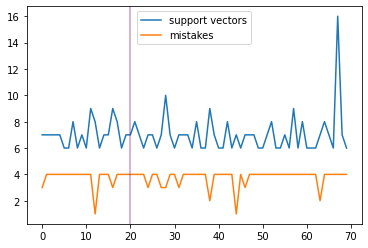

In [26]:
print(f'Mistakes {mistakes_sampling[-1]}/{len(X)} = {mistakes_sampling[-1]/len(X)*100}%')

plt.plot([len(s['betas']) for s in debug_models_sampling], label='support vectors')
plt.plot(mistakes_sampling, label='mistakes')
plt.axvline(number_of_rounds, alpha=.4, color='purple')
plt.legend()
plt.show()

In [27]:
print(f'Average mistakes: {np.average(mistakes_sampling)}')
print(f'Std mistakes: {np.std(mistakes_sampling)}')

Average mistakes: 3.757142857142857
Std mistakes: 0.6422219083711149


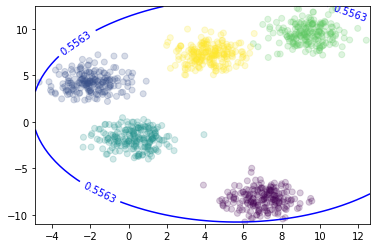

c: 1, q: 0.001545861722197428
Support Vectors are 6, over 1000 candidates
Bounded Support Vectors are 0, over 1000 candidates
Mistakes 4/1000 = 0.4%


In [28]:
plot_contour(X, debug_sk_models_sampling[-1], colors)
print_report(debug_sk_models_sampling[-1], X)

### How does the best classifier found during the process work?

In [29]:
best_mistakes = min(mistakes_sampling)
best_mistakes_index = mistakes_sampling.index(best_mistakes)

print(f'Best mistakes {best_mistakes}/{len(X)} = {best_mistakes/len(X)*100}% at round {best_mistakes_index}/{number_of_rounds_sampling}')

Best mistakes 1/1000 = 0.1% at round 12/70


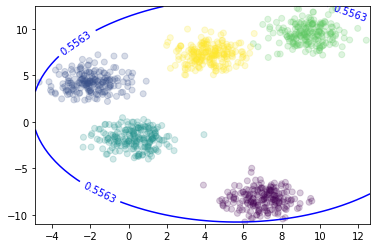

c: 1, q: 0.001545861722197428
Support Vectors are 8, over 1000 candidates
Bounded Support Vectors are 0, over 1000 candidates
Mistakes 1/1000 = 0.1%


In [30]:
plot_contour(X, debug_sk_models_sampling[best_mistakes_index], colors)
print_report(debug_sk_models_sampling[best_mistakes_index], X)